In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import matplotlib

import pandas as pd
import numpy as np
import durationpy
import math
from os.path import join
from collections import defaultdict


In [2]:
import matplotlib

In [3]:
#dir(matplotlib)

In [4]:
matplotlib.__version__

'3.1.2'

In [5]:
plt.style.use('ggplot')

COLORS_DEFAULT ={'blue': '#348ABD', 'red': '#E24A33'}

In [6]:
pd.set_option('display.max_rows', 1000)

In [7]:
# bbox_inches:None is default behavior of plt.savefig()
# makes it easier for the chart functions in this notebook
# to maintain compatibility with chart functions in generate_report.py
# in generate_report.py, do plt.savefig(bbox_inches='tight')
# in this notebook, do plt.tight_layout()
# UPDATE: tight_layout doesn't work with suptitles.
 
#%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

In [8]:
# conda install -c phlya adjusttext 
from adjustText import adjust_text

## csv result files directory name and file names

In [9]:
CSV_RESULT_DIR = "../benchmark_results_data"

STANDALONE_WASM_RESULT_FILE = "standalone_wasm_results.csv"
NATIVE_RESULT_FILE = "native_benchmarks.csv"
SCOUT_RESULT_FILE = "scout_bignum_benchmarks.csv"
GETH_PRECOMPILE_RESULT_FILE = "geth_precompile_benchmarks.csv"
EVM_RESULT_FILE = "evm_benchmarks.csv"




## To add a new engine, add the engine name used in the csv file to this list

In [10]:
INTERPRETER_ENGINES = ['life', 'wagon', 'wasmi', 'wabt', 'v8-interpreter', 'wasm3', 'wamr-interp', 'fizzy']
COMPILER_ENGINES = ['lifePolymerase', 'wasmtime', 'wavm', 'v8-liftoff', 'v8-turbofan', 'asmble', 'wamr-jit', 'wamr-aot']

wasm_vm_names = INTERPRETER_ENGINES + COMPILER_ENGINES

## Helper funcs

In [11]:
def toMs(secs):
    if secs < 0.001:
        μs = secs * 1000000
        return "{}μs".format(round(μs, 1))
    if secs < 0.1:
        ms = secs * 1000
        return "{}ms".format(round(ms, 1))
    elif secs < 1:
        ms = secs * 1000
        return "{}ms".format(int(round(ms, 0)))
    else:
        return "{}s".format(round(secs, 2))

In [12]:
def labelBarHeights(ax, to_ms=True, small=False, to_factor=False, lower_y_bound=True):
    labels = []
    for p in ax.patches:
        if p.get_height() == 0:
            continue
        label_val = p.get_height()
        #print("height:", p.get_height())
        y_pos = p.get_y() + label_val
        #y_offset = -10
        y_offset = 0
        y_bound = ax.get_ybound()[1]
        if y_pos > y_bound:
            y_pos = y_bound
        #if label_val < (0.03 * y_bound):
            # if bar is too small to fit text, place above the bar
            #y_offset = 5
        if lower_y_bound:
            if label_val < (0.03 * y_bound) and small is False:
                # don't place labels near bottom axis, adjust_text cant deal
                y_offset = 0.03 * y_bound
        
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            if not isinstance(to_factor, int):
                to_factor = 2
            label_val = str(round(label_val, to_factor)) + "x"
        """
        txt_label = ax.annotate(toMs(label_val),
                    (p.get_x()+p.get_width()/2.,
                     y_pos),
                    ha='center',
                    va='center',
                    xytext=(0, y_offset),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")
        """
 
        txt_label = ax.text(
                    x=p.get_x()+p.get_width()/2.,
                    y=y_pos+y_offset,
                    s=label_val,
                    ha='center',
                    va='center',
                    #xytext=(0, y_offset),
                    #textcoords='offset points',
                    fontsize=10,
                    weight="bold")

        labels.append(txt_label)

    #adjust_text(labels, ax=ax)
    return labels

In [13]:
def labelBarWidths(ax, to_ms=True, to_factor=False, to_kb=False, round_places=None):
    for p in ax.patches:
        label_val = p.get_width()
        if label_val == 0:
            continue
        #print("bar width:", label_val)
        x_pos = p.get_x() + label_val
        x_offset = -30
        x_bound = ax.get_xbound()[1]
        if (x_pos > x_bound):
            x_pos = x_bound
        #if label_val < (0.25 * x_bound):
        if label_val < (0.15 * x_bound):
            # if bar is too small to fit text, place next to bar
            x_offset = 30
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            label_val = str(round(label_val, 2)) + "x"
        if to_kb:
            kbs = label_val / 1000.0
            label_val = str(round(kbs, 1)) + " kB"
        if round_places:
            label_val = str(round(label_val, round_places))
        ax.annotate(label_val,
                    (x_pos,
                     p.get_y()+p.get_height()/2.),
                    ha='center',
                    va='center',
                    xytext=(x_offset, 0),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")


In [14]:
def adjust_text_labels(labels, ax=None):
    adjust_text(labels, ax=ax, autoalign='y', only_move={'points':'y', 'text':'y'})
                       

In [15]:
def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)    
    return csv_results

In [16]:
def filterDfEngines(df_data, engines):
    df_data_filtered = df_data.copy()
    for fil in engines:
        df_data_filtered = df_data_filtered[df_data_filtered['engine'] != fil]

    return df_data_filtered

## print benchmark machine cpu type

In [17]:
with open(join(CSV_RESULT_DIR, "cpuinfo.txt"), 'r') as cpuinfofile:
    [print(line.rstrip()) for line in cpuinfofile.readlines()]


model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 768.134
model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 790.887
model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 734.023
model name	: Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz
cpu MHz		: 774.952


## Import EVM engine results

In [18]:
df_evm_raw = read_results(join(CSV_RESULT_DIR, EVM_RESULT_FILE))

In [19]:
df_evm_raw

engine                         test_name  total_time  gas_used
0       evmone          sha1-10808-bits-shiftopt    0.001596  759.785k
1   parity-evm          sha1-10808-bits-shiftopt    0.022314    759785
2     geth-evm          sha1-10808-bits-shiftopt    0.017770    759785
3     cita-evm          sha1-10808-bits-shiftopt    0.012676    873117
4       evmone          sha1-21896-bits-shiftopt    0.003226  1.48425M
5   parity-evm          sha1-21896-bits-shiftopt    0.040143   1484254
6     geth-evm          sha1-21896-bits-shiftopt    0.035941   1484254
7     cita-evm          sha1-21896-bits-shiftopt    0.025492   1691062
8       evmone          sha1-42488-bits-shiftopt    0.006501  2.89847M
9   parity-evm          sha1-42488-bits-shiftopt    0.086442   2898473
10    geth-evm          sha1-42488-bits-shiftopt    0.076433   2898473
11    cita-evm          sha1-42488-bits-shiftopt    0.050730   3280257
12      evmone       blake2b-8415-bytes-shiftopt    0.037586  12.0431M
13  parity-evm       blake2b-8415-bytes-shiftopt    0.304235  12043105
14    geth-evm       blake2b-8415-bytes-shiftopt    0.250975  12043105
15    cita-evm       blake2b-8415-bytes-shiftopt    0.227318  12635513
16      evmone       blake2b-5610-bytes-shiftopt    0.024851  7.43482M
17  parity-evm       blake2b-5610-bytes-shiftopt    0.191788   7434820
18    geth-evm       blake2b-5610-bytes-shiftopt    0.164830   7434820
19    cita-evm       blake2b-5610-bytes-shiftopt    0.148495   7837276
20      evmone       blake2b-2805-bytes-shiftopt    0.012214  3.42353M
21  parity-evm       blake2b-2805-bytes-shiftopt    0.099552   3423526
22    geth-evm       blake2b-2805-bytes-shiftopt    0.083734   3423526
23    cita-evm       blake2b-2805-bytes-shiftopt    0.075648   3635902
24      evmone                blake2b-8415-bytes    0.044307  12.3518M
25  parity-evm                blake2b-8415-bytes    0.312272  12351815
26    geth-evm                blake2b-8415-bytes    0.258288  12351815
27    cita-evm                blake2b-8415-bytes    0.287592  12944223
28      evmone                blake2b-5610-bytes    0.029281  7.64067M
29  parity-evm                blake2b-5610-bytes    0.197468   7640669
30    geth-evm                blake2b-5610-bytes    0.176871   7640669
31    cita-evm                blake2b-5610-bytes    0.191671   8043125
32      evmone                blake2b-2805-bytes    0.015022  3.52651M
33  parity-evm                blake2b-2805-bytes    0.104159   3526514
34    geth-evm                blake2b-2805-bytes    0.086334   3526514
35    cita-evm                blake2b-2805-bytes    0.094874   3738890
36      evmone               bn256g2mul-0xAshish    0.002260  455.757k
37  parity-evm               bn256g2mul-0xAshish    0.019949    455757
38    geth-evm               bn256g2mul-0xAshish    0.015922    455757
39    cita-evm               bn256g2mul-0xAshish    0.042454    486053
40      evmone   bn128_mul_weierstrudel-cdetrio2    0.000521   47.165k
41  parity-evm   bn128_mul_weierstrudel-cdetrio2    0.004142     47165
42    geth-evm   bn128_mul_weierstrudel-cdetrio2    0.002277     47165
43    cita-evm   bn128_mul_weierstrudel-cdetrio2    0.017047     74437
44      evmone    bn128_mul_weierstrudel-chfast1    0.000294   23.449k
45  parity-evm    bn128_mul_weierstrudel-chfast1    0.001957     23449
46    geth-evm    bn128_mul_weierstrudel-chfast1    0.001065     23449
47    cita-evm    bn128_mul_weierstrudel-chfast1    0.007357     49441
48      evmone    bn128_mul_weierstrudel-chfast2    0.000458   39.337k
49  parity-evm    bn128_mul_weierstrudel-chfast2    0.003426     39337
50    geth-evm    bn128_mul_weierstrudel-chfast2    0.001819     39337
51    cita-evm    bn128_mul_weierstrudel-chfast2    0.014045     66865
52      evmone    bn128_mul_weierstrudel-chfast3    0.000525   47.291k
53  parity-evm    bn128_mul_weierstrudel-chfast3    0.004223     47291
54    geth-evm    bn128_mul_weierstrudel-chfast3    0.002231     47291
55    cita-evm    bn128_mul_weie

In [20]:
# TODO: plot EVM vs wasm shootout using grouped bar plot.

### Import scout engine results

In [21]:
df_scout_data = read_results(join(CSV_RESULT_DIR, SCOUT_RESULT_FILE))

## functions for plotting a two engine comparison

In [22]:
## we aren't using this chart style anymore. replaced by plotThreeTestsGrouped()
def plotTwoEngines(df_benches, two_engines, title="Title"):
    df_1 = df_benches[df_benches['engine'] == two_engines[0]]
    df_2 = df_benches[df_benches['engine'] == two_engines[1]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 2, sharey=True, figsize=(13,6))

    df_1.set_index('bench_name').sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(two_engines[0])
    ax1[0].set(ylabel='seconds', xlabel='')
    df_2.set_index('bench_name').sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(two_engines[1])
    ax1[1].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


#df_sha256_1024 = df_scout_data[df_scout_data['bench_name'].str.contains('sha256_1024')]
#df_blake2b_64 = df_scout_data[df_scout_data['bench_name'].str.contains('blake2b_64')]
#plotTwoEngines(df_sha256_1024, ["wabt-baseline", "wabt-with-superops"], "sha256 1024 bytes")
#plotTwoEngines(df_blake2b_64, ["wabt-baseline", "wabt-with-superops"], "blake2b 64 bytes")

In [23]:
def plotThreeTestsGrouped(df_benches, three_tests, title="Title"):
    df_1 = df_benches[df_benches['bench_name'].str.contains(three_tests[0])]
    df_2 = df_benches[df_benches['bench_name'].str.contains(three_tests[1])]
    df_3 = df_benches[df_benches['bench_name'].str.contains(three_tests[2])]
    # to group by engine, pivot to `columns='enginge'`
    df_1 = pd.pivot_table(df_1, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    df_2 = pd.pivot_table(df_2, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    df_3 = pd.pivot_table(df_3, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)

    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(13,6))

    df_1.sort_values('wabt-with-superops').plot.bar(ax=ax1[0])
    ax1[0].set_title(three_tests[0])
    ax1[0].set(ylabel='seconds', xlabel='')

    df_2.sort_values('wabt-with-superops').plot.bar(ax=ax1[1])
    ax1[1].set_title(three_tests[1])
    ax1[1].set(xlabel='')

    df_3.sort_values('wabt-with-superops').plot.bar(ax=ax1[2])
    ax1[2].set_title(three_tests[2])
    ax1[2].set(xlabel='')

    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])

    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


## Compare wabt-optimized against wabt-baseline on hash function benchmarks

<Figure size 432x288 with 0 Axes>

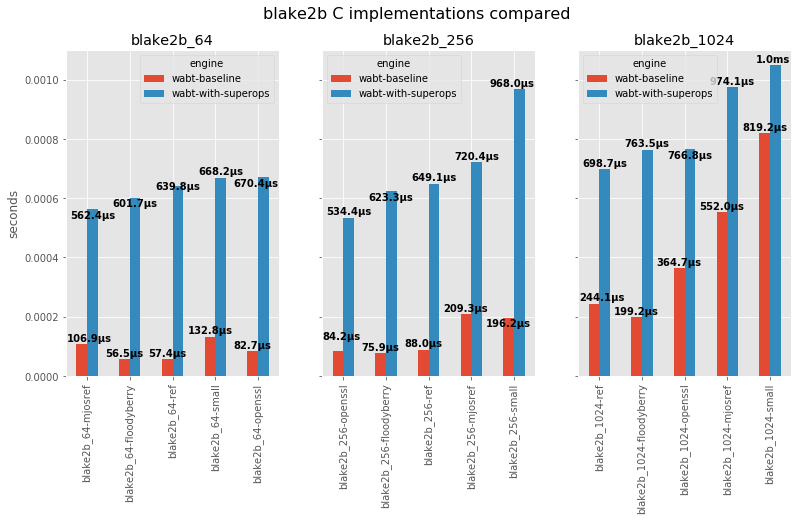

In [24]:
plotThreeTestsGrouped(df_scout_data, ["blake2b_64", "blake2b_256", "blake2b_1024"], "blake2b C implementations compared")


<Figure size 432x288 with 0 Axes>

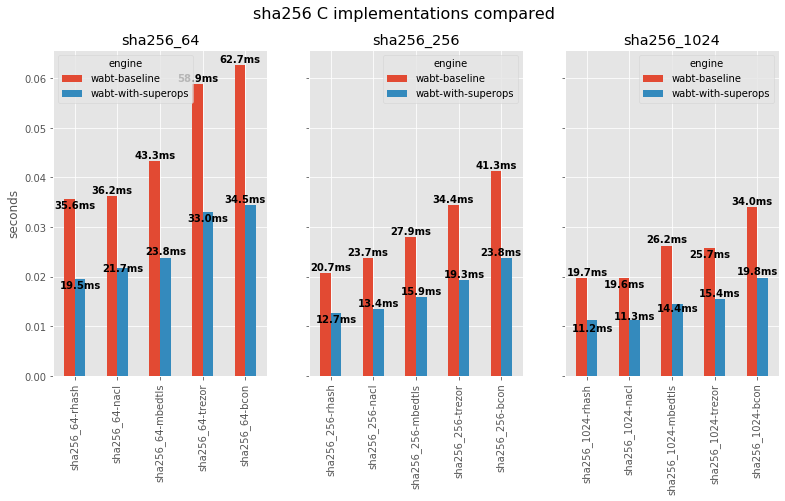

In [25]:
plotThreeTestsGrouped(df_scout_data, ["sha256_64", "sha256_256", "sha256_1024"], "sha256 C implementations compared")


<Figure size 432x288 with 0 Axes>

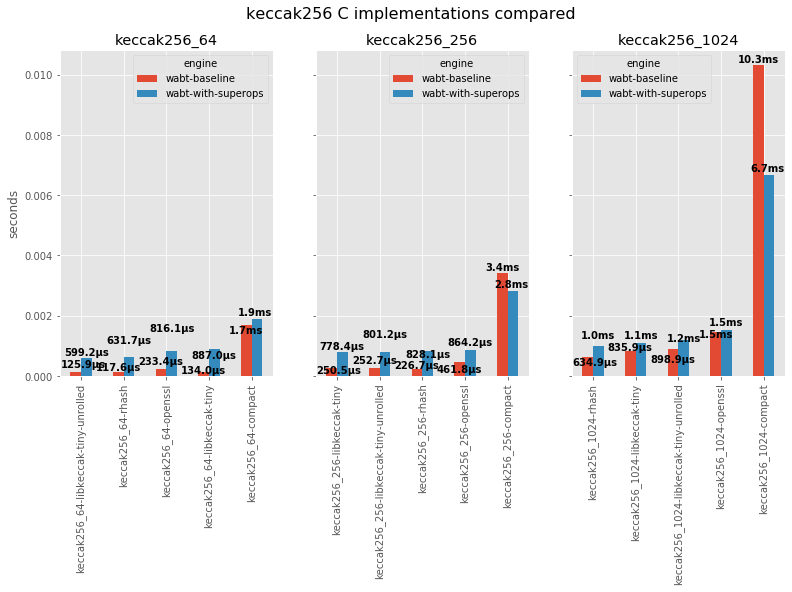

In [26]:
plotThreeTestsGrouped(df_scout_data, ["keccak256_64", "keccak256_256", "keccak256_1024"], "keccak256 C implementations compared")


## functions for plotting biturbo and bignum benchmarks

In [27]:
plt.rcParams['figure.constrained_layout.use'] = False

In [28]:
# non-stacked bar chart, for only plotting exec time or total time
def plotOneTest(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium'):
    plt.figure()
    
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times.fillna(0, inplace=True)
    df_total_times['time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax = df_total_times.sort_values('time')[['time']].plot.bar(figsize=(14,8), color=COLORS_DEFAULT['blue'])
    
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)

    #plt.show()


In [29]:
# non-stacked bar chart, for only plotting exec time or total time
def plotOneTestColoredTicks(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium', highlight_tick=None):
    plt.figure()
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times.fillna(0, inplace=True)
    df_total_times['time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax = df_total_times.sort_values('time')[['time']].plot.bar(figsize=(14,8), color=COLORS_DEFAULT['blue'])
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    if highlight_tick is not None:
        for i in plt.gca().get_xticklabels():
            if i.get_text() == highlight_tick:
                i.set_color('tab:green')
                i.set_fontstyle('oblique')
                i.set_fontweight('heavy')
                
        # {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}
        #[i.set_color('tab:green') for i in plt.gca().get_xticklabels() if i.get_text() == highlight_tick]
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    plt.show()

In [30]:
def plotOneTestGrouped(df_1, test_title="test_title", title="plot Title", colors=['tab:blue', 'tab:orange'], sort_by='websnark-bn128-two-pairings', group_order=None):
    # to group by engine, pivot to `columns='engine'`
    #df_1 = pd.pivot_table(df_1, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    # group by bench name
    df_1['time'] = df_1['exec_time'] + df_1['parse_time']
    df_1 = pd.pivot_table(df_1, values='time', columns=['bench_name'], index=['engine'], aggfunc=np.mean)
    # order to get websnark as the group on the left
    if group_order is not None:
        df_1 = df_1[group_order]

    plt.figure()
    ax = df_1.sort_values(sort_by).plot.bar(figsize=(14,8), color=colors)
    #ax = df_1.plot.bar(figsize=(14,8))
    ax.set_title(test_title)
    ax.set(ylabel='seconds', xlabel='')

    adjust_text_labels(labelBarHeights(ax))

    plt.suptitle(title, fontsize=16, y=0.98)
    plt.show()


In [31]:
def plotScoutStackedTest(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium'):
    plt.figure()
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_data[['exec_time', 'parse_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "startup time"])
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    plt.show()


## Plot biturbo benchmark: biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof

In [32]:
df_scout_biturbo_token = df_scout_data[df_scout_data['bench_name'] == 'biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof']

df_scout_means_biturbo_token = df_scout_biturbo_token.groupby(['engine']).mean()
df_scout_fast_biturbo_token = filterDfEngines(df_scout_biturbo_token, ['v8-interpreter'])
df_scout_fast_biturbo_means = df_scout_fast_biturbo_token.groupby(['engine']).mean()



<Figure size 432x288 with 0 Axes>

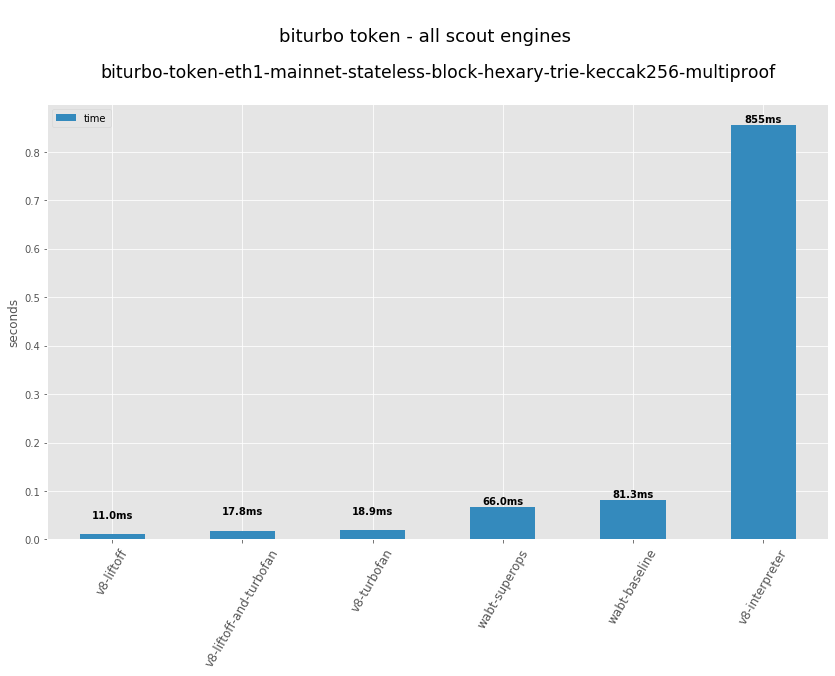

In [33]:
plotOneTest(df_scout_means_biturbo_token,
            suptitle="\nbiturbo token - all scout engines",
            suptitle_pos=1.05,
            subtitle="biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

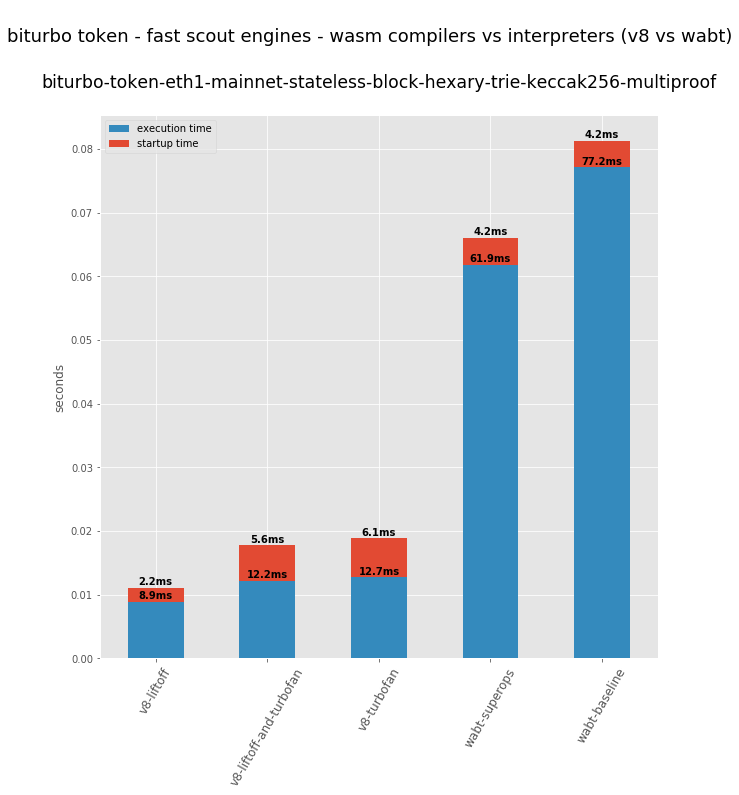

In [34]:
plotScoutStackedTest(df_scout_fast_biturbo_means,
            suptitle="\nbiturbo token - fast scout engines - wasm compilers vs interpreters (v8 vs wabt)",
            suptitle_pos=1.03,
            subtitle="biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof\n",
            subtitle_size='xx-large')

## Plot bignum benchmark: ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs

In [35]:
df_scout_ecrecover_websnark_secp256k1 = df_scout_data[df_scout_data['bench_name'] == 'ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs']

df_scout_means_ecrecover_websnark_secp256k1 = df_scout_ecrecover_websnark_secp256k1.groupby(['engine']).mean()
df_scout_fast_ecrecover = filterDfEngines(df_scout_ecrecover_websnark_secp256k1,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_ecrecover_means = df_scout_fast_ecrecover.groupby(['engine']).mean()



<Figure size 432x288 with 0 Axes>

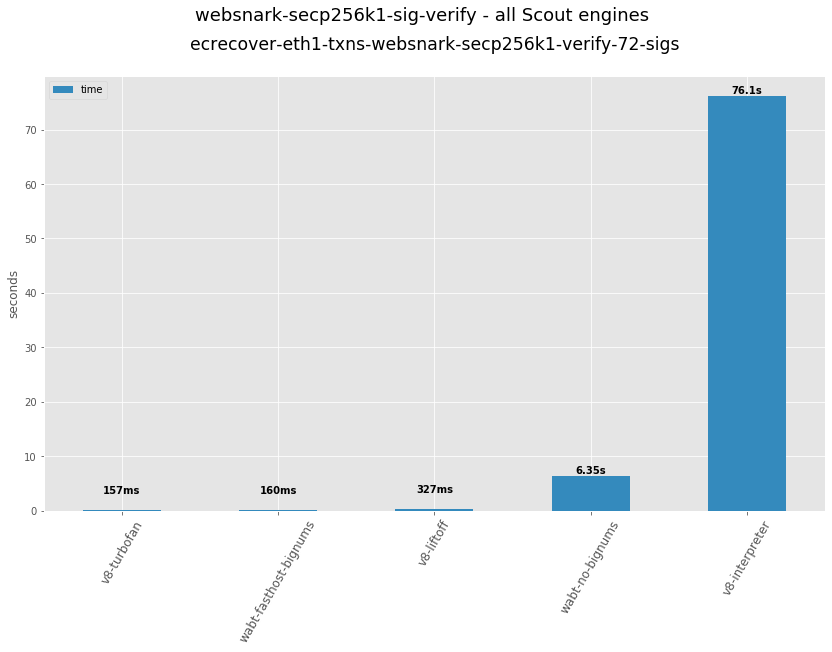

In [36]:
plotOneTest(df_scout_means_ecrecover_websnark_secp256k1,
            suptitle="websnark-secp256k1-sig-verify - all Scout engines",
            suptitle_pos=1.0,
            subtitle="ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs\n",
            subtitle_size='xx-large')


<Figure size 432x288 with 0 Axes>

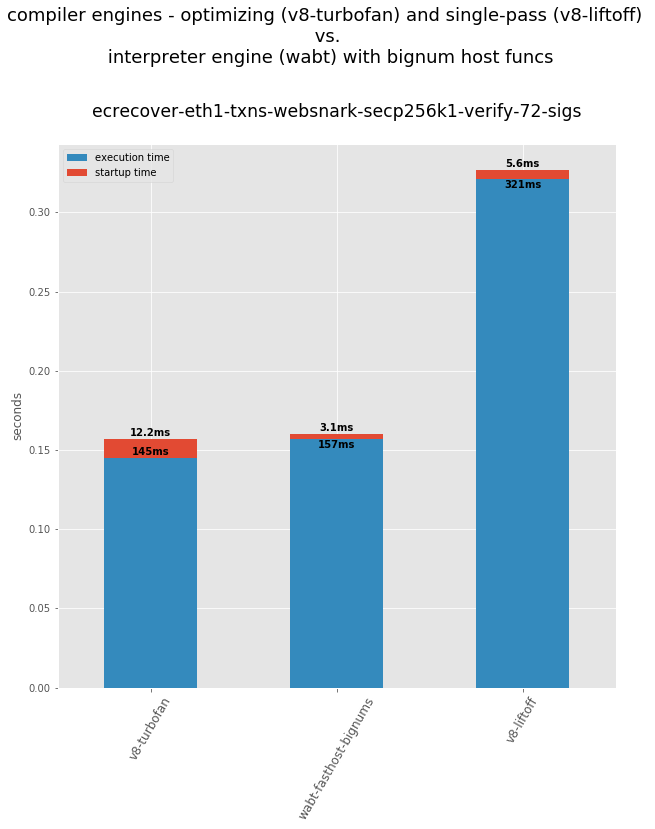

In [37]:
plotScoutStackedTest(df_scout_fast_ecrecover_means,
            #suptitle="websnark-secp256k1-sig-verify - fast Scout engines - compilers (v8) vs interpreters (wabt)",
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs\n",
            subtitle_size='xx-large')


## Plot bignum benchmark: ecpairing-zkrollup-websnark-bn128-two-pairings

In [38]:
df_scout_ecpairing_zkrollup_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']

df_scout_means_ecpairing_zkrollup = df_scout_ecpairing_zkrollup_bn128_pairings.groupby(['engine']).mean()
df_scout_fast_ecpairing_zkrollup = filterDfEngines(df_scout_ecpairing_zkrollup_bn128_pairings,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_ecpairing_zkrollup = df_scout_fast_ecpairing_zkrollup.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

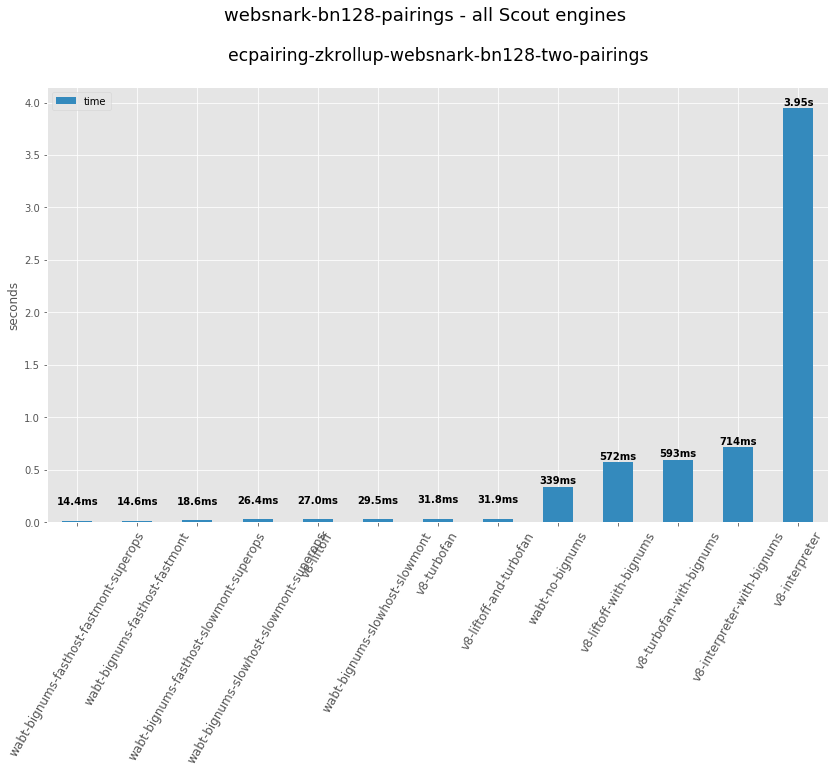

In [39]:
plotOneTest(df_scout_means_ecpairing_zkrollup,
            suptitle="websnark-bn128-pairings - all Scout engines",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

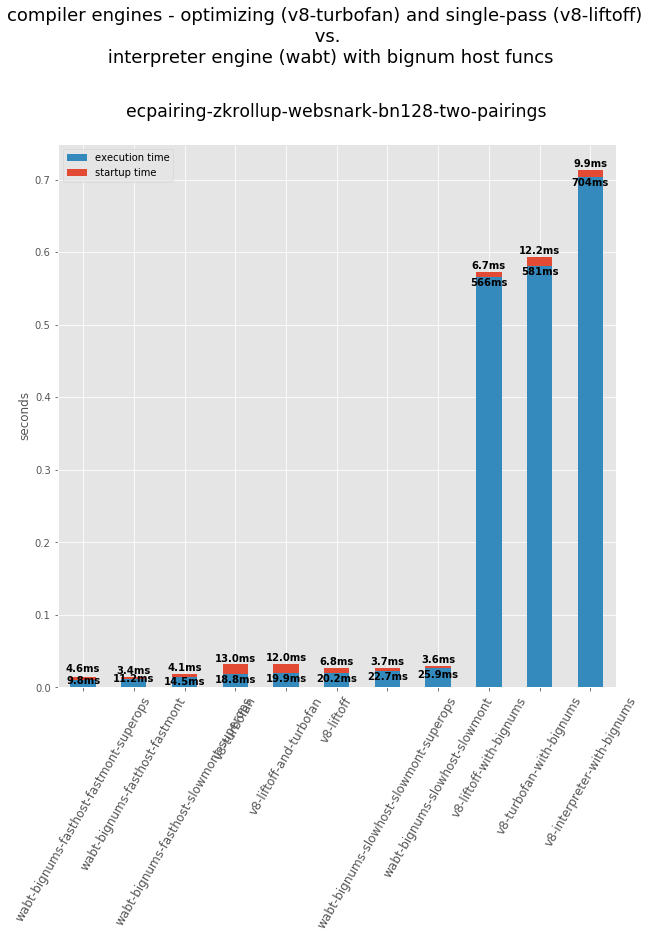

In [40]:
plotScoutStackedTest(df_scout_fast_means_ecpairing_zkrollup,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')

## start with rust bn128 pairings, compare to native, and compare interpreters to compilers

In [41]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-wasm-bn128-two-pairings']

df_scout_fast_rolluprs = filterDfEngines(df_scout_rolluprs_bn128_pairings,
    ['scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])

df_scout_means_rolluprs = df_scout_rolluprs_bn128_pairings.groupby(['engine']).mean()

#df_scout_fast_means_rolluprs = df_scout_fast_rolluprs.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

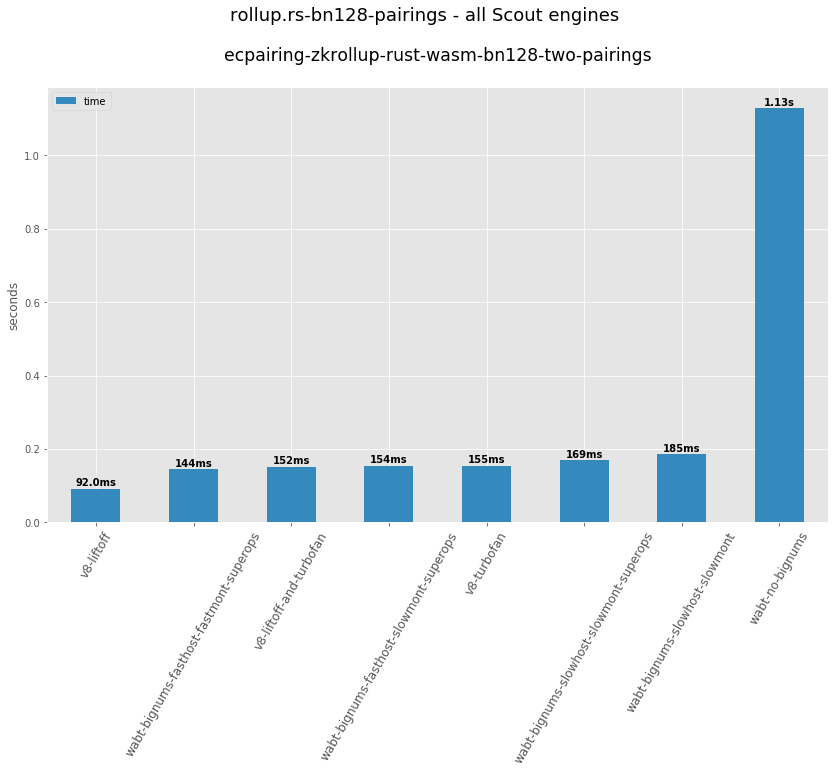

In [42]:
plotOneTest(df_scout_means_rolluprs,
            suptitle="rollup.rs-bn128-pairings - all Scout engines",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large')


## websnark bn128 pairings versus rust->wasm bn128 pairings

### add rust-native to rust-wasm

In [43]:
df_scout_rolluprs_bn128_pairings = df_scout_data[df_scout_data['bench_name'].isin(
    ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
)]

#df_scout_rolluprs_rustnative = df_scout_rolluprs_rustnative.fillna(0)

df_scout_means_rolluprs = df_scout_rolluprs_bn128_pairings.groupby(['engine']).mean()
df_scout_fast_rolluprs = filterDfEngines(df_scout_rolluprs_bn128_pairings,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_rolluprs = df_scout_fast_rolluprs.groupby(['engine']).mean()

<Figure size 432x288 with 0 Axes>

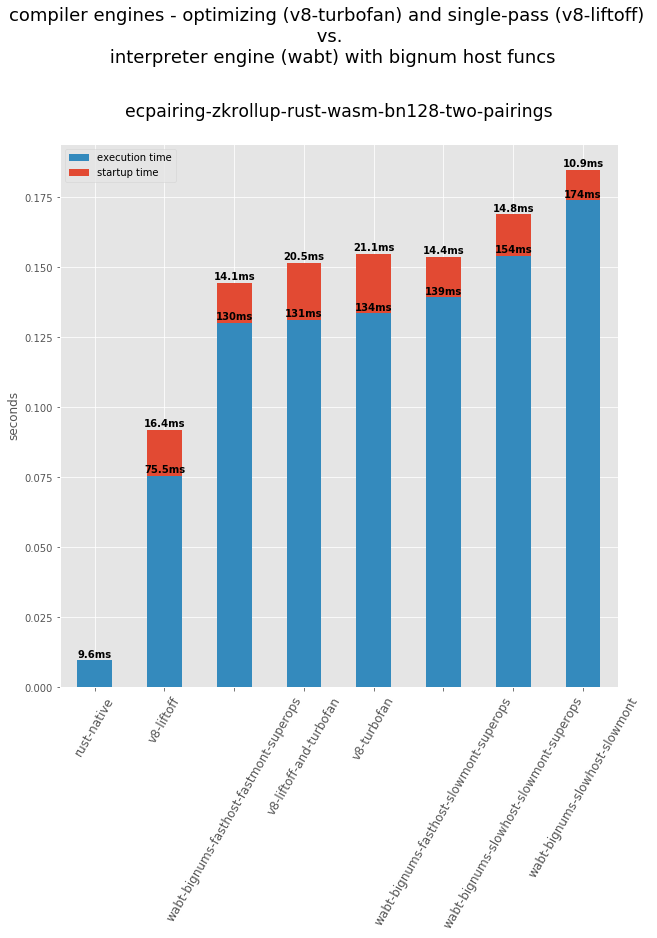

In [44]:
plotScoutStackedTest(df_scout_fast_means_rolluprs,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large')

# rust vs websnark

In [46]:
df_scout_rust_vs_websnark = df_scout_data[
    df_scout_data['bench_name'].isin(
        ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings',
         'ecpairing-zkrollup-websnark-bn128-two-pairings']
    )
].copy()


In [47]:
#df_scout_rust_vs_websnark

In [48]:
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm-bn128-two-pairings', inplace=True)
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-bn128-two-pairings', inplace=True)

df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm', inplace=True)
df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-wasm', inplace=True)




In [49]:
df_scout_rust_vs_websnark = df_scout_rust_vs_websnark[df_scout_rust_vs_websnark['engine'].isin(
['wabt-superops-bignums-slowmont', 'wabt-bignums-fasthost', 'wabt-superops-bignums', 'rust-native', 'v8-liftoff', 'v8-turbofan']  
)].copy()

In [50]:
df_scout_rust_vs_websnark

engine     bench_name  parse_time  exec_time
1383  v8-turbofan  websnark-wasm    0.012526   0.019856
1384   v8-liftoff  websnark-wasm    0.006579   0.019689
1390  v8-turbofan      rust-wasm    0.020768   0.117253
1391   v8-liftoff      rust-wasm    0.014276   0.070435
1404  v8-turbofan  websnark-wasm    0.009650   0.021088
1405   v8-liftoff  websnark-wasm    0.008004   0.024127
1411  v8-turbofan      rust-wasm    0.026583   0.149700
1412   v8-liftoff      rust-wasm    0.014841   0.073529
1425  v8-turbofan  websnark-wasm    0.012767   0.022378
1426   v8-liftoff  websnark-wasm    0.005548   0.019110
1432  v8-turbofan      rust-wasm    0.021325   0.174255
1433   v8-liftoff      rust-wasm    0.020844   0.086226
1446  v8-turbofan  websnark-wasm    0.017035   0.013030
1447   v8-liftoff  websnark-wasm    0.006073   0.020707
1453  v8-turbofan      rust-wasm    0.016605   0.134006
1454   v8-liftoff      rust-wasm    0.015319   0.074035
1467  v8-turbofan  websnark-wasm    0.018203   0.009751
1468   v8-liftoff  websnark-wasm    0.008814   0.023093
1474  v8-turbofan      rust-wasm    0.024023   0.134648
1475   v8-liftoff      rust-wasm    0.015236   0.079856
1488  v8-turbofan  websnark-wasm    0.008143   0.021469
1489   v8-liftoff  websnark-wasm    0.007741   0.018612
1495  v8-turbofan      rust-wasm    0.023877   0.133244
1496   v8-liftoff      rust-wasm    0.017361   0.075689
1509  v8-turbofan  websnark-wasm    0.017057   0.018729
1510   v8-liftoff  websnark-wasm    0.006571   0.017507
1516  v8-turbofan      rust-wasm    0.017040   0.104339
1517   v8-liftoff      rust-wasm    0.019689   0.081577
1530  v8-turbofan  websnark-wasm    0.010434   0.019931
1531   v8-liftoff  websnark-wasm    0.005923   0.018019
1537  v8-turbofan      rust-wasm    0.023734   0.132254
1538   v8-liftoff      rust-wasm    0.016115   0.076024
1551  v8-turbofan  websnark-wasm    0.010991   0.021644
1552   v8-liftoff  websnark-wasm    0.006589   0.019597
1558  v8-turbofan      rust-wasm    0.018475   0.147403
1559   v8-liftoff      rust-wasm    0.014731   0.069060
1572  v8-turbofan  websnark-wasm    0.013389   0.020083
1573   v8-liftoff  websnark-wasm    0.006411   0.021431
1579  v8-turbofan      rust-wasm    0.018963   0.108605
1580   v8-liftoff      rust-wasm    0.016029   0.068794

In [51]:
# {'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'}


<Figure size 432x288 with 0 Axes>

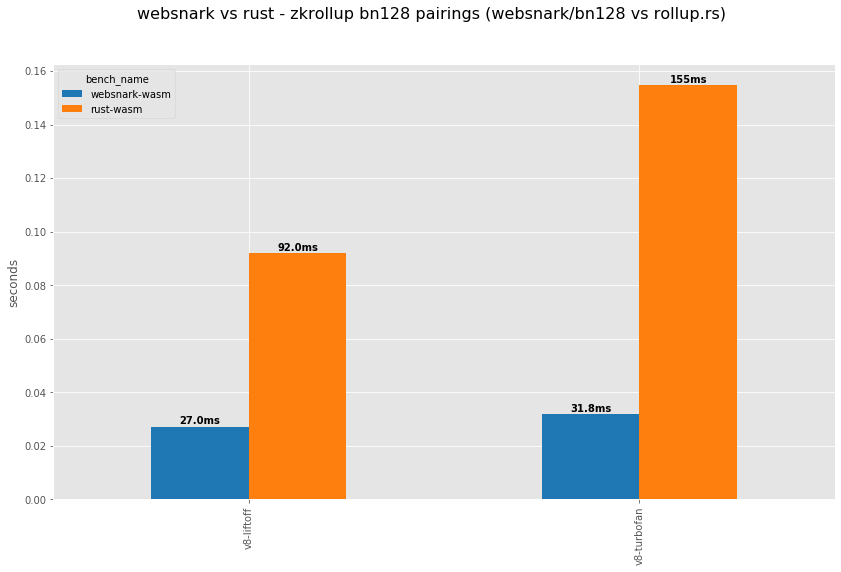

In [52]:
plotOneTestGrouped(df_scout_rust_vs_websnark,
                   title="websnark vs rust - zkrollup bn128 pairings (websnark/bn128 vs rollup.rs)",
                   test_title="",
                   group_order=['websnark-wasm', 'rust-wasm'],
                   sort_by="rust-wasm",
                   colors=['tab:blue', 'tab:orange'])

In [53]:
df_rolluprs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-rust-native-bn128-two-pairings']
df_rolluprs_native = df_rolluprs_native.fillna(0)

df_rolluprs_native.replace('ecpairing-zkrollup-rust-native-bn128-two-pairings', 'rust-native', inplace=True)


df_scout_rust_vs_websnark_fast_vs_native = df_scout_rust_vs_websnark.append(df_rolluprs_native, sort=False)

<Figure size 432x288 with 0 Axes>

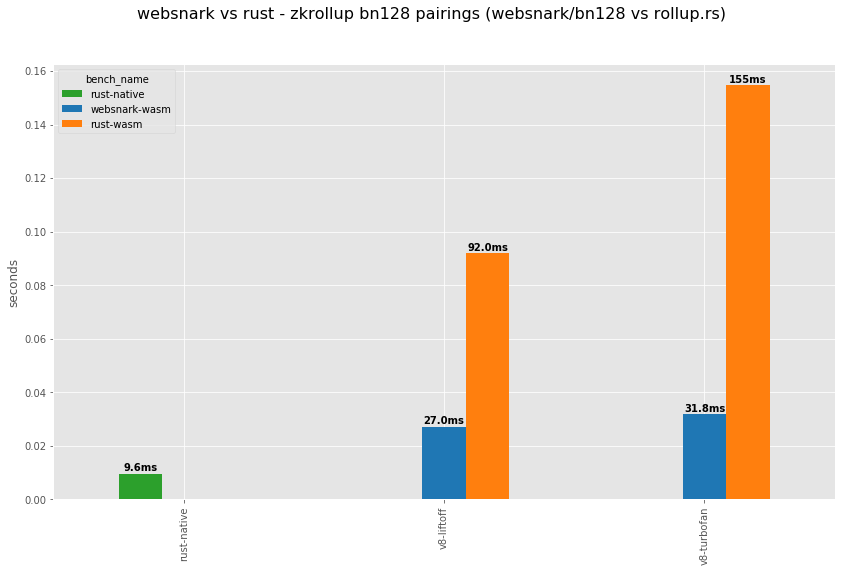

In [54]:

plotOneTestGrouped(df_scout_rust_vs_websnark_fast_vs_native,
               title="websnark vs rust - zkrollup bn128 pairings (websnark/bn128 vs rollup.rs)",
               test_title="",
               sort_by=["rust-native", "rust-wasm", "websnark-wasm"],
               colors=['tab:green', 'tab:blue', 'tab:orange'],
               group_order=["rust-native", "websnark-wasm", "rust-wasm"])


## Just websnark against native

In [55]:
# print out the engine names

df_websnark_vs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings'].copy()
df_websnark_vs_native.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-bn128-two-pairings', inplace=True)

df_websnark_vs_native['engine'].unique().tolist()

['wabt-no-bignums',
 'wabt-bignums-slowhost-slowmont',
 'wabt-bignums-slowhost-slowmont-superops',
 'wabt-bignums-fasthost-slowmont-superops',
 'wabt-bignums-fasthost-fastmont-superops',
 'wabt-bignums-fasthost-fastmont',
 'v8-turbofan',
 'v8-liftoff',
 'v8-liftoff-and-turbofan',
 'v8-interpreter',
 'v8-turbofan-with-bignums',
 'v8-liftoff-with-bignums',
 'v8-interpreter-with-bignums']

In [56]:
df_websnark_vs_native = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings'].copy()
df_websnark_vs_native.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-bn128-two-pairings', inplace=True)

df_websnark_vs_native = df_websnark_vs_native[df_websnark_vs_native['engine'].isin(
['wabt-bignums-fasthost', 'wabt-bignums-slowhost', 'wabt-superops-bignums', 'wabt-superops-bignums-slowmont', 'wabt-with-bignums-and-superops', 'wabt-with-bignums', 'rust-native', 'v8-liftoff', 'v8-turbofan']  
)]

df_websnark_vs_native = df_websnark_vs_native.append(df_rolluprs_native)

df_websnark_vs_native_means = df_websnark_vs_native.groupby(['engine']).mean()


In [57]:
#df_websnark_vs_native_means

<Figure size 432x288 with 0 Axes>

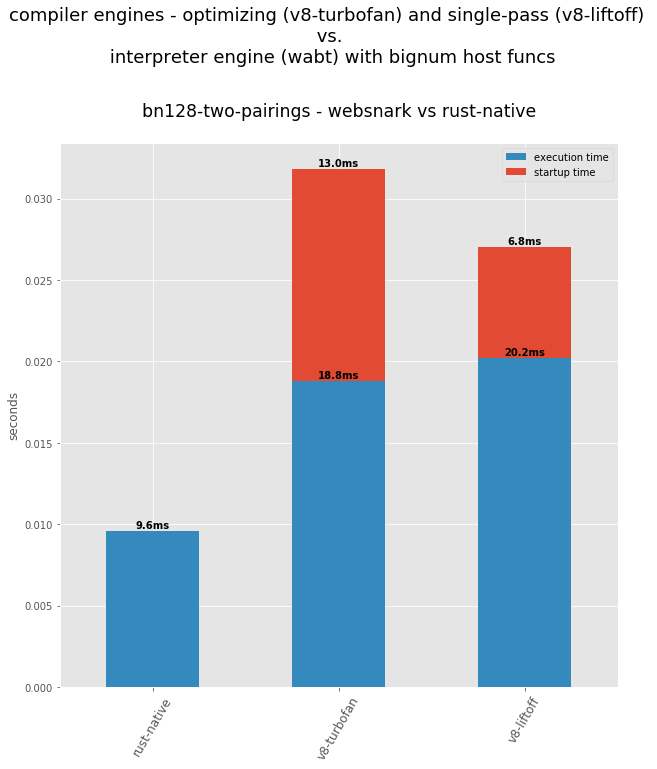

In [58]:
plotScoutStackedTest(df_websnark_vs_native_means,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="bn128-two-pairings - websnark vs rust-native\n",
            subtitle_size='xx-large')

# Try Seaborn with error bars

In [59]:
import seaborn as sns

In [60]:
df_websnark_vs_native['time'] = df_websnark_vs_native['exec_time'] + df_websnark_vs_native['parse_time']


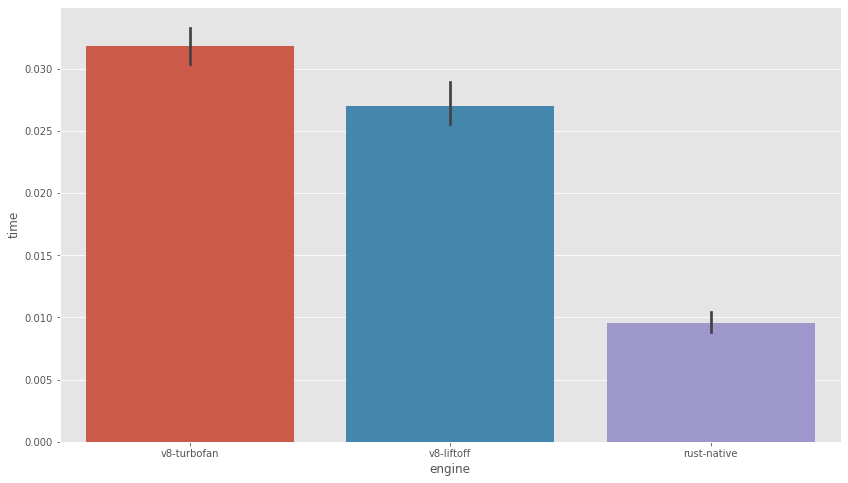

In [61]:
f = plt.figure(figsize=(14,8))

sns.barplot(x='engine', y='time', data=df_websnark_vs_native)

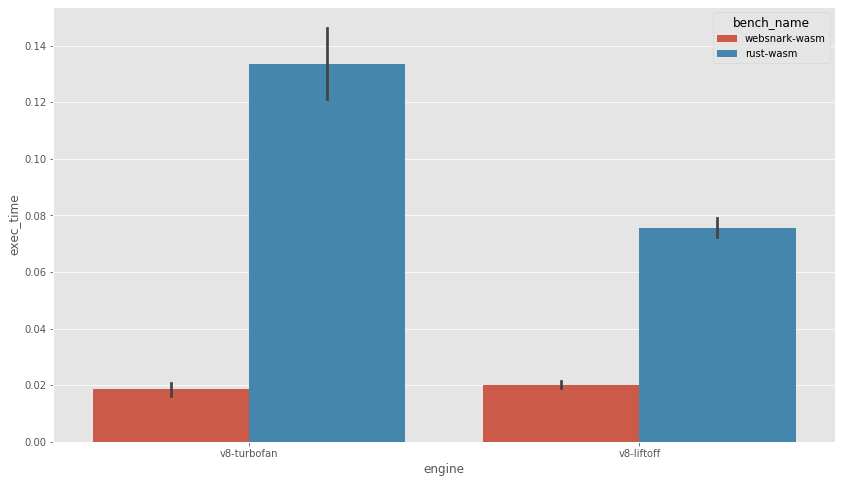

In [62]:
f = plt.figure(figsize=(14,8))

sns.barplot(x='engine', y='exec_time', hue='bench_name', data=df_scout_rust_vs_websnark)

## Plot bignum benchmark: zkrollup-rust

In [63]:
df_scout_websnark_zkrollup = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']


In [64]:
df_scout_websnark_zkrollup['engine'].unique().tolist()

['wabt-no-bignums',
 'wabt-bignums-slowhost-slowmont',
 'wabt-bignums-slowhost-slowmont-superops',
 'wabt-bignums-fasthost-slowmont-superops',
 'wabt-bignums-fasthost-fastmont-superops',
 'wabt-bignums-fasthost-fastmont',
 'v8-turbofan',
 'v8-liftoff',
 'v8-liftoff-and-turbofan',
 'v8-interpreter',
 'v8-turbofan-with-bignums',
 'v8-liftoff-with-bignums',
 'v8-interpreter-with-bignums']

In [65]:
df_scout_websnark_zkrollup = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']

#df_scout_websnark_zkrollup_means = df_scout_websnark_zkrollup.groupby(['engine']).mean()

df_scout_websnark_zkrollup = df_scout_websnark_zkrollup[df_scout_websnark_zkrollup['engine'].isin(
    ['wabt-bignums-fasthost-fastmont-superops', 'v8-turbofan', 'v8-liftoff']
)]


#df_scout_websnark_zkrollup = filterDfEngines(df_scout_websnark_zkrollup,
#    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_websnark_zkrollup_means = df_scout_websnark_zkrollup.groupby(['engine']).mean()


In [66]:
df_scout_websnark_zkrollup

engine  \
1241  wabt-bignums-fasthost-fastmont-superops   
1254  wabt-bignums-fasthost-fastmont-superops   
1267  wabt-bignums-fasthost-fastmont-superops   
1280  wabt-bignums-fasthost-fastmont-superops   
1293  wabt-bignums-fasthost-fastmont-superops   
1306  wabt-bignums-fasthost-fastmont-superops   
1319  wabt-bignums-fasthost-fastmont-superops   
1332  wabt-bignums-fasthost-fastmont-superops   
1345  wabt-bignums-fasthost-fastmont-superops   
1358  wabt-bignums-fasthost-fastmont-superops   
1383                              v8-turbofan   
1384                               v8-liftoff   
1404                              v8-turbofan   
1405                               v8-liftoff   
1425                              v8-turbofan   
1426                               v8-liftoff   
1446                              v8-turbofan   
1447                               v8-liftoff   
1467                              v8-turbofan   
1468                               v8-liftoff   
1488                              v8-turbofan   
1489                               v8-liftoff   
1509                              v8-turbofan   
1510                               v8-liftoff   
1530                              v8-turbofan   
1531                               v8-liftoff   
1551                              v8-turbofan   
1552                               v8-liftoff   
1572                              v8-turbofan   
1573                               v8-liftoff   

                                          bench_name  parse_time  exec_time  
1241  ecpairing-zkrollup-websnark-bn128-two-pairings    0.005940   0.012779  
1254  ecpairing-zkrollup-websnark-bn128-two-pairings    0.004661   0.009746  
1267  ecpairing-zkrollup-websnark-bn128-two-pairings    0.004381   0.009831  
1280  ecpairing-zkrollup-websnark-bn128-two-pairings    0.004789   0.010185  
1293  ecpairing-zkrollup-websnark-bn128-two-pairings    0.004789   0.009867  
1306  ecpairing-zkrollup-websnark-bn128-two-pairings    0.004466   0.009211  
1319  ecpairing-zkrollup-websnark-bn128-two-pairings    0.005109   0.009164  
1332  ecpairing-zkrollup-websnark-bn128-two-pairings    0.003630   0.008295  
1345  ecpairing-zkrollup-websnark-bn128-two-pairings    0.004804   0.009669  
1358  ecpairing-zkrollup-websnark-bn128-two-pairings    0.003826   0.009071  
1383  ecpairing-zkrollup-websnark-bn128-two-pairings    0.012526   0.019856  
1384  ecpairing-zkrollup-websnark-bn128-two-pairings    0.006579   0.019689  
1404  ecpairing-zkrollup-websnark-bn128-two-pairings    0.009650   0.021088  
1405  ecpairing-zkrollup-websnark-bn128-two-pairings    0.008004   0.024127  
1425  ecpairing-zkrollup-websnark-bn128-two-pairings    0.012767   0.022378  
1426  ecpairing-zkrollup-websnark-bn128-two-pairings    0.005548   0.019110  
1446  ecpairing-zkrollup-websnark-bn128-two-pairings    0.017035   0.013030  
1447  ecpairing-zkrollup-websnark-bn128-two-pairings    0.006073   0.020707  
1467  ecpairing-zkrollup-websnark-bn128-two-pairings    0.018203   0.009751  
1468  ecpairing-zkrollup-websnark-bn128-two-pairings    0.008814   0.023093  
1488  ecpairing-zkrollup-websnark-bn128-two-pairings    0.008143   0.021469  
1489  ecpairing-zkrollup-websnark-bn128-two-pairings    0.007741   0.018612  
1509  ecpairing-zkrollup-websnark-bn128-two-pairings    0.017057   0.018729  
1510  ecpairing-zkrollup-websnark-bn128-two-pairings    0.006571   0.017507  
1530  ecpairing-zkrollup-websnark-bn128-two-pairings    0.010434   0.019931  
1531  ecpairing-zkrollup-websnark-bn128-two-pairings    0.005923   0.018019  
1551  ecpairing-zkrollup-websnark-bn128-two-pairings    0.010991   0.021644  
1552  ecpairing-zkrollup-websnark-bn128-two-pairings    0.006589   0.019597  
1572  ecpairing-zkrollup-websnark-bn128-two-pairings    0.013389   0.020083  
1573  ecpairing-zkrollup-websnark-bn128-two-pairings    0.006411   0.021431

In [67]:
#plotOneTest(df_scout_websnark_zkrollup_means,
#            suptitle="daiquiri-zkmixer - all Scout engines",
#            suptitle_pos=1.02,
#            subtitle="daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc\n",
#            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

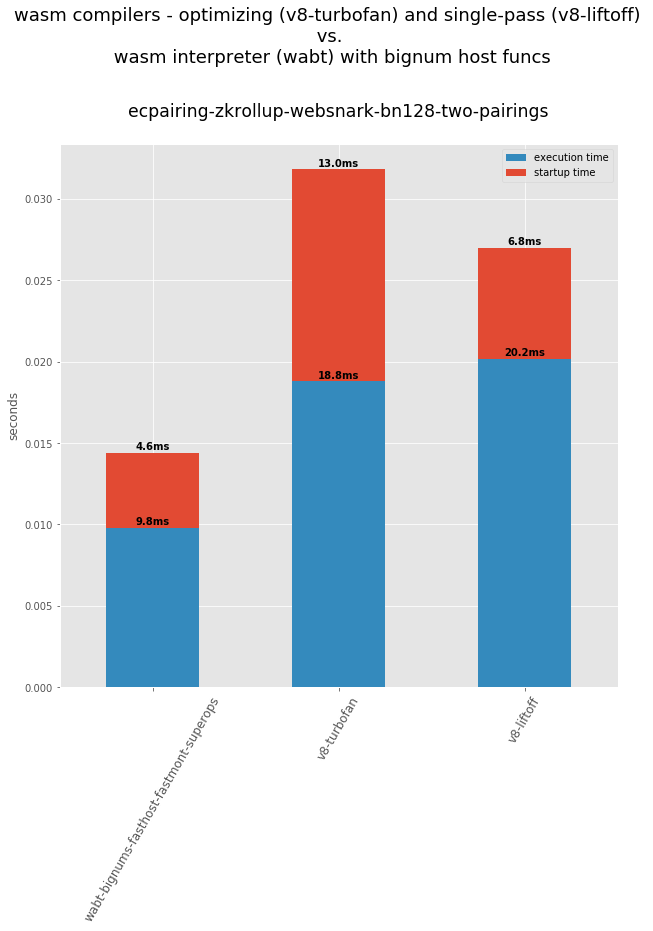

In [68]:
plotScoutStackedTest(df_scout_websnark_zkrollup_means,
            suptitle="wasm compilers - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n wasm interpreter (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')

## Plot bignum benchmark: daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc

In [69]:
df_scout_daiquiri_zkmixer = df_scout_data[df_scout_data['bench_name'] == 'daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc']

df_scout_means_daiquiri_zkmixer = df_scout_daiquiri_zkmixer.groupby(['engine']).mean()
df_scout_fast_daiquiri_zkmixer = filterDfEngines(df_scout_daiquiri_zkmixer,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_daiquiri_zkmixer = df_scout_fast_daiquiri_zkmixer.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

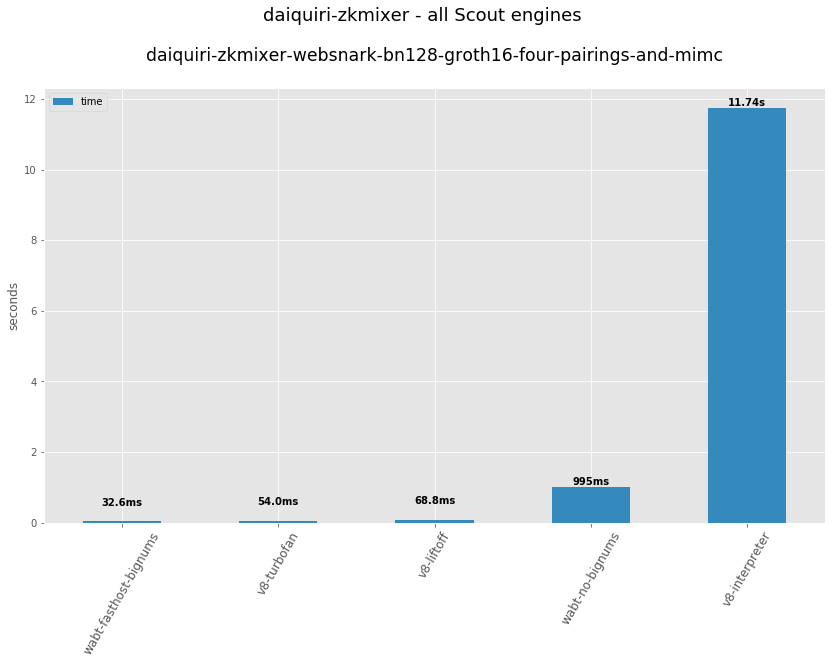

In [70]:
plotOneTest(df_scout_means_daiquiri_zkmixer,
            suptitle="daiquiri-zkmixer - all Scout engines",
            suptitle_pos=1.02,
            subtitle="daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

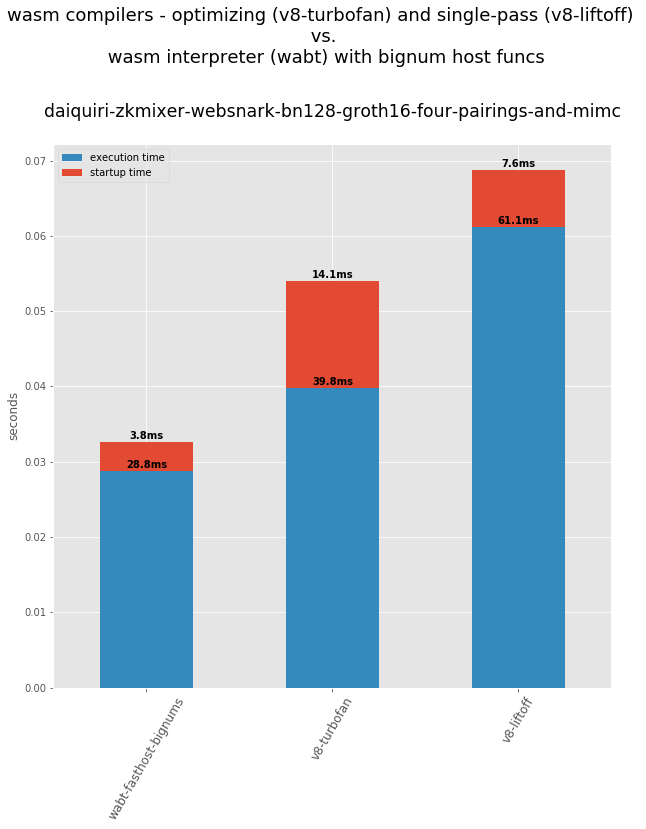

In [71]:
plotScoutStackedTest(df_scout_fast_means_daiquiri_zkmixer,
            suptitle="wasm compilers - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n wasm interpreter (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc\n",
            subtitle_size='xx-large')

## Import geth precompile results

In [72]:
df_geth_precompiles = read_results(join(CSV_RESULT_DIR, GETH_PRECOMPILE_RESULT_FILE))

In [73]:
#df_geth_precompiles

In [74]:
def splitName(test_name):
    ix = test_name.find("/")
    return (test_name[0:ix], test_name[ix+1:])


In [75]:
df_geth_precompiles['precompile_name'], df_geth_precompiles['input_name'] = zip(*df_geth_precompiles.apply(lambda row: splitName(row['test_name']), axis=1))


In [76]:
df_geth_precompiles = df_geth_precompiles[['precompile_name', 'input_name', 'gas', 'time']]

In [77]:
df_geth_native_bn128pairing = df_geth_precompiles[df_geth_precompiles["input_name"] == "two_point_match_rollup_input"].copy()


In [78]:
df_geth_native_bn128pairing

precompile_name                    input_name     gas      time
57  PrecompiledBn256Pairing  two_point_match_rollup_input  113000  0.004205

### Import standalone wasm results

In [79]:
df_wasm = read_results(join(CSV_RESULT_DIR, STANDALONE_WASM_RESULT_FILE))

In [80]:
df_wasm

engine            test_name  elapsed_time  compile_time  exec_time
0      wagon    bn128_mul-chfast2      0.429684      0.162801   0.139014
1      wagon    bn128_mul-chfast2      0.297832      0.154103   0.138632
2      wagon    bn128_mul-chfast2      0.298395      0.159751   0.133284
3      wagon    bn128_mul-chfast2      0.288727      0.144752   0.138264
4      wagon    bn128_mul-chfast2      0.301168      0.152101   0.143702
...      ...                  ...           ...           ...        ...
16330  fizzy  bn128_add-cdetrio14      2.605333      0.000055   0.000652
16331  fizzy  bn128_add-cdetrio14      2.658363      0.000055   0.000677
16332  fizzy  bn128_add-cdetrio14      2.588979      0.000056   0.000654
16333  fizzy  bn128_add-cdetrio14      2.535048      0.000054   0.000656
16334  fizzy  bn128_add-cdetrio14      2.639793      0.000054   0.000688

[16335 rows x 5 columns]

### Import native results

In [81]:
df_native_raw = read_results(join(CSV_RESULT_DIR, NATIVE_RESULT_FILE))

In [82]:
native_results = {}
for i in range(len(df_native_raw)):
    test_name = df_native_raw['test_name'][i]
    native_results[test_name] = df_native_raw['elapsed_times'][i].split(', ')

    
test_names = df_native_raw['test_name'].tolist()

native_times = {}
for test in test_names:
    avg = np.mean([float(t) for t in native_results[test]])
    native_times[test] = avg

    
df_native = pd.DataFrame.from_dict(native_times, orient='index', columns=['elapsed_time'])
df_native['engine'] = 'rust-native'

In [83]:
df_native

elapsed_time       engine
blake2b-8415-bytes                           0.000026  rust-native
blake2b-5610-bytes                           0.000012  rust-native
blake2b-2805-bytes                           0.000008  rust-native
bls12-381-aggreg-128-pubkeys-verify-sig      0.027138  rust-native
bls12-381-aggreg-64-pubkeys-verify-sig       0.028107  rust-native
bls12-381-aggreg-32-pubkeys-verify-sig       0.024123  rust-native
bn128_pairing-ten_point_match_1              0.021701  rust-native
bn128_pairing-one_point                      0.006033  rust-native
bn128_pairing-two_point_match_2              0.010407  rust-native
sha1-10808-bits                              0.000007  rust-native
sha1-21896-bits                              0.000009  rust-native
sha1-42488-bits                              0.000015  rust-native
bn128_add-cdetrio11                          0.000016  rust-native
bn128_add-cdetrio14                          0.000005  rust-native
bn128_add-cdetrio10                          0.000002  rust-native
ed25519-verify-ten-inputs                    0.001019  rust-native
modexp-nagydani-1-qube                       0.000023  rust-native
modexp-nagydani-1-square                     0.000020  rust-native
modexp-eip_example1                          0.000234  rust-native
bn128_mul-cdetrio11                          0.000396  rust-native
bn128_mul-chfast2                            0.000202  rust-native
bn128_mul-chfast1                            0.000256  rust-native
bn128_mul-chfast3                            0.000630  rust-native
bn128_mul-cdetrio2                           0.000402  rust-native
bn128_mul-cdetrio6                           0.000487  rust-native
bn128_mul-cdetrio7                           0.000319  rust-native
bn128_mul-cdetrio12                          0.000368  rust-native

### sorted lists of test names for plotting inputs in order

In [84]:
blake2b_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'blake2b' in name]
blake2b_test_names.sort()
blake2b_test_names_desc = blake2b_test_names.copy()
blake2b_test_names_desc.reverse()


In [85]:
sha1_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'sha1' in name]
sha1_test_names.sort()
sha1_test_names_desc = sha1_test_names.copy()
sha1_test_names_desc.reverse()


In [86]:

bn128_mul_test_names = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']

bn128_mul_test_names.reverse()
bn128_add_test_names.reverse()
bn128_pairing_test_names.reverse()

bn128_mul_test_names_desc = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names_desc = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names_desc = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']



In [87]:
bls12_test_names = ['bls12-381-aggreg-32-pubkeys-verify-sig', 'bls12-381-aggreg-64-pubkeys-verify-sig', 'bls12-381-aggreg-128-pubkeys-verify-sig']
bls12_test_names_desc = bls12_test_names.copy()
bls12_test_names_desc.reverse()

In [88]:
modexp_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'modexp' in name]
modexp_test_names.sort()
modexp_test_names_desc = modexp_test_names.copy()
modexp_test_names_desc.reverse()

In [89]:
all_tests = sha1_test_names + blake2b_test_names + modexp_test_names + ['ed25519-verify-ten-inputs'] + bls12_test_names \
    + bn128_add_test_names + bn128_mul_test_names + bn128_pairing_test_names

### Prepare interpreter dataframe

In [90]:
all_interp_test_names = []

interp_results_for_df = []
for engine in INTERPRETER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    all_interp_test_names.extend(test_names)
    for test_name in test_names:
        interp_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())

        
all_interp_test_names = set(all_interp_test_names)

#interp_results_for_df

df_interp = pd.DataFrame(interp_results_for_df)
df_interp.columns = ['engine', 'test_name', 'elapsed_time', 'parse_time', 'exec_time']
df_interp.set_index('engine', inplace=True)
df_interp['total_time'] = df_interp['parse_time'] + df_interp['exec_time']
#df_interp

In [91]:
df_wasm['test_name'].unique().tolist()

['bn128_mul-chfast2',
 'bn128_add-cdetrio11',
 'sha1-42488-bits',
 'ecpairing',
 'bn128_mul-chfast3',
 'mul256-gcolvin-drag-race',
 'bn128_mul-cdetrio11',
 'sha1-10808-bits',
 'bn128_pairing-ten_point_match_1',
 'modexp-nagydani-1-square',
 'bn128_pairing-one_point',
 'bn128_mul-cdetrio12',
 'bls12-381-aggreg-128-pubkeys-verify-sig',
 'modexp-nagydani-1-qube',
 'ed25519-verify-ten-inputs',
 'bls12-381-aggreg-64-pubkeys-verify-sig',
 'blake2b-5610-bytes',
 'bn128_add-cdetrio10',
 'bn128_mul-cdetrio6',
 'bn128_mul-cdetrio7',
 'modexp-eip_example1',
 'bn128_pairing-two_point_match_2',
 'bn128_mul-chfast1',
 'bls12-381-aggreg-32-pubkeys-verify-sig',
 'blake2b-2805-bytes',
 'sha1-21896-bits',
 'bn128_mul-cdetrio2',
 'blake2b-8415-bytes',
 'bn128_add-cdetrio14',
 'guido-fuzzer-find-2',
 'guido-fuzzer-find-2-norotates',
 'guido-fuzzer-find-1']

## Interpreter engines compared

In [92]:
def plotInterpThreeTests(df_testdata, three_names, title="Title", filter_engines=None):
    if filter_engines is not None:
        df_testdata = filterDfEngines(df_testdata.reset_index(), filter_engines)
        df_testdata.set_index('engine', inplace=True)
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[0], stacked=True)
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[1], stacked=True)
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[2], stacked=True)
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["startup time", "execution time"])
    ax1[1].legend(labels=["startup time", "execution time"])
    ax1[2].legend(labels=["startup time", "execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
    
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()

<Figure size 432x288 with 0 Axes>

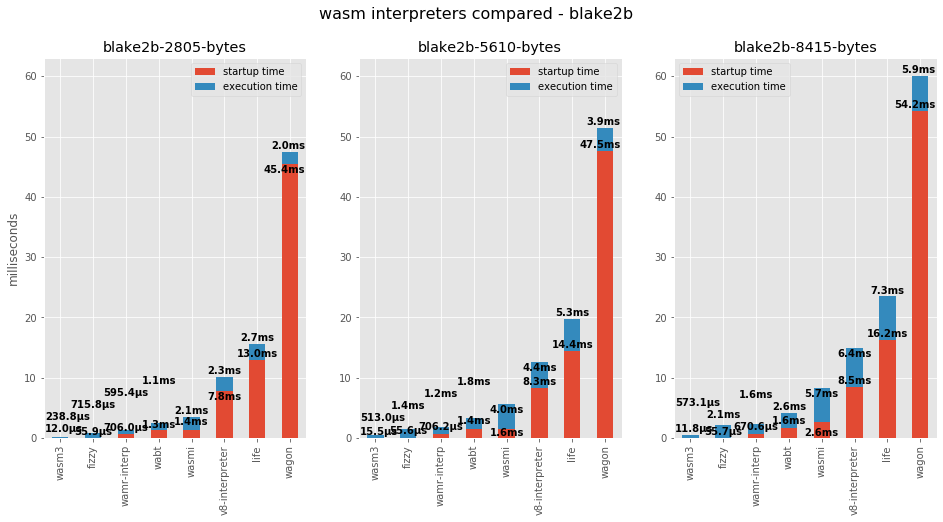

In [93]:
plotInterpThreeTests(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

### Interpreters - Execution time

In [94]:
def plotThreeTestsExecTime(df_testdata, three_names, title="Title", filter_engines=None):
    if filter_engines is not None:
        df_testdata = filterDfEngines(df_testdata.reset_index(), filter_engines)
        df_testdata.set_index('engine', inplace=True)
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[2], color=COLORS_DEFAULT['blue'])
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["execution time"])
    ax1[1].legend(labels=["execution time"])
    ax1[2].legend(labels=["execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
   
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


<Figure size 432x288 with 0 Axes>

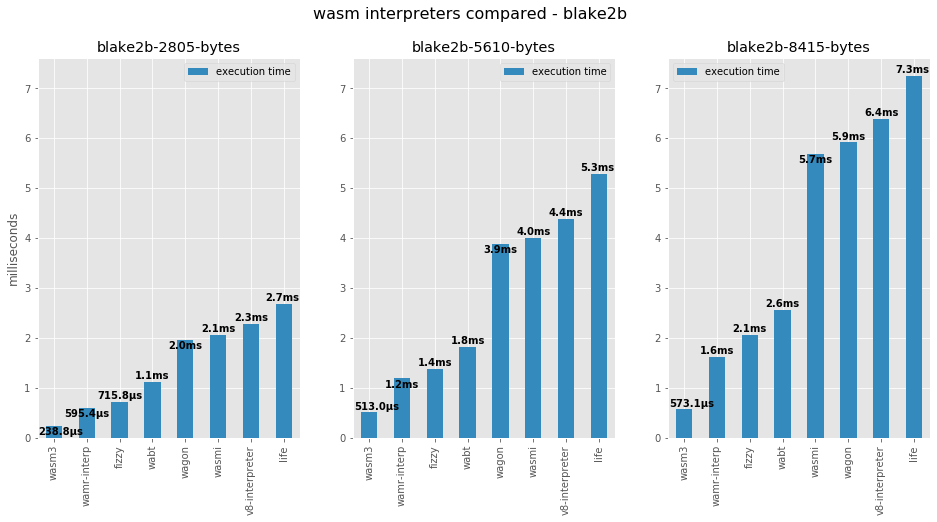

In [95]:
plotThreeTestsExecTime(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

## Chart of only the fast interpreters

<Figure size 432x288 with 0 Axes>

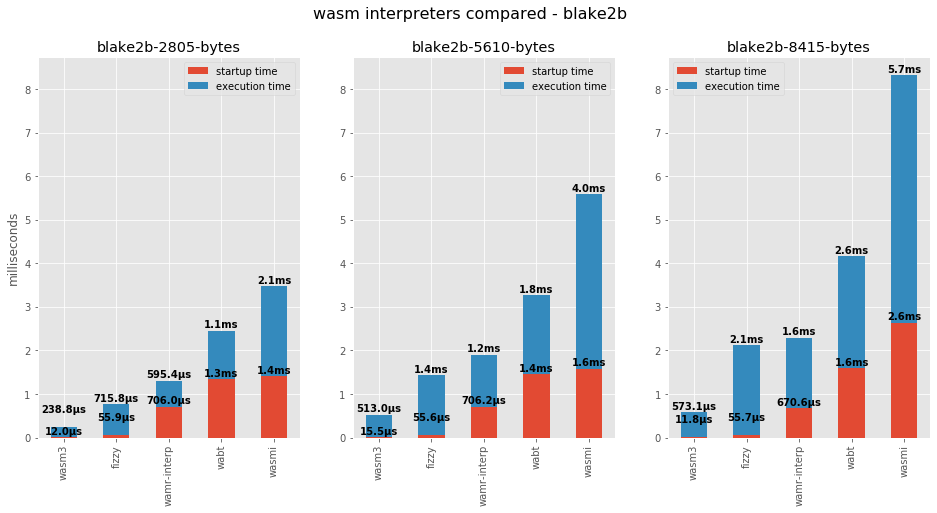

In [96]:
plotInterpThreeTests(df_interp,
                     blake2b_test_names,
                     title="wasm interpreters compared - blake2b",
                     filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

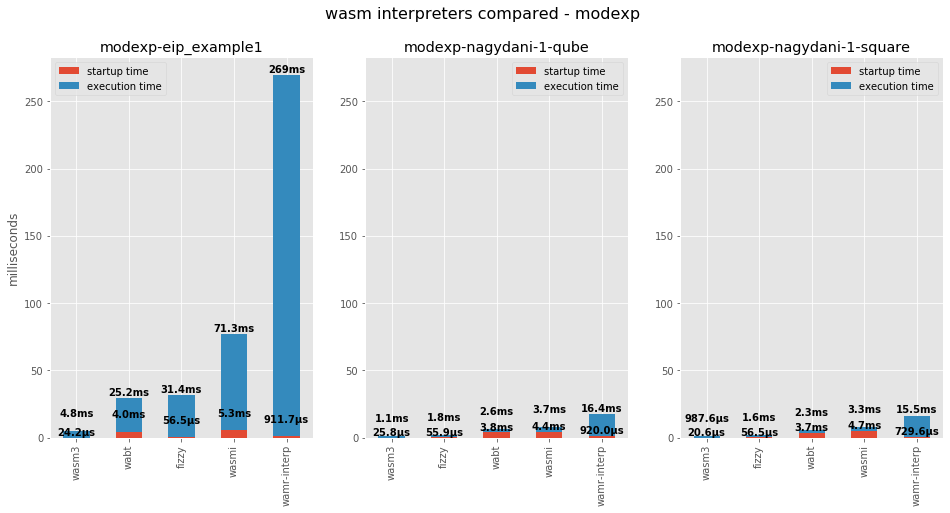

In [97]:
plotInterpThreeTests(df_interp,
                     modexp_test_names,
                     title="wasm interpreters compared - modexp",
                     filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

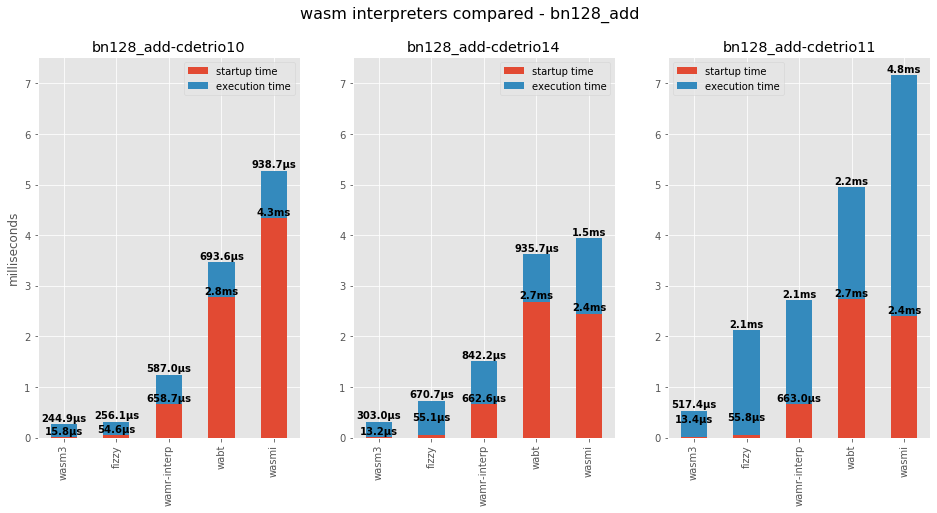

In [98]:
plotInterpThreeTests(df_interp,
                     bn128_add_test_names,
                     title="wasm interpreters compared - bn128_add",
                     filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

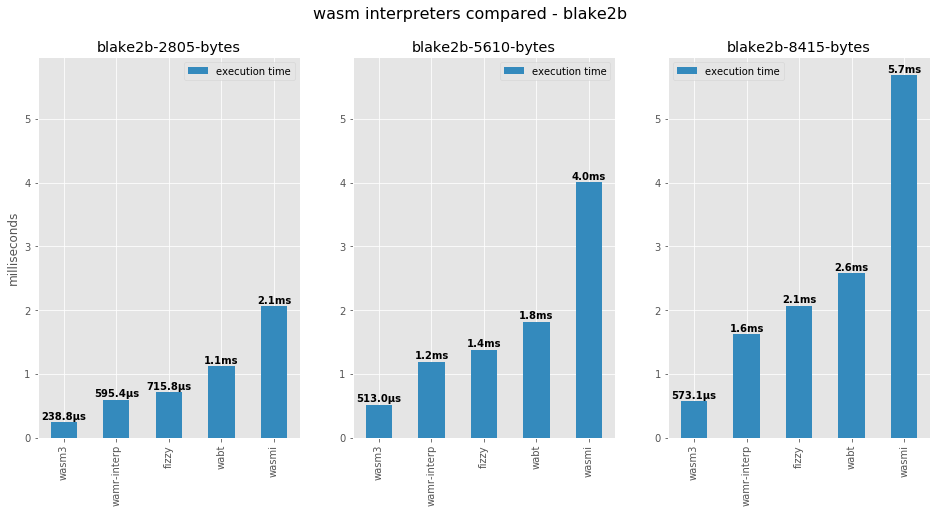

In [99]:
plotThreeTestsExecTime(df_interp,
                       blake2b_test_names,
                       title="wasm interpreters compared - blake2b",
                       filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

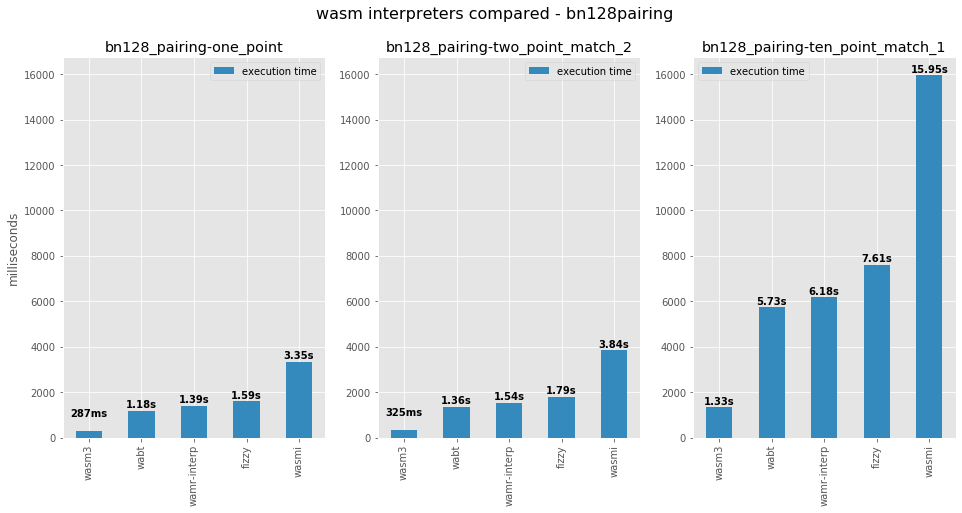

In [100]:
plotThreeTestsExecTime(df_interp,
                       bn128_pairing_test_names,
                       title="wasm interpreters compared - bn128pairing",
                       filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

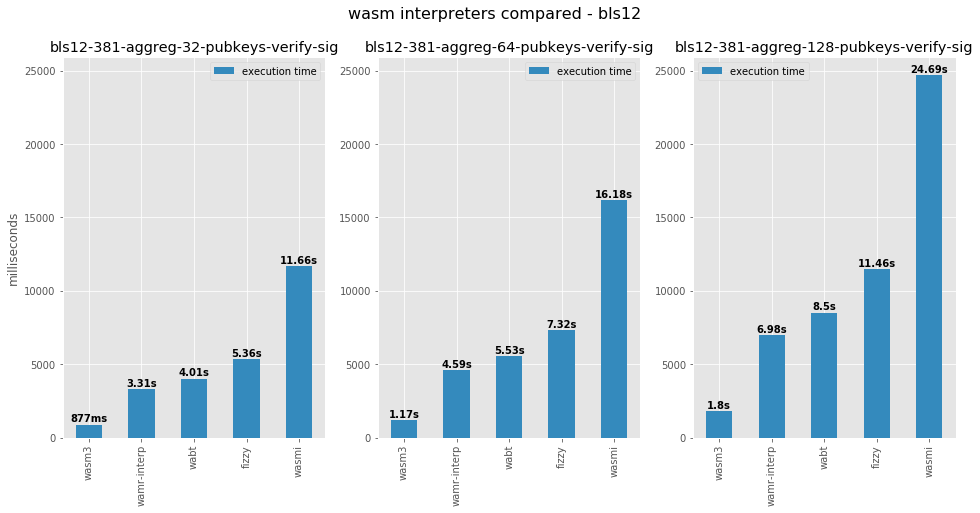

In [101]:
plotThreeTestsExecTime(df_interp,
                       bls12_test_names,
                       title="wasm interpreters compared - bls12",
                       filter_engines=["life", "wagon", "v8-interpreter"])

## Compiler Results

In [102]:
compiler_results_for_df = []
for engine in COMPILER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    for test_name in test_names:
        compiler_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())




In [103]:
df_compiler = pd.DataFrame(compiler_results_for_df)

df_compiler.columns = ['engine', 'test_name', 'elapsed_time', 'compile_time', 'exec_time']
df_compiler.set_index('engine', inplace=True)
df_compiler['total_time'] = df_compiler['compile_time'] + df_compiler['exec_time']

#df_compiler

## JIT bomb chart

In [104]:
df_compiler

test_name  elapsed_time  \
engine                                                               
wasmtime                           bn128_mul-chfast2      0.755141   
wasmtime                         bn128_add-cdetrio11      0.477859   
wasmtime                             sha1-42488-bits      0.153981   
wasmtime                                   ecpairing      1.055279   
wasmtime                           bn128_mul-chfast3      0.761303   
wasmtime                    mul256-gcolvin-drag-race      0.927951   
wasmtime                         bn128_mul-cdetrio11      0.769527   
wasmtime                             sha1-10808-bits      0.057305   
wasmtime             bn128_pairing-ten_point_match_1      9.181844   
wasmtime                    modexp-nagydani-1-square      0.369230   
wasmtime                     bn128_pairing-one_point      8.596796   
wasmtime                         bn128_mul-cdetrio12      0.764867   
wasmtime     bls12-381-aggreg-128-pubkeys-verify-sig     16.906798   
wasmtime                      modexp-nagydani-1-qube      0.369306   
wasmtime                   ed25519-verify-ten-inputs      1.704230   
wasmtime      bls12-381-aggreg-64-pubkeys-verify-sig     16.246132   
wasmtime                          blake2b-5610-bytes      0.179345   
wasmtime                         bn128_add-cdetrio10      0.471315   
wasmtime                          bn128_mul-cdetrio6      0.753445   
wasmtime                          bn128_mul-cdetrio7      0.750621   
wasmtime                         modexp-eip_example1      0.377240   
wasmtime             bn128_pairing-two_point_match_2      8.635667   
wasmtime                           bn128_mul-chfast1      0.748932   
wasmtime      bls12-381-aggreg-32-pubkeys-verify-sig     16.018409   
wasmtime                          blake2b-2805-bytes      0.106280   
wasmtime                             sha1-21896-bits      0.080246   
wasmtime                          bn128_mul-cdetrio2      0.750490   
wasmtime                          blake2b-8415-bytes      0.309384   
wasmtime                         bn128_add-cdetrio14      0.481168   
wavm                               bn128_mul-chfast2      0.767007   
wavm                             bn128_add-cdetrio11      0.570065   
wavm                                 sha1-42488-bits      0.217625   
wavm                                       ecpairing      1.577890   
wavm                               bn128_mul-chfast3      0.736219   
wavm                        mul256-gcolvin-drag-race      0.760451   
wavm                             bn128_mul-cdetrio11      0.746001   
wavm                                 sha1-10808-bits      0.183952   
wavm                 bn128_pairing-ten_point_match_1      4.780828   
wavm                        modexp-nagydani-1-square      1.491443   
wavm                         bn128_pairing-one_point      4.680002   
wavm                             bn128_mul-cdetrio12      0.744509   
wavm         bls12-381-aggreg-128-pubkeys-verify-sig      3.966835   
wavm                          modexp-nagydani-1-qube      1.489914   
wavm                       ed25519-verify-ten-inputs      2.964967   
wavm          bls12-381-aggreg-64-pubkeys-verify-sig      3.861084   
wavm                             guido-fuzzer-find-2      0.049981   
wavm                              blake2b-5610-bytes      0.291364   
wavm                             bn128_add-cdetrio10      0.564534   
wavm                   guido-fuzzer-find-2-norotates      0.053204   
wavm                              bn128_mul-cdetrio6      0.734865   
wavm                              bn128_mul-cdetrio7      0.730948   
wavm                             modexp-eip_example1      1.474437   
wavm                 bn128_pairing-two_point_match_2      4.630682   
wavm                               bn128_mul-chfast1      0.733883   
wavm          bls12-381-aggreg-32-pubkeys-verify-sig      3.788655   
wavm                              blake2b-2805-bytes 

In [105]:
df_compiler[df_compiler['test_name'].str.contains('guido')]

test_name  elapsed_time  compile_time  \
engine                                                                   
wavm                   guido-fuzzer-find-2      0.049981      0.034274   
wavm         guido-fuzzer-find-2-norotates      0.053204      0.035151   
wavm                   guido-fuzzer-find-1      0.043474      0.028564   
v8-liftoff             guido-fuzzer-find-2      1.643853      1.558885   
v8-liftoff   guido-fuzzer-find-2-norotates      0.083195      0.001876   
v8-liftoff             guido-fuzzer-find-1      0.086395      0.001931   
v8-turbofan            guido-fuzzer-find-2      1.743409      1.658731   
v8-turbofan  guido-fuzzer-find-2-norotates      1.705984      1.620685   
v8-turbofan            guido-fuzzer-find-1      0.754537      0.669946   
wamr-jit               guido-fuzzer-find-2      0.019670      0.000725   
wamr-jit     guido-fuzzer-find-2-norotates      0.019380      0.000687   
wamr-aot               guido-fuzzer-find-2      0.023525      0.002793   
wamr-aot     guido-fuzzer-find-2-norotates      0.022887      0.002628   

             exec_time  total_time  
engine                              
wavm          0.000784    0.035058  
wavm          0.002656    0.037807  
wavm          0.000254    0.028817  
v8-liftoff    0.000086    1.558971  
v8-liftoff    0.000086    0.001962  
v8-liftoff    0.000093    0.002024  
v8-turbofan   0.000084    1.658815  
v8-turbofan   0.000089    1.620774  
v8-turbofan   0.000085    0.670031  
wamr-jit      0.000001    0.000726  
wamr-jit      0.000047    0.000734  
wamr-aot      0.000002    0.002795  
wamr-aot      0.000050    0.002678

In [106]:
def plotCompilerJITBombOneTest(df_benchdata, test_name):
    df_1 = df_benchdata[df_benchdata['test_name'] == test_name]
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_1[['exec_time', 'compile_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    ax.set_title("Compilers - {}".format(test_name))
    df_total_times = df_1[['exec_time', 'compile_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['compile_time']
    ymax = max(df_total_times[['total_time']].max()) * 1.3 # 30% larger for padding between top of bars and top of graph
    ymin = min([x for x in df_1[['exec_time', 'compile_time']].min().tolist() if x > 0])
    ymin = ymin * 0.8 # 0.8 to get a number 20% smaller, fix to make bar appear for smallest exec time
    ax.set_ylim(ymin, ymax)
    #ax.set_yscale("log")
    plt.ylabel("seconds (log scale)")
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "compile time"])
    #plt.savefig("../images/wasm-compilers.png")
    plt.show()


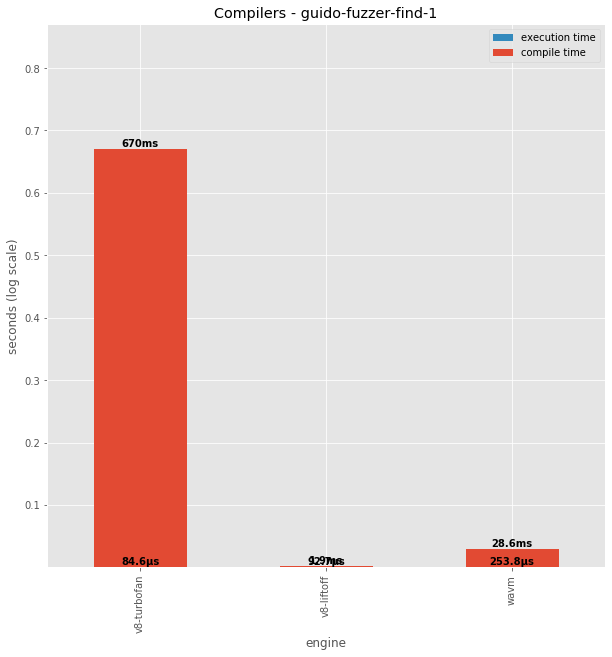

In [107]:
plotCompilerJITBombOneTest(df_compiler, "guido-fuzzer-find-1")

In [108]:
#plotCompilerStackedOneTest(df_compiler, "guido-fuzzer-find-1")

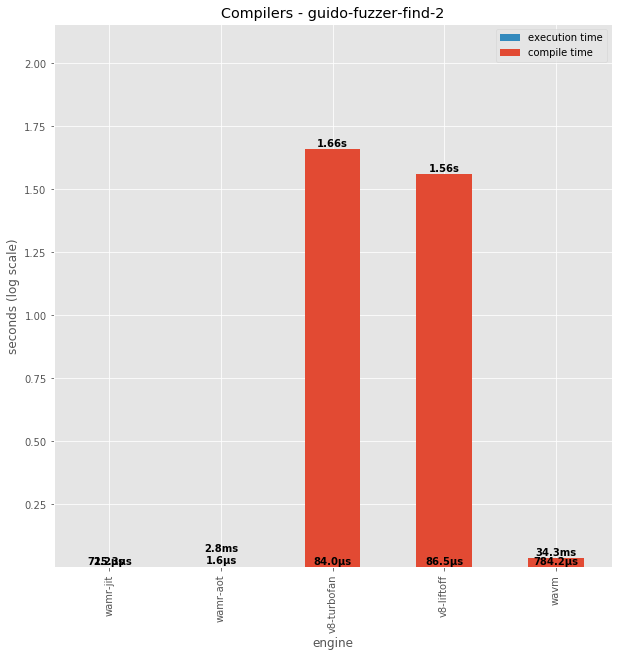

In [109]:
plotCompilerJITBombOneTest(df_compiler, "guido-fuzzer-find-2")

In [110]:
#plotCompilerStackedOneTest(df_compiler, "guido-fuzzer-find-2")

In [111]:
df_jitbomb_1 = df_compiler[df_compiler['test_name'] == 'guido-fuzzer-find-1'].copy()

In [112]:
df_jitbomb_1

test_name  elapsed_time  compile_time  exec_time  \
engine                                                                    
wavm         guido-fuzzer-find-1      0.043474      0.028564   0.000254   
v8-liftoff   guido-fuzzer-find-1      0.086395      0.001931   0.000093   
v8-turbofan  guido-fuzzer-find-1      0.754537      0.669946   0.000085   

             total_time  
engine                   
wavm           0.028817  
v8-liftoff     0.002024  
v8-turbofan    0.670031

In [113]:
df_jitbomb_1.drop(['elapsed_time'],axis=1,inplace=True)

In [114]:
df_jitbomb_1.drop(['total_time'],axis=1,inplace=True)

In [115]:
df_jitbomb_1

test_name  compile_time  exec_time
engine                                                   
wavm         guido-fuzzer-find-1      0.028564   0.000254
v8-liftoff   guido-fuzzer-find-1      0.001931   0.000093
v8-turbofan  guido-fuzzer-find-1      0.669946   0.000085

In [116]:
df_jitbomb_1.reset_index(inplace=True)

In [117]:
df_jitbomb_1.melt(id_vars=["engine", "test_name"], var_name="exec_or_compile")

engine            test_name exec_or_compile     value
0         wavm  guido-fuzzer-find-1    compile_time  0.028564
1   v8-liftoff  guido-fuzzer-find-1    compile_time  0.001931
2  v8-turbofan  guido-fuzzer-find-1    compile_time  0.669946
3         wavm  guido-fuzzer-find-1       exec_time  0.000254
4   v8-liftoff  guido-fuzzer-find-1       exec_time  0.000093
5  v8-turbofan  guido-fuzzer-find-1       exec_time  0.000085

In [118]:
df_jitbomb_1 = df_jitbomb_1.melt(id_vars=["engine", "test_name"], var_name="exec_or_compile")

Text(0.5, 0.95, 'JIT bomb guido-fuzzer-find-1')

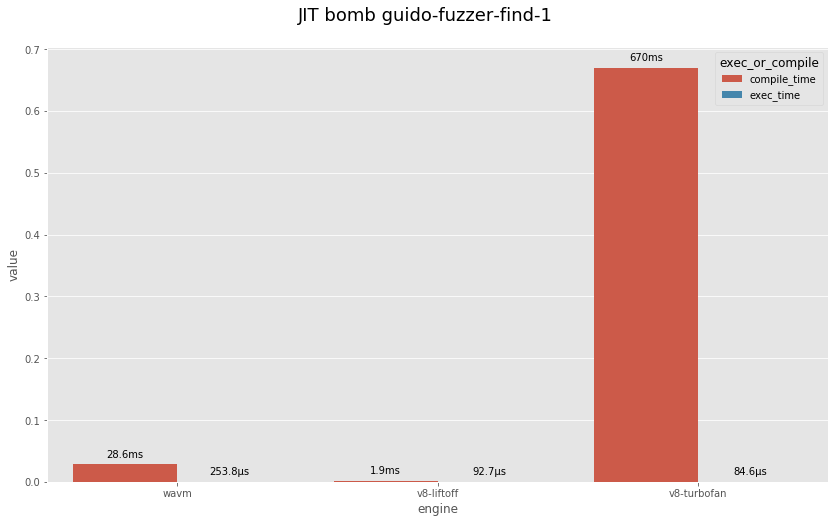

In [119]:
f = plt.figure(figsize=(14,8))

bombplot = sns.barplot(x='engine', y='value', hue='exec_or_compile', dodge=True, data=df_jitbomb_1)
#bombplot.set(yscale="log")


# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in bombplot.patches:
    bombplot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

#bombplot.set_xticklabels(bombplot.get_xticklabels(), size = 14)

f.suptitle("JIT bomb guido-fuzzer-find-1", fontsize=18, y=0.95)

Text(0.5, 0.95, 'JIT bomb guido-fuzzer-find-1 - log scale')

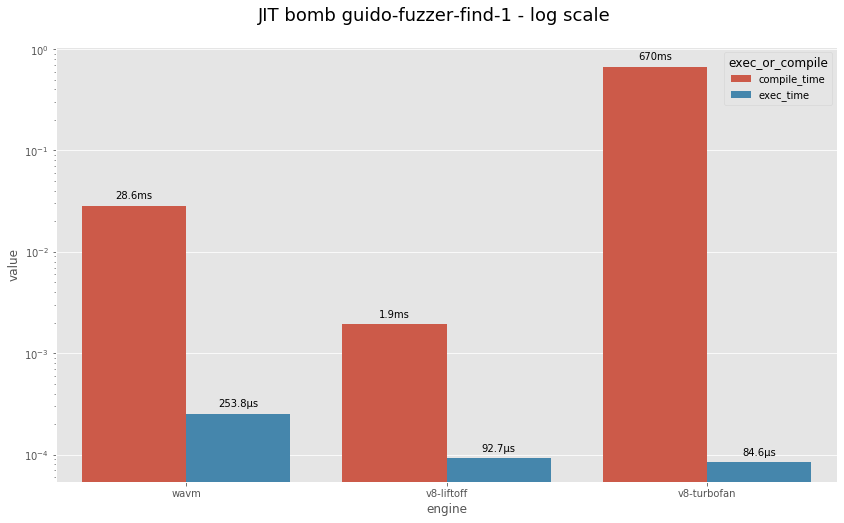

In [120]:
f = plt.figure(figsize=(14,8))

bombplot = sns.barplot(x='engine', y='value', hue='exec_or_compile', dodge=True, data=df_jitbomb_1)
bombplot.set(yscale="log")

for p in bombplot.patches:
    bombplot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

f.suptitle("JIT bomb guido-fuzzer-find-1 - log scale", fontsize=18, y=0.95)

## guido-fuzzer-find-2

In [121]:
df_jitbomb_2 = df_compiler[df_compiler['test_name'] == 'guido-fuzzer-find-2'].copy()

df_jitbomb_2.drop(['elapsed_time'],axis=1,inplace=True)
df_jitbomb_2.drop(['total_time'],axis=1,inplace=True)
df_jitbomb_2.reset_index(inplace=True)

df_jitbomb_2 = df_jitbomb_2.melt(id_vars=["engine", "test_name"], var_name="exec_or_compile")


Text(0.5, 0.95, 'JIT bomb guido-fuzzer-find-2')

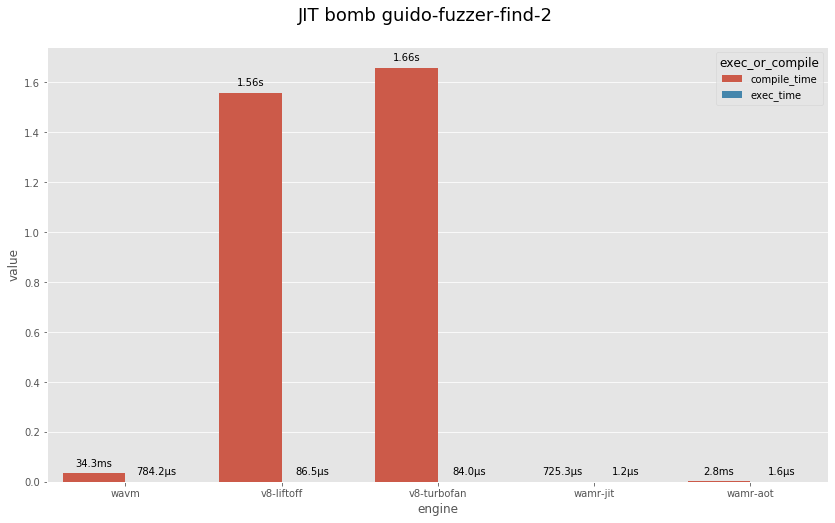

In [122]:
f = plt.figure(figsize=(14,8))

bombplot = sns.barplot(x='engine', y='value', hue='exec_or_compile', dodge=True, data=df_jitbomb_2)
#bombplot.set(yscale="log")

# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in bombplot.patches:
    bombplot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

f.suptitle("JIT bomb guido-fuzzer-find-2", fontsize=18, y=0.95)

Text(0.5, 0.95, 'JIT bomb guido-fuzzer-find-2 (log scale)')

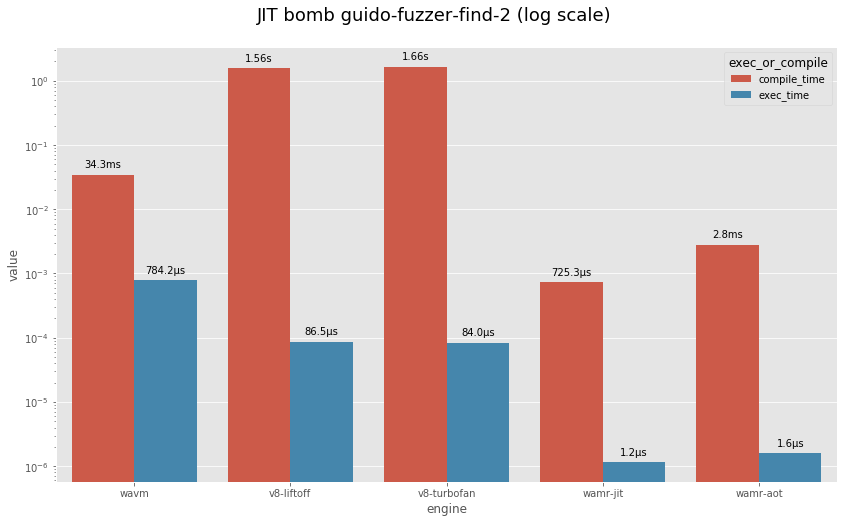

In [123]:
f = plt.figure(figsize=(14,8))

bombplot = sns.barplot(x='engine', y='value', hue='exec_or_compile', dodge=True, data=df_jitbomb_2)
bombplot.set(yscale="log")

# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in bombplot.patches:
    bombplot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

f.suptitle("JIT bomb guido-fuzzer-find-2 (log scale)", fontsize=18, y=0.95)

## Compiler function

*Note: Fix scale for v8-turbofan execution time*

In [124]:
def plotCompilerStackedOneTest(df_benchdata, test_name):
    df_1 = df_benchdata[df_benchdata['test_name'] == test_name]
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_1[['exec_time', 'compile_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    ax.set_title("Compilers - {}".format(test_name))
    df_total_times = df_1[['exec_time', 'compile_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['compile_time']
    ymax = max(df_total_times[['total_time']].max()) * 1.3 # 30% larger for padding between top of bars and top of graph
    ymin = min([x for x in df_1[['exec_time', 'compile_time']].min().tolist() if x > 0])
    ymin = ymin * 0.8 # 0.8 to get a number 20% smaller, fix to make bar appear for smallest exec time
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    plt.ylabel("seconds (log scale)")
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "compile time"])
    #plt.savefig("../images/wasm-compilers.png")
    plt.show()


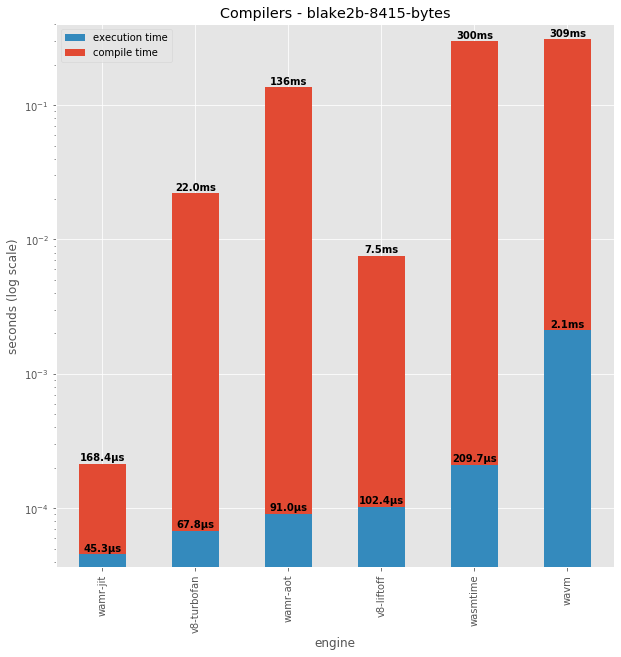

In [125]:
plotCompilerStackedOneTest(df_compiler, "blake2b-8415-bytes")

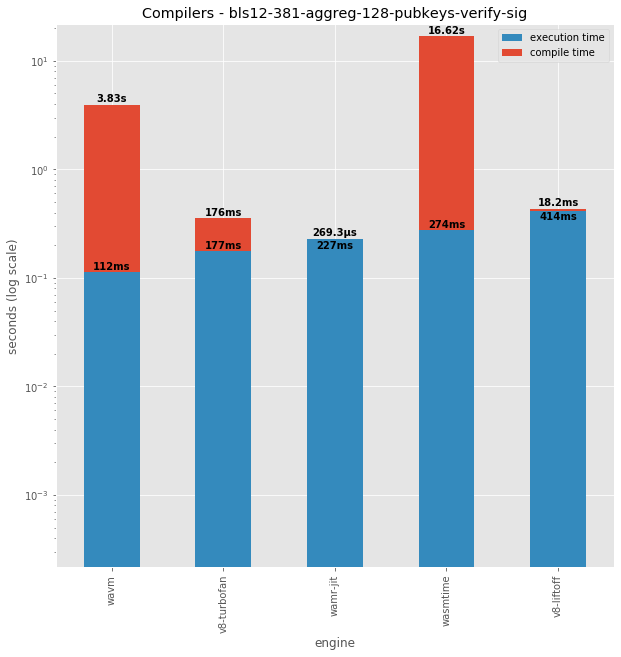

In [126]:
plotCompilerStackedOneTest(df_compiler, "bls12-381-aggreg-128-pubkeys-verify-sig")

## Add rust-native to compiler engines chart

In [127]:
# merge df_native and df_compiler into one dataframe
# both dataframes must have same columns to merge them:
# engine, test_name, elapsed_time, compile_time, exec_time, total_time

df_native_merge = df_native.copy()
df_native_merge.reset_index(inplace=True)
df_native_merge.columns = ['test_name', 'elapsed_time', 'engine']
df_native_merge['compile_time'] = 0
df_native_merge['exec_time'] = df_native_merge['elapsed_time']
df_native_merge['total_time'] = df_native_merge['elapsed_time']
df_native_and_compile = pd.concat([df_compiler.reset_index(), df_native_merge], sort=False)
df_native_and_compile.reset_index(drop=True, inplace=True)
df_native_and_compile.set_index('engine', inplace=True)


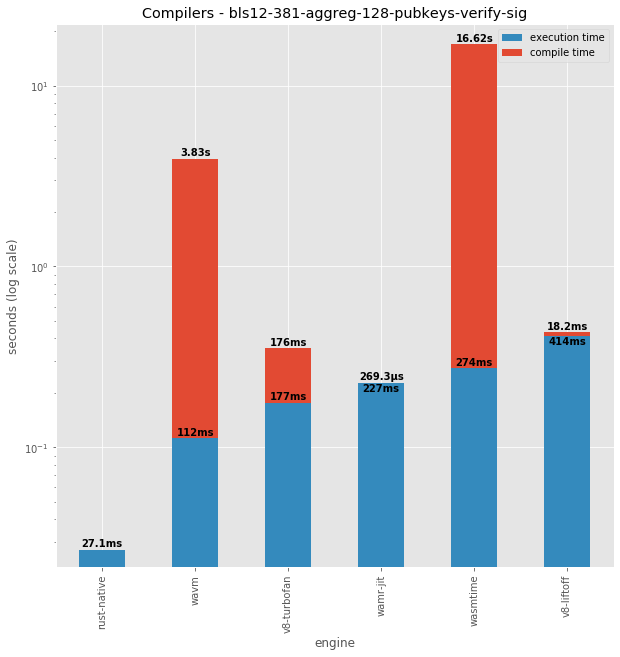

In [128]:
plotCompilerStackedOneTest(df_native_and_compile, "bls12-381-aggreg-128-pubkeys-verify-sig")

## Interpreter vs Compiler speedup

In [129]:
# merge df_compiler and df_interp
df_interp_merge = df_interp.copy()
df_interp_merge.columns = ['test_name', 'elapsed_time', 'compile_time', 'exec_time', 'total_time']
df_interp_and_compile = pd.concat([df_interp_merge, df_compiler])
df_interp_and_compile = df_interp_and_compile.reset_index()

In [130]:
def add_engine_ratio_col(df_two_engines, interp_engine, compiler_engine):
    df_two = df_two_engines.copy(deep=True)
    df_interp = df_two[df_two['engine'] == interp_engine].copy()
    df_compile = df_two[df_two['engine'] == compiler_engine]
    for index, row in df_interp.iterrows():
        test_name = row['test_name']
        row_compiler = df_compile[df_compile['test_name'] == test_name]
        if len(row_compiler) != 1:
            print("ERROR. SHOULD HAVE 1 MATCH ONLY")
            break
        compiler_exec_time = row_compiler.iloc[0]['exec_time']
        exec_ratio = row['exec_time'] / compiler_exec_time
        df_interp.at[index, 'compiler_exec_time'] = compiler_exec_time
        df_interp.at[index, 'interp_slowdown'] = exec_ratio

    return df_interp

In [131]:
df_wabt_v8liftoff = add_engine_ratio_col(df_interp_and_compile, "wabt", "v8-liftoff")

In [132]:
def plotCompilerSpeedup(df_compiler_speedup, interp_name="interp", compiler_name="compiler"):
    df_is = df_compiler_speedup.copy()
    plot_tests = df_is['test_name'].tolist()
    test_index = all_tests.copy()
    for test_name in all_tests:
        if test_name not in plot_tests:
            test_index.remove(test_name)
 
    df_is = df_is.set_index('test_name')
    df_is = df_is.reindex(test_index)
    plt.figure()
    ax = df_is['interp_slowdown'].plot.bar(figsize=(13,7), color=COLORS_DEFAULT['blue'])
    ax.set_title("{} (Interpreter) vs {} (Compiler) - speedup".format(interp_name, compiler_name))
    ax.set(ylabel="compiler speedup (log scale)", xlabel="")

    y_max = ax.get_ylim()[1]
    y_max = y_max * 5 # padding between top of bars and legend
    ax.set_yscale('log')
    ax.set_ylim(0.1, y_max) # adjustment to move horizontal line higher on chart

    adjust_text_labels(labelBarHeights(ax, to_ms=False, to_factor=1, lower_y_bound=False))

    plt.axhline(y=1.0, linewidth=2, ls='--', color='r')

    handles, _ = ax.get_legend_handles_labels()

    plt.legend(labels=["compiler engine is faster (ratio > 1x)", "compiler speedup \n (ratio: interp_exec_time/compiler_exec_time)"])

    #f.suptitle(title, fontsize=16, y=0.95)
    plt.show()


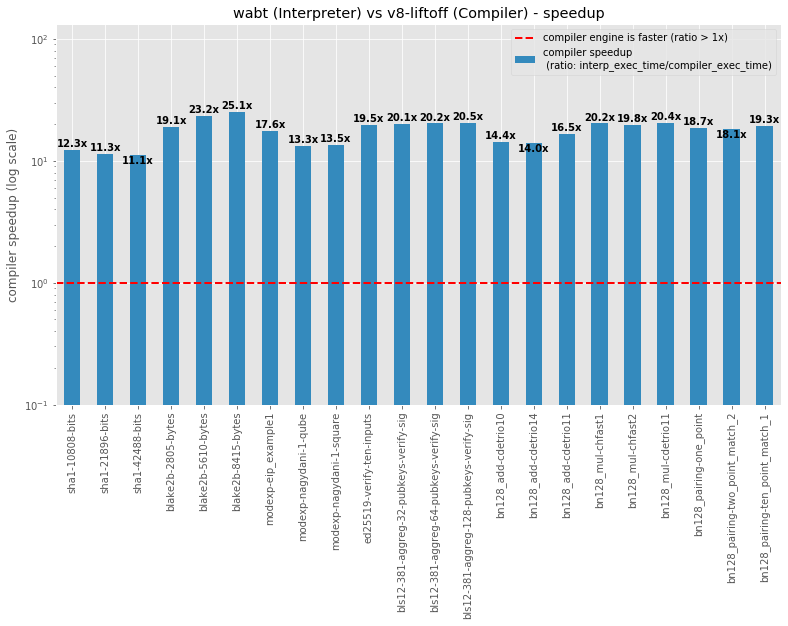

In [133]:
plotCompilerSpeedup(df_wabt_v8liftoff, interp_name="wabt", compiler_name="v8-liftoff")

## All precompiles compared (are interpreters feasible?)

In [134]:
def plotInterpOneEngine(df_benchdata, engine, test_names, title=""):
    df_bench = df_benchdata.loc[engine][df_benchdata.loc[engine]['test_name'].isin(test_names)]
    df_bench.set_index('test_name', inplace=True)
    df_bench = df_bench.reindex(test_names)
    plt.figure()
    ax = df_bench[['parse_time', 'exec_time']].plot.bar(stacked=True, figsize=(15,7), color=[COLORS_DEFAULT['red'], COLORS_DEFAULT['blue']])
    plt.ylabel("seconds")
    ax.set(xlabel='')
    # doing get_legend_handles_labels() so we can control the order of the labels in the legend 
    handles, labels = ax.get_legend_handles_labels()
    plt.legend([handles[1], handles[0]], ['execution time (top bar/label)', 'startup time (bottom bar/label - bar not visible for times < 20.0ms)'])
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(title, fontsize=16, y=0.95)
    plt.show()

<Figure size 432x288 with 0 Axes>

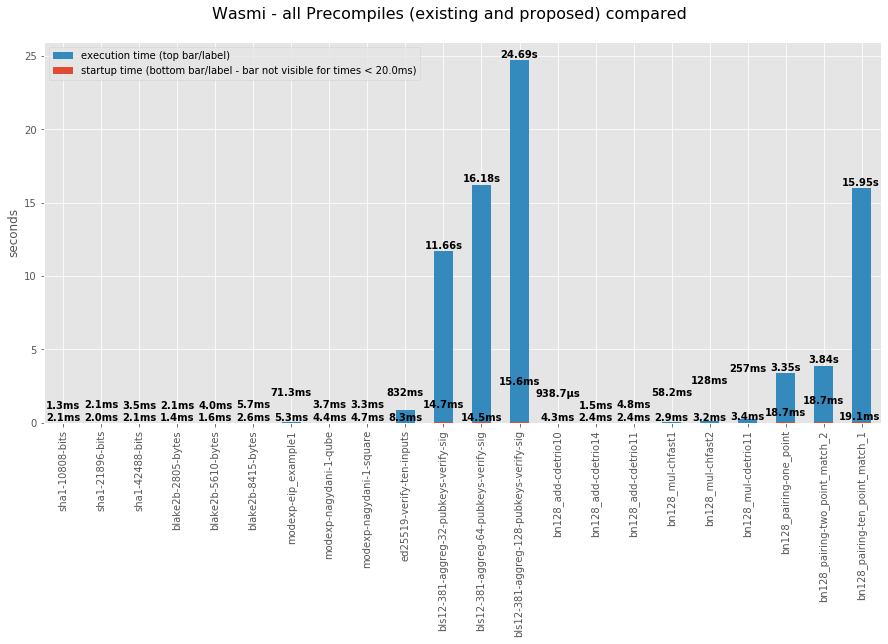

In [135]:
plotInterpOneEngine(df_interp, 'wasmi', all_tests, "Wasmi - all Precompiles (existing and proposed) compared")

<Figure size 432x288 with 0 Axes>

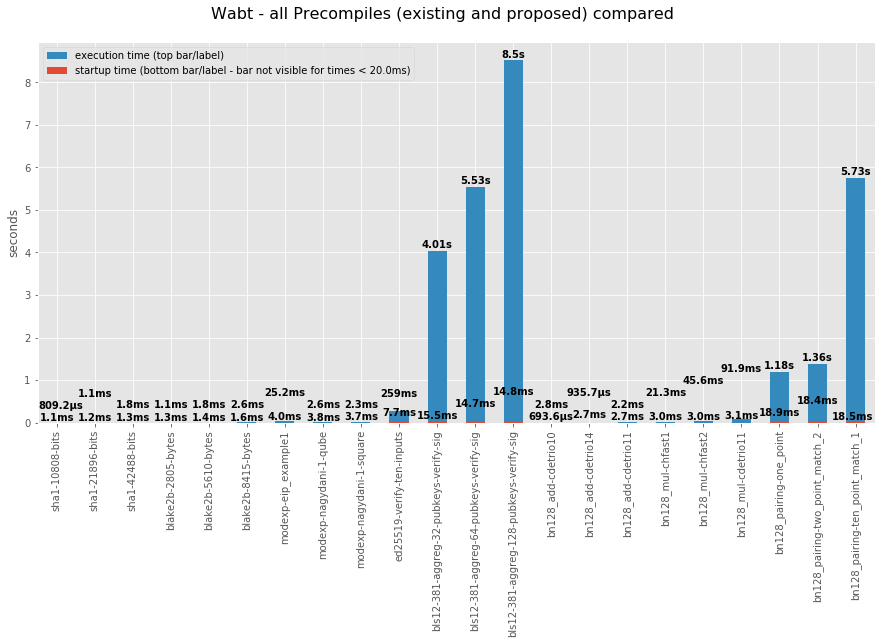

In [136]:
plotInterpOneEngine(df_interp, 'wabt', all_tests, "Wabt - all Precompiles (existing and proposed) compared")

<Figure size 432x288 with 0 Axes>

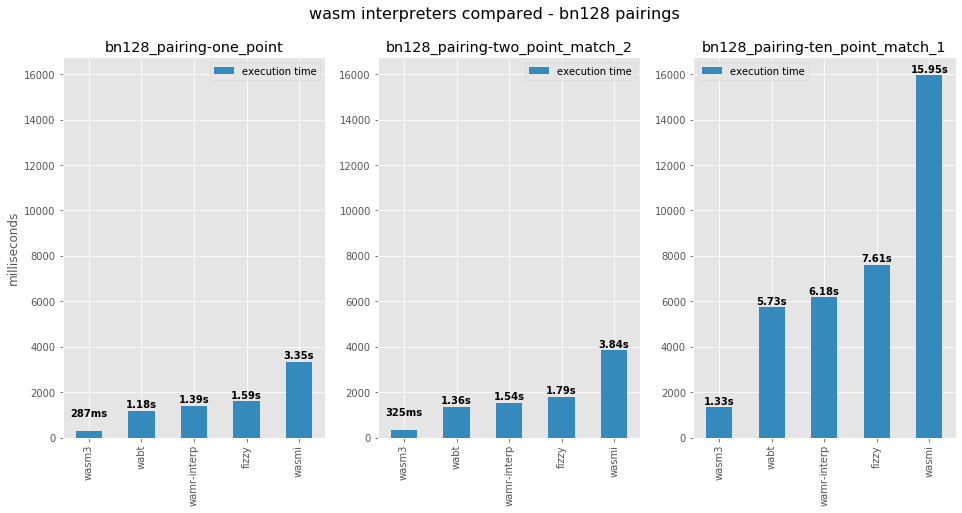

In [137]:
plotThreeTestsExecTime(df_interp,
                       bn128_pairing_test_names,
                       title="wasm interpreters compared - bn128 pairings",
                       filter_engines=["life", "wagon", "v8-interpreter"])

#### Are interpreter engines feasible for bn128 pairings?
TODO: highlight pairing two point match in interpreter engines



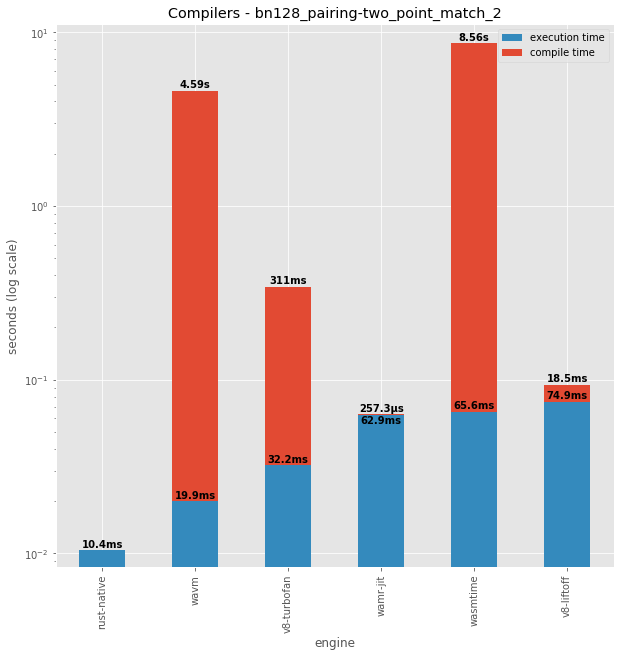

In [138]:
plotCompilerStackedOneTest(df_native_and_compile, "bn128_pairing-two_point_match_2")

#### Is any kind of wasm engine, interpreters or compilers, feasible for bn128 pairings?

V8-liftoff takes around 100ms, too slow relative to block processing time.

Can it be sped up? From profiling, we'd see that the bottleneck is bignum arithmetic. Maybe "native bignum methods", such as a mul256 opcode, would bring a significant speedup.

### add geth-native to df_scout_data for the rollup benchmark

In [139]:
df_geth_native_bn128pairing

precompile_name                    input_name     gas      time
57  PrecompiledBn256Pairing  two_point_match_rollup_input  113000  0.004205

In [140]:
df_geth_native_bn128pairing.loc[:, 'engine'] = "go-native"
df_geth_native_bn128pairing.loc[:, 'parse_time'] = 0

In [141]:
df_geth_native_bn128pairing.rename(columns={'input_name':'bench_name','time':'exec_time'},inplace=True)
df_geth_native_bn128pairing.drop(['precompile_name'],axis=1,inplace=True)
df_geth_native_bn128pairing.drop(['gas'],axis=1,inplace=True)
df_geth_native_bn128pairing = df_geth_native_bn128pairing[['engine', 'bench_name', 'parse_time', 'exec_time']]

In [142]:
df_geth_native_bn128pairing.loc[:,'bench_name'] = 'ecpairing-zkrollup-go-native-bn128-two-pairings'

In [143]:
df_geth_native_bn128pairing

engine                                       bench_name  parse_time  \
57  go-native  ecpairing-zkrollup-go-native-bn128-two-pairings         0.0   

    exec_time  
57   0.004205

### list engine names

In [144]:
df_scout_rust_vs_websnark = df_scout_data[
    df_scout_data['bench_name'].isin(
        ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings',
         'ecpairing-zkrollup-websnark-bn128-two-pairings',
         'ecpairing-zkrollup-rust-native-bn128-two-pairings']
    )
]

df_scout_rust_vs_websnark = df_scout_rust_vs_websnark.append(df_geth_native_bn128pairing)

df_scout_rust_vs_websnark['engine'].unique().tolist()


['rust-native',
 'wabt-no-bignums',
 'wabt-bignums-slowhost-slowmont',
 'wabt-bignums-slowhost-slowmont-superops',
 'wabt-bignums-fasthost-slowmont-superops',
 'wabt-bignums-fasthost-fastmont-superops',
 'wabt-bignums-fasthost-fastmont',
 'v8-turbofan',
 'v8-liftoff',
 'v8-liftoff-and-turbofan',
 'v8-interpreter',
 'v8-turbofan-with-bignums',
 'v8-liftoff-with-bignums',
 'v8-interpreter-with-bignums',
 'go-native']

## function to prepare dataframe for rollup.rs and websnark plots

In [145]:
def prepDfForRollupPlot(df_scout_data, df_geth_native, include_bench_names, only_include_engines=None, rename_engines=None):
    df_scout_rollup = df_scout_data[
        df_scout_data['bench_name'].isin(include_bench_names)
    ].copy()

    df_scout_rollup = df_scout_rollup.fillna(0)
    df_scout_rollup = df_scout_rollup.append(df_geth_native).copy()
    if only_include_engines is not None:
        df_scout_rollup = df_scout_rollup[df_scout_rollup['engine'].isin(only_include_engines)]
    # rename_engines example: [['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums']]
    if rename_engines is not None:
        for rename in rename_engines:
            df_scout_rollup.replace(rename[0], rename[1], inplace=True)
    return df_scout_rollup


### rust-wasm: bignums optimization - basic bignums speedup (wabt-with-bignums)

In [146]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_rolluprs_bignums_vs_nobignums = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont', 'wabt-no-bignums'],
                                        rename_engines=[['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums']]
                                       )

df_scout_rolluprs_bignums_vs_nobignums = df_scout_rolluprs_bignums_vs_nobignums.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

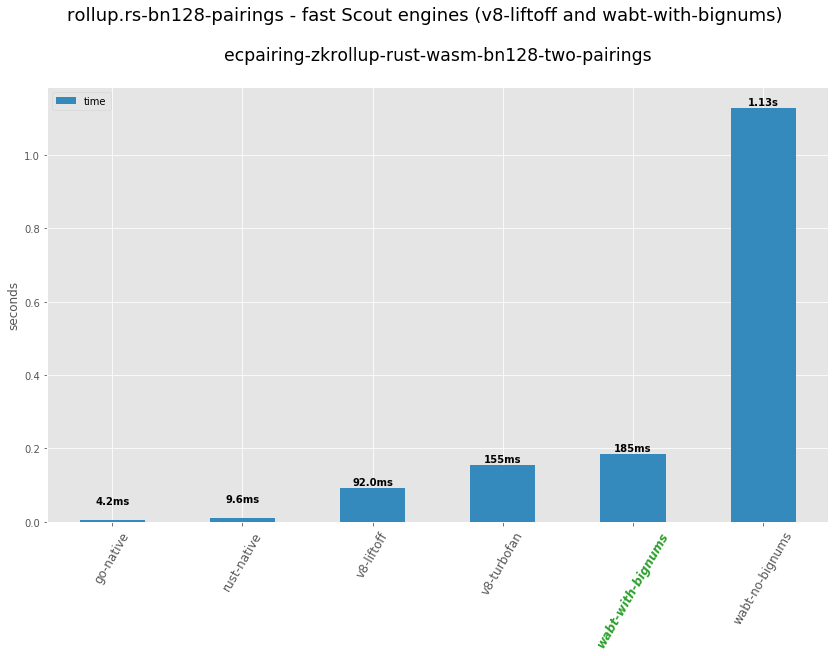

In [147]:

plotOneTestColoredTicks(df_scout_rolluprs_bignums_vs_nobignums,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-with-bignums")


#### Are interpreter engines feasible, given an API for fast bignums?

From wabt-no-bignums at 1.18s, adding a bignum API achieves a 5x+ speedup to 172ms! Our interpreter is about 2x slower than a fast JIT engine, v8-liftoff at 91ms. Is there any way to speed it up?




### rust-wasm: remove wabt-no-bignums from chart.  compare only wabt-with-bignums vs compilers

In [148]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']


df_scout_rolluprs_bignums = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont'],
                                        rename_engines=[['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums']]
                                       )


df_scout_rolluprs_bignums = df_scout_rolluprs_bignums.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

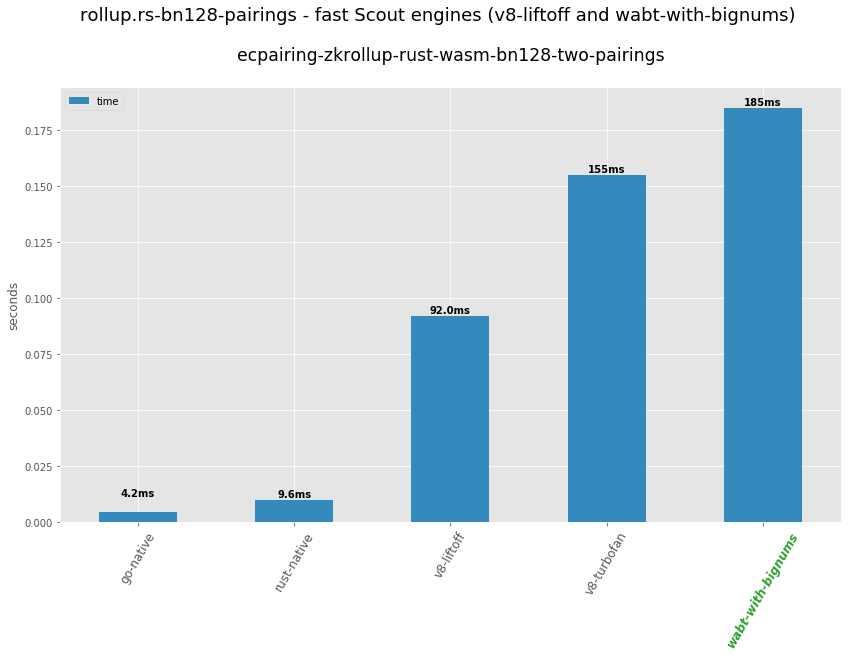

In [149]:
plotOneTestColoredTicks(df_scout_rolluprs_bignums,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-with-bignums")


### rust-wasm: Superops optimization

In [150]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']

include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops']


df_scout_rollup_rustwasm_superops = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=include_engines_list,
                                        rename_engines=[
                                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops']
                                        ]
                                       )

df_scout_rollup_rustwasm_superops = df_scout_rollup_rustwasm_superops.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

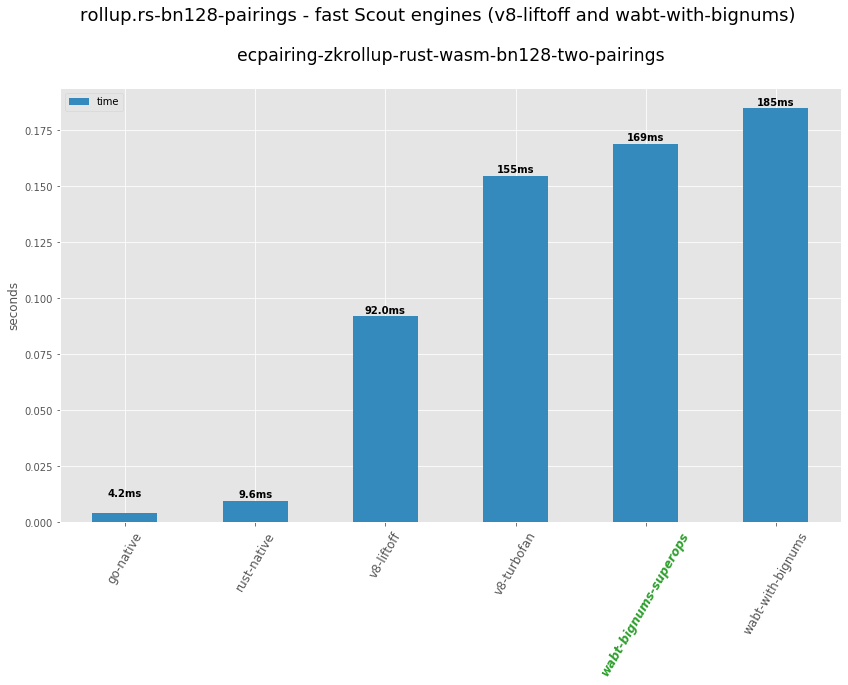

In [151]:

plotOneTestColoredTicks(df_scout_rollup_rustwasm_superops,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops")


### rust-wasm: in addition to superops, plot combied superops + fasthost, and superops + fasthost + fastmont

In [152]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-rust-native-bn128-two-pairings']

include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops',
                        'wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-fasthost-fastmont-superops']

df_scout_rolluprs_all_combos = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=include_engines_list,
                                        rename_engines=[
                                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops'],
                                            ['wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost-slowmont'],
                                            ['wabt-bignums-fasthost-fastmont-superops', 'wabt-bignums-superops-fasthost-fastmont']
                                        ]
                                       )

df_scout_rolluprs_all_combos = df_scout_rolluprs_all_combos.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

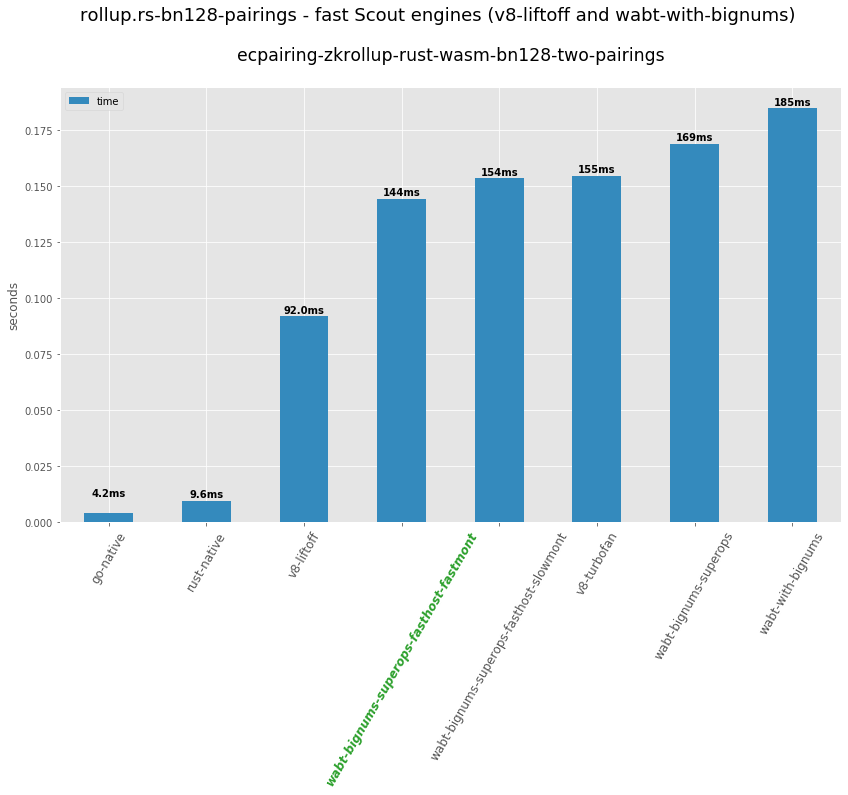

In [153]:
plotOneTestColoredTicks(df_scout_rolluprs_all_combos,
            suptitle="rollup.rs-bn128-pairings - fast Scout engines (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-rust-wasm-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops-fasthost-fastmont")


### Optimization: websnark-wasm vs rust-wasm

In [154]:
include_bench_names = ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'ecpairing-zkrollup-websnark-bn128-two-pairings']

include_engines_list = ['v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops']

df_scout_rust_vs_websnark = prepDfForRollupPlot(df_scout_data,
                                                df_geth_native_bn128pairing,
                                                include_bench_names,
                                                only_include_engines=include_engines_list,
                                                rename_engines=[
                                                    ['ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm'],
                                                    ['ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-wasm'],
                                                    ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                                    ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops']
                                                ])

<Figure size 432x288 with 0 Axes>

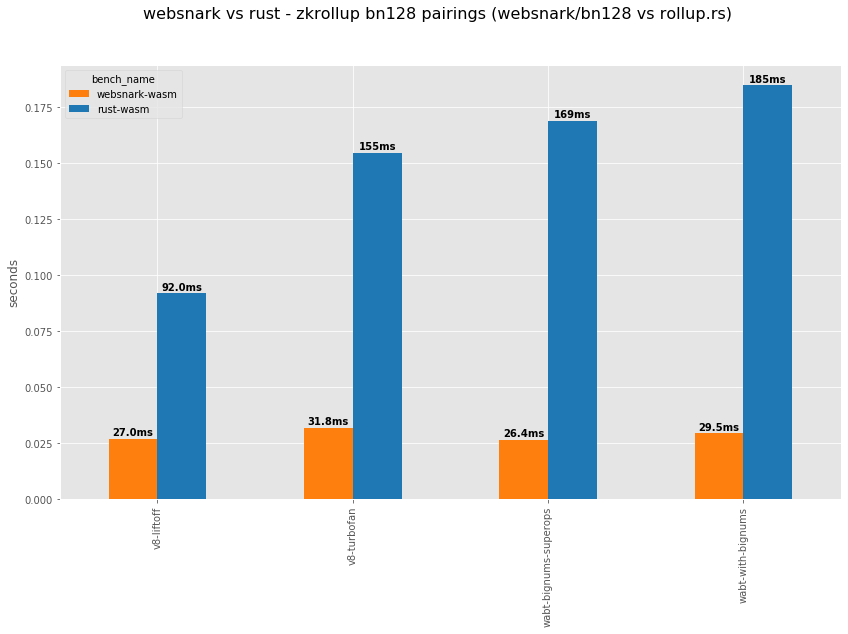

In [155]:
plotOneTestGrouped(df_scout_rust_vs_websnark,
                   title="websnark vs rust - zkrollup bn128 pairings (websnark/bn128 vs rollup.rs)",
                   test_title="",
                   group_order=['websnark-wasm', 'rust-wasm'],
                   sort_by=['rust-wasm'],
                   colors=['tab:orange', 'tab:blue'])


### drop rust-wasm, just plot websnark-wasm

In [156]:
include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops']

include_bench_names = ['ecpairing-zkrollup-websnark-bn128-two-pairings',
                       'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_websnark = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=include_engines_list,
                                        rename_engines=[
                                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops']
                                        ]
                                       )

df_scout_means_websnark = df_scout_websnark.groupby(['engine']).mean()

<Figure size 432x288 with 0 Axes>

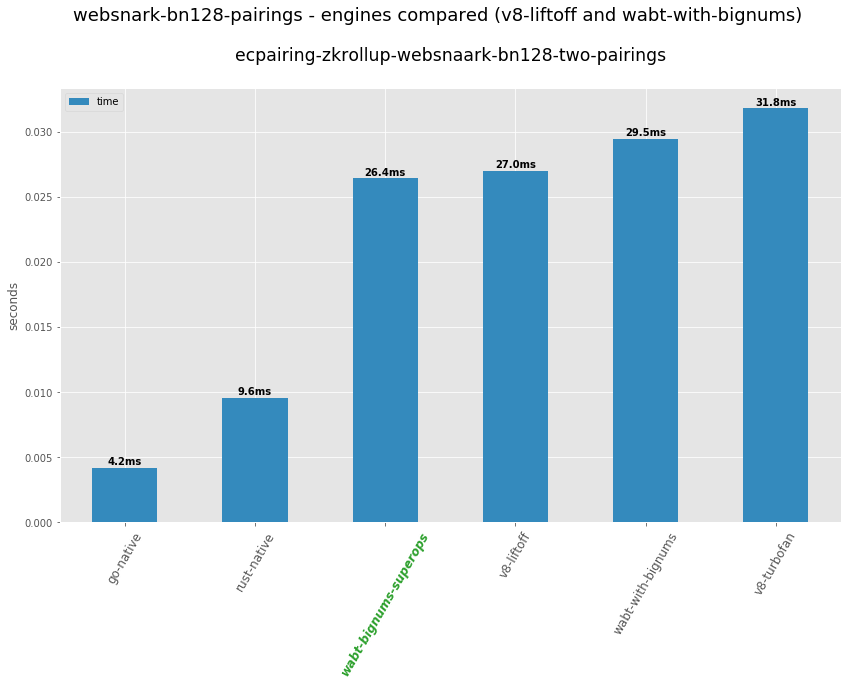

In [157]:
plotOneTestColoredTicks(df_scout_means_websnark,
            suptitle="websnark-bn128-pairings - engines compared (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops")


### websnark-wasm optimization: "fast-host"


In [158]:
include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'wabt-bignums-slowhost-slowmont', 'wabt-bignums-slowhost-slowmont-superops',
                        'wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-fasthost-slowmont-superops']

include_bench_names = ['ecpairing-zkrollup-websnark-bn128-two-pairings',
                       'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_websnark_fasthost = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=include_engines_list,
                                        rename_engines=[
                                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops'],
                                            ['wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost']
                                        ]
                                       )

df_scout_websnark_fasthost = df_scout_websnark_fasthost.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

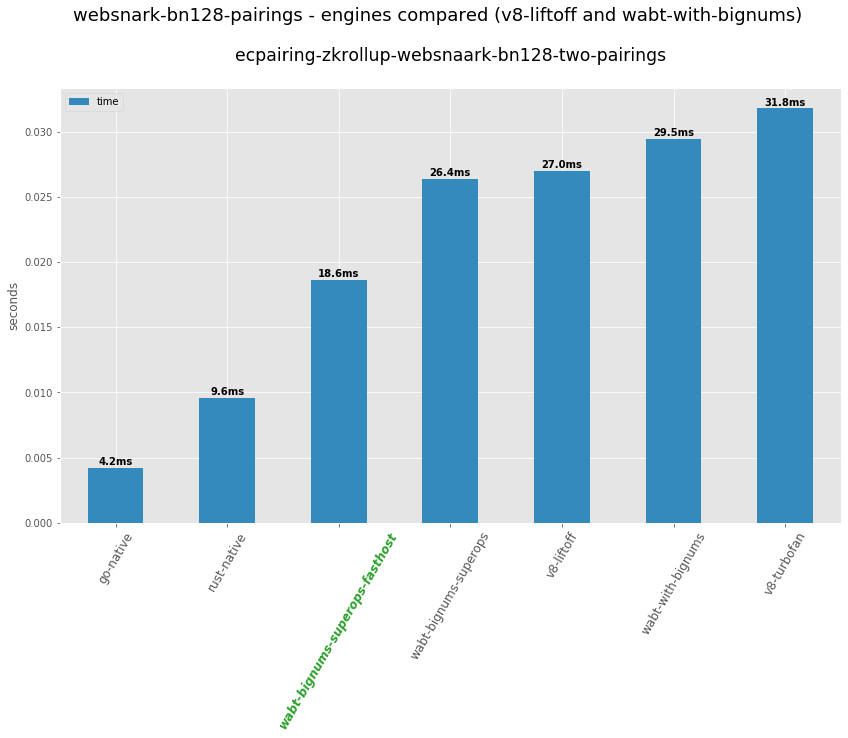

In [159]:
plotOneTestColoredTicks(df_scout_websnark_fasthost,
            suptitle="websnark-bn128-pairings - engines compared (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops-fasthost")


### websnark-wasm optimization: interleaved montgomery

In [160]:
include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan', 'wabt-bignums-slowhost-slowmont',
                        'wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-slowhost-slowmont-superops',
                        'wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-fasthost-fastmont-superops']

include_bench_names = ['ecpairing-zkrollup-websnark-bn128-two-pairings',
                       'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_websnark_fastmont = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=include_engines_list,
                                        rename_engines=[
                                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops'],
                                            ['wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost'],
                                            ['wabt-bignums-fasthost-fastmont-superops', 'wabt-bignums-superops-fasthost-fastmont']
                                        ]
                                       )

df_scout_websnark_fastmont = df_scout_websnark_fastmont.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

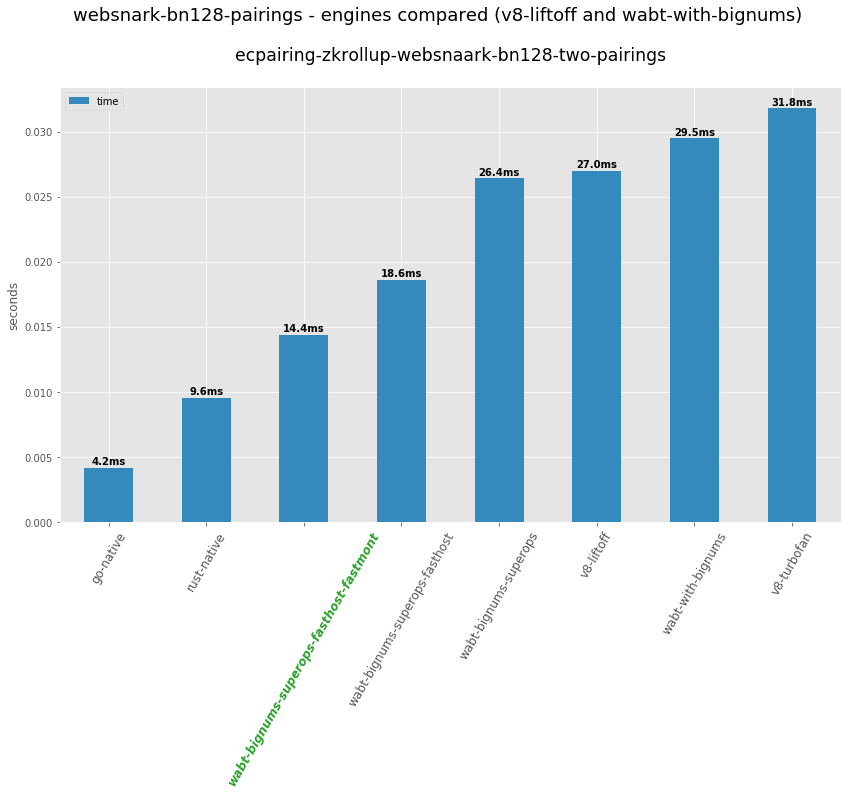

In [161]:
plotOneTestColoredTicks(df_scout_websnark_fastmont,
            suptitle="websnark-bn128-pairings - engines compared (v8-liftoff and wabt-with-bignums)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="wabt-bignums-superops-fasthost-fastmont")


### websnark-wasm: Show startup time and execution time, for interleaved montgomery and other optimizations

<Figure size 432x288 with 0 Axes>

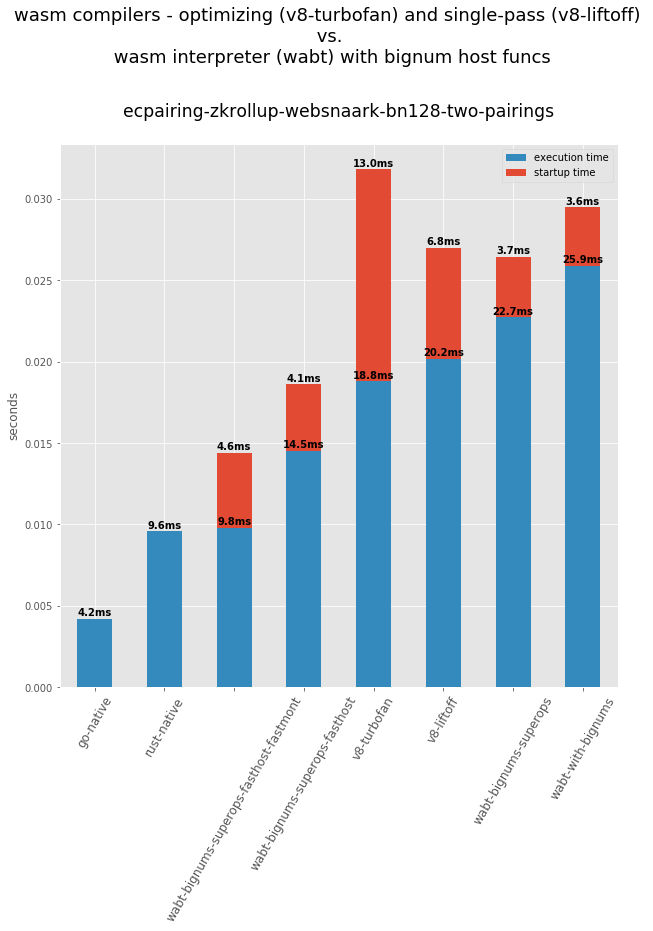

In [162]:
plotScoutStackedTest(df_scout_websnark_fastmont,
            suptitle="wasm compilers - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n wasm interpreter (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-websnaark-bn128-two-pairings\n",
            subtitle_size='xx-large')

## plot v8 without bigums versus v8 with bignum host funcs

```
['rust-native',
 'wabt-no-bignums',
 'wabt-bignums-slowhost-slowmont',
 'wabt-bignums-slowhost-slowmont-superops',
 'wabt-bignums-fasthost-slowmont-superops',
 'wabt-bignums-fasthost-fastmont-superops',
 'wabt-bignums-fasthost-fastmont',
 'v8-turbofan',
 'v8-liftoff',
 'v8-liftoff-and-turbofan',
 'v8-interpreter',
 'v8-turbofan-with-bignums',
 'v8-liftoff-with-bignums',
 'v8-interpreter-with-bignums',
 'go-native']
```

In [163]:
include_engines_list = ['go-native', 'rust-native', 'v8-liftoff', 'v8-turbofan',
                        'v8-turbofan-with-bignums', 'v8-liftoff-with-bignums',
                        'wabt-bignums-fasthost-fastmont-superops']

include_bench_names = ['ecpairing-zkrollup-websnark-bn128-two-pairings',
                       'ecpairing-zkrollup-rust-native-bn128-two-pairings']

df_scout_v8_with_hostfuncs = prepDfForRollupPlot(df_scout_data,
                                        df_geth_native_bn128pairing,
                                        include_bench_names,
                                        only_include_engines=include_engines_list,
                                        rename_engines=[
                                            ['wabt-bignums-slowhost-slowmont', 'wabt-with-bignums'],
                                            ['wabt-bignums-slowhost-slowmont-superops', 'wabt-bignums-superops'],
                                            ['wabt-bignums-fasthost-slowmont-superops', 'wabt-bignums-superops-fasthost'],
                                            ['wabt-bignums-fasthost-fastmont-superops', 'wabt-bignums-superops-fasthost-fastmont']
                                        ]
                                       )

df_scout_v8_with_hostfuncs = df_scout_v8_with_hostfuncs.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

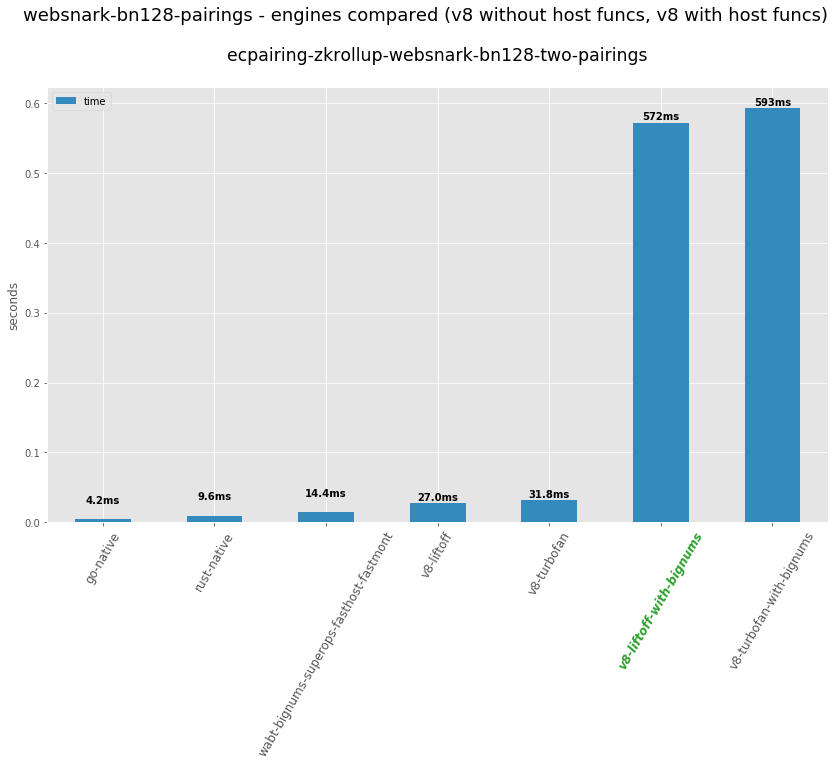

In [164]:
plotOneTestColoredTicks(df_scout_v8_with_hostfuncs,
            suptitle="websnark-bn128-pairings - engines compared (v8 without host funcs, v8 with host funcs)",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large',
            highlight_tick="v8-liftoff-with-bignums")


## EVM vs wasm shootout: bn128mul (Weierstrudel vs bn128mul.rust.wasm)

In [165]:
bn128_mul_test_names

['bn128_mul-chfast1', 'bn128_mul-chfast2', 'bn128_mul-cdetrio11']

<Figure size 432x288 with 0 Axes>

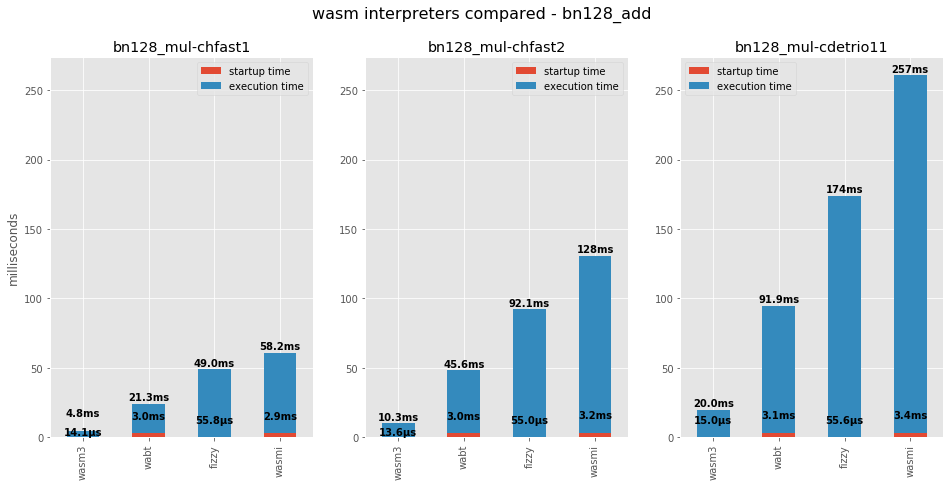

In [166]:
plotInterpThreeTests(df_interp,
                     bn128_mul_test_names,
                     title="wasm interpreters compared - bn128_add",
                     filter_engines=["life", "wagon", "v8-interpreter", "wamr-interp"])

In [167]:
df_wasm_bn128mul = df_interp[df_interp['test_name'] == "bn128_mul-chfast2"].copy()

In [168]:
df_wasm_bn128mul

test_name  elapsed_time  parse_time  exec_time  \
engine                                                                   
life            bn128_mul-chfast2      0.219174    0.046358   0.166210   
wagon           bn128_mul-chfast2      0.303576    0.158427   0.137203   
wasmi           bn128_mul-chfast2      0.136308    0.003229   0.127707   
wabt            bn128_mul-chfast2      0.052590    0.002993   0.045640   
v8-interpreter  bn128_mul-chfast2      0.254680    0.007153   0.164744   
wasm3           bn128_mul-chfast2      0.014783    0.000014   0.010301   
wamr-interp     bn128_mul-chfast2     24.173020    0.000802  24.137521   
fizzy           bn128_mul-chfast2      2.746173    0.000055   0.092123   

                total_time  
engine                      
life              0.212568  
wagon             0.295631  
wasmi             0.130936  
wabt              0.048634  
v8-interpreter    0.171897  
wasm3             0.010315  
wamr-interp      24.138323  
fizzy             0.092178

In [169]:
df_wasm_bn128mul.rename(columns={'test_name':'bench_name'},inplace=True)
df_wasm_bn128mul.drop(['elapsed_time'],axis=1,inplace=True)
df_wasm_bn128mul.drop(['total_time'],axis=1,inplace=True)
#df_wasm_mul256 = df_wasm_mul256[['engine', 'bench_name', 'parse_time', 'exec_time']]
df_wasm_bn128mul.reset_index(inplace=True)
df_wasm_bn128mul.replace('bn128_mul-chfast2', 'bn128mul.rust.wasm', inplace=True)

In [170]:
df_evm_raw[df_evm_raw['test_name'] == "bn128_mul_weierstrudel-cdetrio11"]

engine                         test_name  total_time gas_used
64      evmone  bn128_mul_weierstrudel-cdetrio11    0.000513  47.561k
65  parity-evm  bn128_mul_weierstrudel-cdetrio11    0.004136    47561
66    geth-evm  bn128_mul_weierstrudel-cdetrio11    0.002157    47561
67    cita-evm  bn128_mul_weierstrudel-cdetrio11    0.016865    75089

In [171]:
df_evm_bn128mul = df_evm_raw[df_evm_raw['test_name'] == "bn128_mul_weierstrudel-chfast2"].copy()

df_evm_bn128mul.rename(columns={'test_name':'bench_name', 'total_time':'exec_time'},inplace=True)
df_evm_bn128mul.drop(['gas_used'],axis=1,inplace=True)
df_evm_bn128mul.loc[:, 'parse_time'] = 0
df_evm_bn128mul = df_evm_bn128mul[['engine', 'bench_name', 'parse_time', 'exec_time']]

df_evm_bn128mul.replace('bn128_mul_weierstrudel-chfast2', 'bn128mul.weierstrudel.evm', inplace=True)


In [172]:
df_evm_bn128mul

engine                 bench_name  parse_time  exec_time
48      evmone  bn128mul.weierstrudel.evm           0   0.000458
49  parity-evm  bn128mul.weierstrudel.evm           0   0.003426
50    geth-evm  bn128mul.weierstrudel.evm           0   0.001819
51    cita-evm  bn128mul.weierstrudel.evm           0   0.014045

In [173]:
df_wasm_bn128mul

engine          bench_name  parse_time  exec_time
0            life  bn128mul.rust.wasm    0.046358   0.166210
1           wagon  bn128mul.rust.wasm    0.158427   0.137203
2           wasmi  bn128mul.rust.wasm    0.003229   0.127707
3            wabt  bn128mul.rust.wasm    0.002993   0.045640
4  v8-interpreter  bn128mul.rust.wasm    0.007153   0.164744
5           wasm3  bn128mul.rust.wasm    0.000014   0.010301
6     wamr-interp  bn128mul.rust.wasm    0.000802  24.137521
7           fizzy  bn128mul.rust.wasm    0.000055   0.092123

In [174]:
df_evm_vs_wasm_bn128mul = df_evm_bn128mul.append(df_wasm_bn128mul, sort=False).copy()

In [175]:
df_evm_vs_wasm_bn128mul

engine                 bench_name  parse_time  exec_time
48          evmone  bn128mul.weierstrudel.evm    0.000000   0.000458
49      parity-evm  bn128mul.weierstrudel.evm    0.000000   0.003426
50        geth-evm  bn128mul.weierstrudel.evm    0.000000   0.001819
51        cita-evm  bn128mul.weierstrudel.evm    0.000000   0.014045
0             life         bn128mul.rust.wasm    0.046358   0.166210
1            wagon         bn128mul.rust.wasm    0.158427   0.137203
2            wasmi         bn128mul.rust.wasm    0.003229   0.127707
3             wabt         bn128mul.rust.wasm    0.002993   0.045640
4   v8-interpreter         bn128mul.rust.wasm    0.007153   0.164744
5            wasm3         bn128mul.rust.wasm    0.000014   0.010301
6      wamr-interp         bn128mul.rust.wasm    0.000802  24.137521
7            fizzy         bn128mul.rust.wasm    0.000055   0.092123

In [176]:
df_evm_vs_wasm_bn128mul.loc[:,'time'] = df_evm_vs_wasm_bn128mul['parse_time'] + df_evm_vs_wasm_bn128mul['exec_time']

In [177]:
df_evm_vs_wasm_bn128mul = df_evm_vs_wasm_bn128mul[df_evm_vs_wasm_bn128mul['engine'].isin(
    ['parity-evm', 'geth-evm', 'evmone', 'cita-evm',
    'wasmi', 'wabt', 'fizzy', 'wasm3']
)].copy()

In [178]:
df_evm_vs_wasm_bn128mul = df_evm_vs_wasm_bn128mul.sort_values('time')

Text(0.5, 1.02, 'EVM vs Wasm interpreters: bn128mul aka ECMUL \n\n bn128mul (Rust compiled to Wasm) vs Weierstrudel (Huff compiled to EVM)')

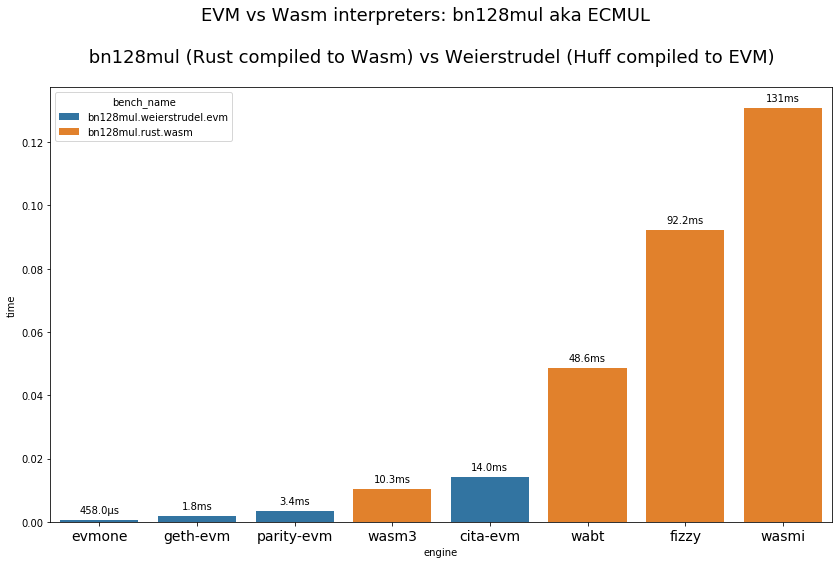

In [179]:
f = plt.figure(figsize=(14,8))
#sns.set()
sns.reset_defaults() # use default colors, orange and blue
#sns.set(font_scale = 1.2)
splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_evm_vs_wasm_bn128mul)


# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

splot.set_xticklabels(splot.get_xticklabels(), size = 14)

f.suptitle("EVM vs Wasm interpreters: bn128mul aka ECMUL \n\n bn128mul (Rust compiled to Wasm) vs Weierstrudel (Huff compiled to EVM)", fontsize=18, y=1.02)


## EVM vs wasm shootout: mul256

In [180]:
df_interp

test_name  elapsed_time  \
engine                                                                  
life                                  bn128_mul-chfast2      0.219174   
life                                bn128_add-cdetrio11      0.057500   
life                                    sha1-42488-bits      0.021781   
life                                          ecpairing     15.651635   
life                                  bn128_mul-chfast3      0.342489   
life                           mul256-gcolvin-drag-race      6.532795   
life                                bn128_mul-cdetrio11      0.386682   
life                                    sha1-10808-bits      0.015013   
life                    bn128_pairing-ten_point_match_1     20.684325   
life                           modexp-nagydani-1-square      0.057406   
life                            bn128_pairing-one_point      4.571831   
life                                bn128_mul-cdetrio12      0.333658   
life                             modexp-nagydani-1-qube      0.057930   
life                          ed25519-verify-ten-inputs      1.199837   
life                                 blake2b-5610-bytes      0.025095   
life                                bn128_add-cdetrio10      0.050859   
life                                 bn128_mul-cdetrio6      0.377446   
life                                 bn128_mul-cdetrio7      0.327778   
life                                modexp-eip_example1      0.139606   
life                    bn128_pairing-two_point_match_2      5.235736   
life                                  bn128_mul-chfast1      0.125193   
life                                 blake2b-2805-bytes      0.020592   
life                                    sha1-21896-bits      0.016493   
life                                 bn128_mul-cdetrio2      0.332876   
life                                 blake2b-8415-bytes      0.028521   
life                                bn128_add-cdetrio14      0.051322   
wagon                                 bn128_mul-chfast2      0.303576   
wagon                               bn128_add-cdetrio11      0.146441   
wagon                                   sha1-42488-bits      0.043942   
wagon                                         ecpairing     12.686000   
wagon                                 bn128_mul-chfast3      0.404959   
wagon                          mul256-gcolvin-drag-race      5.327222   
wagon                               bn128_mul-cdetrio11      0.445656   
wagon                                   sha1-10808-bits      0.033528   
wagon                   bn128_pairing-ten_point_match_1     17.924180   
wagon                          modexp-nagydani-1-square      0.223578   
wagon                           bn128_pairing-one_point      4.582040   
wagon                               bn128_mul-cdetrio12      0.392299   
wagon           bls12-381-aggreg-128-pubkeys-verify-sig     26.538001   
wagon                            modexp-nagydani-1-qube      0.223559   
wagon                         ed25519-verify-ten-inputs      1.254973   
wagon            bls12-381-aggreg-64-pubkeys-verify-sig     17.537063   
wagon                                blake2b-5610-bytes      0.056092   
wagon                               bn128_add-cdetrio10      0.141706   
wagon                                bn128_mul-cdetrio6      0.435579   
wagon                                bn128_mul-cdetrio7      0.388638   
wagon                               modexp-eip_example1      0.286990   
wagon                   bn128_pairing-two_point_match_2      5.094264   
wagon                                 bn128_mul-chfast1      0.221352   
wagon            bls12-381-aggreg-32-pubkeys-verify-sig     12.946346   
wagon                                blake2b-2805-bytes      0.051732   
wagon                                   sha1-21896-bits      0.035900   
wagon                                bn128_mul-cdetrio2      0.390628   
wagon                          

In [181]:
df_wasm_mul256 = df_interp[df_interp['test_name'] == "mul256-gcolvin-drag-race"].copy()

In [182]:
df_wasm_mul256

test_name  elapsed_time  parse_time  exec_time  \
engine                                                                          
life            mul256-gcolvin-drag-race      6.532795    0.027156   6.498374   
wagon           mul256-gcolvin-drag-race      5.327222    0.062717   5.258772   
wasmi           mul256-gcolvin-drag-race      5.093102    0.002290   5.086245   
wabt            mul256-gcolvin-drag-race      1.564011    0.002051   1.557703   
v8-interpreter  mul256-gcolvin-drag-race      5.188679    0.004203   5.099159   
wasm3           mul256-gcolvin-drag-race      0.320076    0.000016   0.315996   
wamr-interp     mul256-gcolvin-drag-race      1.266852    0.000993   1.262382   
fizzy           mul256-gcolvin-drag-race      6.241244    0.000056   2.333541   

                total_time  
engine                      
life              6.525530  
wagon             5.321488  
wasmi             5.088535  
wabt              1.559754  
v8-interpreter    5.103363  
wasm3             0.316012  
wamr-interp       1.263375  
fizzy             2.333597

In [183]:
df_wasm_mul256.rename(columns={'test_name':'bench_name'},inplace=True)
df_wasm_mul256.drop(['elapsed_time'],axis=1,inplace=True)
df_wasm_mul256.drop(['total_time'],axis=1,inplace=True)
#df_wasm_mul256 = df_wasm_mul256[['engine', 'bench_name', 'parse_time', 'exec_time']]
df_wasm_mul256.reset_index(inplace=True)
df_wasm_mul256.replace('mul256-gcolvin-drag-race', 'mul256.rust.wasm', inplace=True)

In [184]:
df_wasm_mul256

engine        bench_name  parse_time  exec_time
0            life  mul256.rust.wasm    0.027156   6.498374
1           wagon  mul256.rust.wasm    0.062717   5.258772
2           wasmi  mul256.rust.wasm    0.002290   5.086245
3            wabt  mul256.rust.wasm    0.002051   1.557703
4  v8-interpreter  mul256.rust.wasm    0.004203   5.099159
5           wasm3  mul256.rust.wasm    0.000016   0.315996
6     wamr-interp  mul256.rust.wasm    0.000993   1.262382
7           fizzy  mul256.rust.wasm    0.000056   2.333541

In [185]:
df_evm_raw

engine                         test_name  total_time  gas_used
0       evmone          sha1-10808-bits-shiftopt    0.001596  759.785k
1   parity-evm          sha1-10808-bits-shiftopt    0.022314    759785
2     geth-evm          sha1-10808-bits-shiftopt    0.017770    759785
3     cita-evm          sha1-10808-bits-shiftopt    0.012676    873117
4       evmone          sha1-21896-bits-shiftopt    0.003226  1.48425M
5   parity-evm          sha1-21896-bits-shiftopt    0.040143   1484254
6     geth-evm          sha1-21896-bits-shiftopt    0.035941   1484254
7     cita-evm          sha1-21896-bits-shiftopt    0.025492   1691062
8       evmone          sha1-42488-bits-shiftopt    0.006501  2.89847M
9   parity-evm          sha1-42488-bits-shiftopt    0.086442   2898473
10    geth-evm          sha1-42488-bits-shiftopt    0.076433   2898473
11    cita-evm          sha1-42488-bits-shiftopt    0.050730   3280257
12      evmone       blake2b-8415-bytes-shiftopt    0.037586  12.0431M
13  parity-evm       blake2b-8415-bytes-shiftopt    0.304235  12043105
14    geth-evm       blake2b-8415-bytes-shiftopt    0.250975  12043105
15    cita-evm       blake2b-8415-bytes-shiftopt    0.227318  12635513
16      evmone       blake2b-5610-bytes-shiftopt    0.024851  7.43482M
17  parity-evm       blake2b-5610-bytes-shiftopt    0.191788   7434820
18    geth-evm       blake2b-5610-bytes-shiftopt    0.164830   7434820
19    cita-evm       blake2b-5610-bytes-shiftopt    0.148495   7837276
20      evmone       blake2b-2805-bytes-shiftopt    0.012214  3.42353M
21  parity-evm       blake2b-2805-bytes-shiftopt    0.099552   3423526
22    geth-evm       blake2b-2805-bytes-shiftopt    0.083734   3423526
23    cita-evm       blake2b-2805-bytes-shiftopt    0.075648   3635902
24      evmone                blake2b-8415-bytes    0.044307  12.3518M
25  parity-evm                blake2b-8415-bytes    0.312272  12351815
26    geth-evm                blake2b-8415-bytes    0.258288  12351815
27    cita-evm                blake2b-8415-bytes    0.287592  12944223
28      evmone                blake2b-5610-bytes    0.029281  7.64067M
29  parity-evm                blake2b-5610-bytes    0.197468   7640669
30    geth-evm                blake2b-5610-bytes    0.176871   7640669
31    cita-evm                blake2b-5610-bytes    0.191671   8043125
32      evmone                blake2b-2805-bytes    0.015022  3.52651M
33  parity-evm                blake2b-2805-bytes    0.104159   3526514
34    geth-evm                blake2b-2805-bytes    0.086334   3526514
35    cita-evm                blake2b-2805-bytes    0.094874   3738890
36      evmone               bn256g2mul-0xAshish    0.002260  455.757k
37  parity-evm               bn256g2mul-0xAshish    0.019949    455757
38    geth-evm               bn256g2mul-0xAshish    0.015922    455757
39    cita-evm               bn256g2mul-0xAshish    0.042454    486053
40      evmone   bn128_mul_weierstrudel-cdetrio2    0.000521   47.165k
41  parity-evm   bn128_mul_weierstrudel-cdetrio2    0.004142     47165
42    geth-evm   bn128_mul_weierstrudel-cdetrio2    0.002277     47165
43    cita-evm   bn128_mul_weierstrudel-cdetrio2    0.017047     74437
44      evmone    bn128_mul_weierstrudel-chfast1    0.000294   23.449k
45  parity-evm    bn128_mul_weierstrudel-chfast1    0.001957     23449
46    geth-evm    bn128_mul_weierstrudel-chfast1    0.001065     23449
47    cita-evm    bn128_mul_weierstrudel-chfast1    0.007357     49441
48      evmone    bn128_mul_weierstrudel-chfast2    0.000458   39.337k
49  parity-evm    bn128_mul_weierstrudel-chfast2    0.003426     39337
50    geth-evm    bn128_mul_weierstrudel-chfast2    0.001819     39337
51    cita-evm    bn128_mul_weierstrudel-chfast2    0.014045     66865
52      evmone    bn128_mul_weierstrudel-chfast3    0.000525   47.291k
53  parity-evm    bn128_mul_weierstrudel-chfast3    0.004223     47291
54    geth-evm    bn128_mul_weierstrudel-chfast3    0.002231     47291
55    cita-evm    bn128_mul_weie

In [186]:
df_evm_mul256 = df_evm_raw[df_evm_raw['test_name'] == "mul256-gcolvin-drag-race"].copy()

df_evm_mul256.rename(columns={'test_name':'bench_name', 'total_time':'exec_time'},inplace=True)
df_evm_mul256.drop(['gas_used'],axis=1,inplace=True)
df_evm_mul256.loc[:, 'parse_time'] = 0
df_evm_mul256 = df_evm_mul256[['engine', 'bench_name', 'parse_time', 'exec_time']]

df_evm_mul256.replace('mul256-gcolvin-drag-race', 'mul256.sol.evm', inplace=True)


In [187]:
df_evm_vs_wasm_mul256 = df_evm_mul256.append(df_wasm_mul256, sort=False).copy()

In [188]:
df_evm_vs_wasm_mul256

engine        bench_name  parse_time  exec_time
96          evmone    mul256.sol.evm    0.000000   0.011393
97      parity-evm    mul256.sol.evm    0.000000   0.114633
98        geth-evm    mul256.sol.evm    0.000000   0.167469
99        cita-evm    mul256.sol.evm    0.000000   0.043009
0             life  mul256.rust.wasm    0.027156   6.498374
1            wagon  mul256.rust.wasm    0.062717   5.258772
2            wasmi  mul256.rust.wasm    0.002290   5.086245
3             wabt  mul256.rust.wasm    0.002051   1.557703
4   v8-interpreter  mul256.rust.wasm    0.004203   5.099159
5            wasm3  mul256.rust.wasm    0.000016   0.315996
6      wamr-interp  mul256.rust.wasm    0.000993   1.262382
7            fizzy  mul256.rust.wasm    0.000056   2.333541

In [189]:
df_evm_vs_wasm_mul256.loc[:,'time'] = df_evm_vs_wasm_mul256['parse_time'] + df_evm_vs_wasm_mul256['exec_time']

In [190]:
df_evm_vs_wasm_mul256

engine        bench_name  parse_time  exec_time      time
96          evmone    mul256.sol.evm    0.000000   0.011393  0.011393
97      parity-evm    mul256.sol.evm    0.000000   0.114633  0.114633
98        geth-evm    mul256.sol.evm    0.000000   0.167469  0.167469
99        cita-evm    mul256.sol.evm    0.000000   0.043009  0.043009
0             life  mul256.rust.wasm    0.027156   6.498374  6.525530
1            wagon  mul256.rust.wasm    0.062717   5.258772  5.321488
2            wasmi  mul256.rust.wasm    0.002290   5.086245  5.088535
3             wabt  mul256.rust.wasm    0.002051   1.557703  1.559754
4   v8-interpreter  mul256.rust.wasm    0.004203   5.099159  5.103363
5            wasm3  mul256.rust.wasm    0.000016   0.315996  0.316012
6      wamr-interp  mul256.rust.wasm    0.000993   1.262382  1.263375
7            fizzy  mul256.rust.wasm    0.000056   2.333541  2.333597

In [191]:
df_evm_vs_wasm_mul256 = df_evm_vs_wasm_mul256[df_evm_vs_wasm_mul256['engine'].isin(
    ['parity-evm', 'geth-evm', 'evmone', 'cita-evm',
    'wasmi', 'wabt', 'wamr-interp', 'fizzy', 'wasm3']
)].copy()

In [192]:
df_evm_vs_wasm_mul256 = df_evm_vs_wasm_mul256.sort_values('time')

Text(0.5, 0.95, 'EVM vs Wasm interpreters: mul256-gcolvin-drag-race')

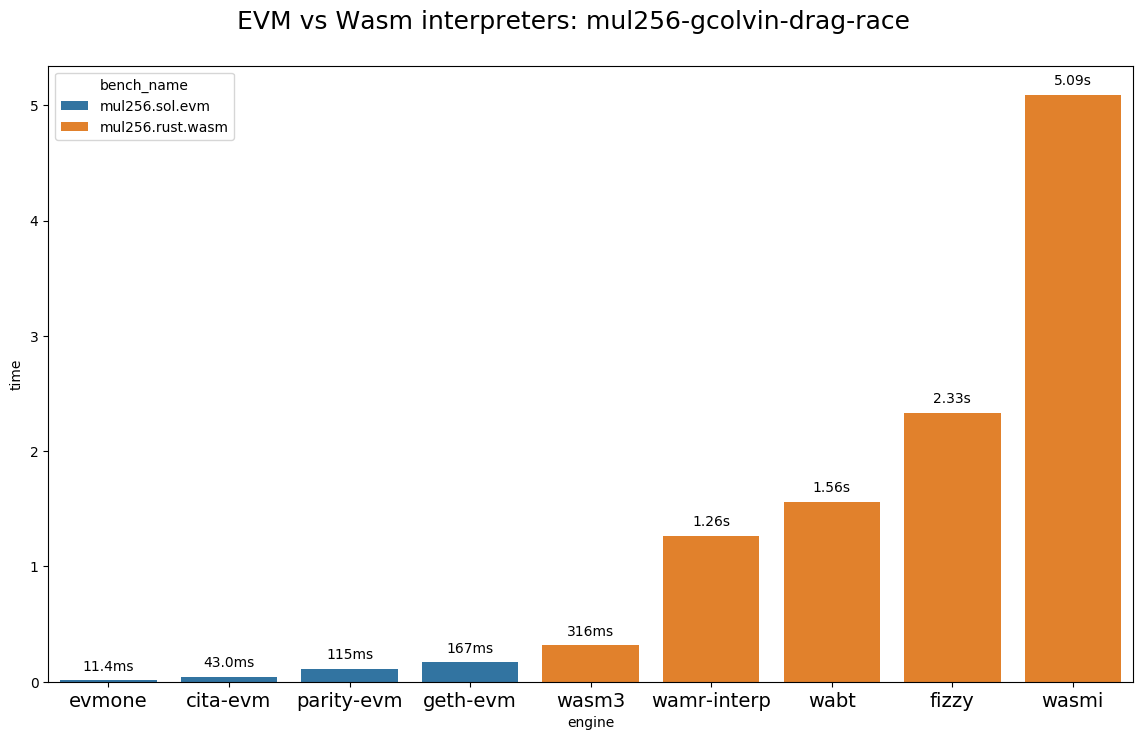

In [193]:
f = plt.figure(figsize=(14,8))
#sns.set()
sns.reset_defaults() # use default colors, orange and blue
#sns.set(font_scale = 1.2)
splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_evm_vs_wasm_mul256)


# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

splot.set_xticklabels(splot.get_xticklabels(), size = 14)

f.suptitle("EVM vs Wasm interpreters: mul256-gcolvin-drag-race", fontsize=18, y=0.95)


## EVM vs wasm shootout: blake2b

In [194]:
df_evm_raw

engine                         test_name  total_time  gas_used
0       evmone          sha1-10808-bits-shiftopt    0.001596  759.785k
1   parity-evm          sha1-10808-bits-shiftopt    0.022314    759785
2     geth-evm          sha1-10808-bits-shiftopt    0.017770    759785
3     cita-evm          sha1-10808-bits-shiftopt    0.012676    873117
4       evmone          sha1-21896-bits-shiftopt    0.003226  1.48425M
5   parity-evm          sha1-21896-bits-shiftopt    0.040143   1484254
6     geth-evm          sha1-21896-bits-shiftopt    0.035941   1484254
7     cita-evm          sha1-21896-bits-shiftopt    0.025492   1691062
8       evmone          sha1-42488-bits-shiftopt    0.006501  2.89847M
9   parity-evm          sha1-42488-bits-shiftopt    0.086442   2898473
10    geth-evm          sha1-42488-bits-shiftopt    0.076433   2898473
11    cita-evm          sha1-42488-bits-shiftopt    0.050730   3280257
12      evmone       blake2b-8415-bytes-shiftopt    0.037586  12.0431M
13  parity-evm       blake2b-8415-bytes-shiftopt    0.304235  12043105
14    geth-evm       blake2b-8415-bytes-shiftopt    0.250975  12043105
15    cita-evm       blake2b-8415-bytes-shiftopt    0.227318  12635513
16      evmone       blake2b-5610-bytes-shiftopt    0.024851  7.43482M
17  parity-evm       blake2b-5610-bytes-shiftopt    0.191788   7434820
18    geth-evm       blake2b-5610-bytes-shiftopt    0.164830   7434820
19    cita-evm       blake2b-5610-bytes-shiftopt    0.148495   7837276
20      evmone       blake2b-2805-bytes-shiftopt    0.012214  3.42353M
21  parity-evm       blake2b-2805-bytes-shiftopt    0.099552   3423526
22    geth-evm       blake2b-2805-bytes-shiftopt    0.083734   3423526
23    cita-evm       blake2b-2805-bytes-shiftopt    0.075648   3635902
24      evmone                blake2b-8415-bytes    0.044307  12.3518M
25  parity-evm                blake2b-8415-bytes    0.312272  12351815
26    geth-evm                blake2b-8415-bytes    0.258288  12351815
27    cita-evm                blake2b-8415-bytes    0.287592  12944223
28      evmone                blake2b-5610-bytes    0.029281  7.64067M
29  parity-evm                blake2b-5610-bytes    0.197468   7640669
30    geth-evm                blake2b-5610-bytes    0.176871   7640669
31    cita-evm                blake2b-5610-bytes    0.191671   8043125
32      evmone                blake2b-2805-bytes    0.015022  3.52651M
33  parity-evm                blake2b-2805-bytes    0.104159   3526514
34    geth-evm                blake2b-2805-bytes    0.086334   3526514
35    cita-evm                blake2b-2805-bytes    0.094874   3738890
36      evmone               bn256g2mul-0xAshish    0.002260  455.757k
37  parity-evm               bn256g2mul-0xAshish    0.019949    455757
38    geth-evm               bn256g2mul-0xAshish    0.015922    455757
39    cita-evm               bn256g2mul-0xAshish    0.042454    486053
40      evmone   bn128_mul_weierstrudel-cdetrio2    0.000521   47.165k
41  parity-evm   bn128_mul_weierstrudel-cdetrio2    0.004142     47165
42    geth-evm   bn128_mul_weierstrudel-cdetrio2    0.002277     47165
43    cita-evm   bn128_mul_weierstrudel-cdetrio2    0.017047     74437
44      evmone    bn128_mul_weierstrudel-chfast1    0.000294   23.449k
45  parity-evm    bn128_mul_weierstrudel-chfast1    0.001957     23449
46    geth-evm    bn128_mul_weierstrudel-chfast1    0.001065     23449
47    cita-evm    bn128_mul_weierstrudel-chfast1    0.007357     49441
48      evmone    bn128_mul_weierstrudel-chfast2    0.000458   39.337k
49  parity-evm    bn128_mul_weierstrudel-chfast2    0.003426     39337
50    geth-evm    bn128_mul_weierstrudel-chfast2    0.001819     39337
51    cita-evm    bn128_mul_weierstrudel-chfast2    0.014045     66865
52      evmone    bn128_mul_weierstrudel-chfast3    0.000525   47.291k
53  parity-evm    bn128_mul_weierstrudel-chfast3    0.004223     47291
54    geth-evm    bn128_mul_weierstrudel-chfast3    0.002231     47291
55    cita-evm    bn128_mul_weie

In [195]:
df_interp

test_name  elapsed_time  \
engine                                                                  
life                                  bn128_mul-chfast2      0.219174   
life                                bn128_add-cdetrio11      0.057500   
life                                    sha1-42488-bits      0.021781   
life                                          ecpairing     15.651635   
life                                  bn128_mul-chfast3      0.342489   
life                           mul256-gcolvin-drag-race      6.532795   
life                                bn128_mul-cdetrio11      0.386682   
life                                    sha1-10808-bits      0.015013   
life                    bn128_pairing-ten_point_match_1     20.684325   
life                           modexp-nagydani-1-square      0.057406   
life                            bn128_pairing-one_point      4.571831   
life                                bn128_mul-cdetrio12      0.333658   
life                             modexp-nagydani-1-qube      0.057930   
life                          ed25519-verify-ten-inputs      1.199837   
life                                 blake2b-5610-bytes      0.025095   
life                                bn128_add-cdetrio10      0.050859   
life                                 bn128_mul-cdetrio6      0.377446   
life                                 bn128_mul-cdetrio7      0.327778   
life                                modexp-eip_example1      0.139606   
life                    bn128_pairing-two_point_match_2      5.235736   
life                                  bn128_mul-chfast1      0.125193   
life                                 blake2b-2805-bytes      0.020592   
life                                    sha1-21896-bits      0.016493   
life                                 bn128_mul-cdetrio2      0.332876   
life                                 blake2b-8415-bytes      0.028521   
life                                bn128_add-cdetrio14      0.051322   
wagon                                 bn128_mul-chfast2      0.303576   
wagon                               bn128_add-cdetrio11      0.146441   
wagon                                   sha1-42488-bits      0.043942   
wagon                                         ecpairing     12.686000   
wagon                                 bn128_mul-chfast3      0.404959   
wagon                          mul256-gcolvin-drag-race      5.327222   
wagon                               bn128_mul-cdetrio11      0.445656   
wagon                                   sha1-10808-bits      0.033528   
wagon                   bn128_pairing-ten_point_match_1     17.924180   
wagon                          modexp-nagydani-1-square      0.223578   
wagon                           bn128_pairing-one_point      4.582040   
wagon                               bn128_mul-cdetrio12      0.392299   
wagon           bls12-381-aggreg-128-pubkeys-verify-sig     26.538001   
wagon                            modexp-nagydani-1-qube      0.223559   
wagon                         ed25519-verify-ten-inputs      1.254973   
wagon            bls12-381-aggreg-64-pubkeys-verify-sig     17.537063   
wagon                                blake2b-5610-bytes      0.056092   
wagon                               bn128_add-cdetrio10      0.141706   
wagon                                bn128_mul-cdetrio6      0.435579   
wagon                                bn128_mul-cdetrio7      0.388638   
wagon                               modexp-eip_example1      0.286990   
wagon                   bn128_pairing-two_point_match_2      5.094264   
wagon                                 bn128_mul-chfast1      0.221352   
wagon            bls12-381-aggreg-32-pubkeys-verify-sig     12.946346   
wagon                                blake2b-2805-bytes      0.051732   
wagon                                   sha1-21896-bits      0.035900   
wagon                                bn128_mul-cdetrio2      0.390628   
wagon                          

In [196]:
# df_evm_raw test_name="blake2b-8415-bytes"
# df_evm_raw test_name="blake2b_huff-8415-bytes"

# df_interp test_name="blake2b-8415-bytes"


`df_evm_vs_wasm_blake2b`
```
          engine	bench_name	parse_time	exec_time
1383	v8-turbofan	websnark-wasm	0.012526	0.019856
1384	v8-liftoff	websnark-wasm	0.006579	0.019689
1390	v8-turbofan	rust-wasm	0.020768	0.117253
1391	v8-liftoff	rust-wasm	0.014276	0.070435
1404	v8-turbofan	websnark-wasm	0.009650	0.021088
1405	v8-liftoff	websnark-wasm	0.008004	0.024127
```

In [197]:
df_evm_blake2b = df_evm_raw[df_evm_raw['test_name'].isin(['blake2b-8415-bytes', 'blake2b_huff-8415-bytes'])].copy()

In [198]:
#df_evm_blake2b

In [199]:
df_evm_blake2b.rename(columns={'test_name':'bench_name', 'total_time':'exec_time'},inplace=True)
df_evm_blake2b.drop(['gas_used'],axis=1,inplace=True)
df_evm_blake2b.loc[:, 'parse_time'] = 0
df_evm_blake2b = df_evm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]

In [200]:
df_evm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.sol.evm', inplace=True)
df_evm_blake2b.replace('blake2b_huff-8415-bytes', 'blake2b-8kb.huff.evm', inplace=True)

In [201]:
df_evm_blake2b

engine            bench_name  parse_time  exec_time
24      evmone   blake2b-8kb.sol.evm           0   0.044307
25  parity-evm   blake2b-8kb.sol.evm           0   0.312272
26    geth-evm   blake2b-8kb.sol.evm           0   0.258288
27    cita-evm   blake2b-8kb.sol.evm           0   0.287592
72      evmone  blake2b-8kb.huff.evm           0   0.002448
73  parity-evm  blake2b-8kb.huff.evm           0   0.027909
74    geth-evm  blake2b-8kb.huff.evm           0   0.035076
75    cita-evm  blake2b-8kb.huff.evm           0   0.015140

In [202]:
df_wasm_blake2b = df_interp[df_interp['test_name'] == "blake2b-8415-bytes"].copy()

In [203]:
#df_wasm_blake2b

In [204]:
df_wasm_blake2b.rename(columns={'test_name':'bench_name'},inplace=True)
df_wasm_blake2b.drop(['elapsed_time'],axis=1,inplace=True)
df_wasm_blake2b.drop(['total_time'],axis=1,inplace=True)
#df_wasm_blake2b = df_wasm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]
df_wasm_blake2b.reset_index(inplace=True)
df_wasm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.rust.wasm', inplace=True)


In [205]:
df_wasm_blake2b

engine             bench_name  parse_time  exec_time
0            life  blake2b-8kb.rust.wasm    0.016221   0.007257
1           wagon  blake2b-8kb.rust.wasm    0.054179   0.005919
2           wasmi  blake2b-8kb.rust.wasm    0.002632   0.005685
3            wabt  blake2b-8kb.rust.wasm    0.001594   0.002574
4  v8-interpreter  blake2b-8kb.rust.wasm    0.008489   0.006394
5           wasm3  blake2b-8kb.rust.wasm    0.000012   0.000573
6     wamr-interp  blake2b-8kb.rust.wasm    0.000671   0.001623
7           fizzy  blake2b-8kb.rust.wasm    0.000056   0.002068

In [206]:
df_evm_vs_wasm_blake2b = df_evm_blake2b.append(df_wasm_blake2b, sort=False).copy()

In [207]:
df_evm_vs_wasm_blake2b

engine             bench_name  parse_time  exec_time
24          evmone    blake2b-8kb.sol.evm    0.000000   0.044307
25      parity-evm    blake2b-8kb.sol.evm    0.000000   0.312272
26        geth-evm    blake2b-8kb.sol.evm    0.000000   0.258288
27        cita-evm    blake2b-8kb.sol.evm    0.000000   0.287592
72          evmone   blake2b-8kb.huff.evm    0.000000   0.002448
73      parity-evm   blake2b-8kb.huff.evm    0.000000   0.027909
74        geth-evm   blake2b-8kb.huff.evm    0.000000   0.035076
75        cita-evm   blake2b-8kb.huff.evm    0.000000   0.015140
0             life  blake2b-8kb.rust.wasm    0.016221   0.007257
1            wagon  blake2b-8kb.rust.wasm    0.054179   0.005919
2            wasmi  blake2b-8kb.rust.wasm    0.002632   0.005685
3             wabt  blake2b-8kb.rust.wasm    0.001594   0.002574
4   v8-interpreter  blake2b-8kb.rust.wasm    0.008489   0.006394
5            wasm3  blake2b-8kb.rust.wasm    0.000012   0.000573
6      wamr-interp  blake2b-8kb.rust.wasm    0.000671   0.001623
7            fizzy  blake2b-8kb.rust.wasm    0.000056   0.002068

In [208]:
df_evm_vs_wasm_blake2b.loc[:,'time'] = df_evm_vs_wasm_blake2b['parse_time'] + df_evm_vs_wasm_blake2b['exec_time']

In [209]:
df_evm_vs_wasm_blake2b = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['engine'].isin(
    ['parity-evm', 'geth-evm', 'evmone', 'cita-evm',
    'wasmi', 'wabt', 'wamr-interp', 'fizzy', 'wasm3']
)].copy()

In [210]:
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-rust-wasm-bn128-two-pairings', 'rust-wasm', inplace=True)
#df_scout_rust_vs_websnark.replace('ecpairing-zkrollup-websnark-bn128-two-pairings', 'websnark-wasm', inplace=True)

In [211]:

#plotOneTestGrouped(df_evm_vs_wasm_blake2b,
#                   title="EVM vs wasm - blake2b (blake2b.sol, blake2b.huff, blake2b.rs)",
#                   test_title="",
#                   group_order=['blake2b-8kb.sol.evm', 'blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
#                   sort_by="blake2b-8kb.rust.wasm",
#                   colors=['tab:blue', 'tab:orange', 'tab:green'])


In [212]:
#f = plt.figure(figsize=(14,8))

#sns.barplot(x='engine', y='exec_time', hue='bench_name', dodge=True, data=df_evm_vs_wasm_blake2b)

In [213]:
#df_evm_vs_wasm_blake2b = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
#    ['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm']
#)].copy()

In [214]:
#titanic = sns.load_dataset('titanic')
#print(titanic.head())

In [215]:
df_evm_vs_wasm_blake2b

engine             bench_name  parse_time  exec_time      time
24       evmone    blake2b-8kb.sol.evm    0.000000   0.044307  0.044307
25   parity-evm    blake2b-8kb.sol.evm    0.000000   0.312272  0.312272
26     geth-evm    blake2b-8kb.sol.evm    0.000000   0.258288  0.258288
27     cita-evm    blake2b-8kb.sol.evm    0.000000   0.287592  0.287592
72       evmone   blake2b-8kb.huff.evm    0.000000   0.002448  0.002448
73   parity-evm   blake2b-8kb.huff.evm    0.000000   0.027909  0.027909
74     geth-evm   blake2b-8kb.huff.evm    0.000000   0.035076  0.035076
75     cita-evm   blake2b-8kb.huff.evm    0.000000   0.015140  0.015140
2         wasmi  blake2b-8kb.rust.wasm    0.002632   0.005685  0.008317
3          wabt  blake2b-8kb.rust.wasm    0.001594   0.002574  0.004168
5         wasm3  blake2b-8kb.rust.wasm    0.000012   0.000573  0.000585
6   wamr-interp  blake2b-8kb.rust.wasm    0.000671   0.001623  0.002293
7         fizzy  blake2b-8kb.rust.wasm    0.000056   0.002068  0.002124

In [216]:
df_evm_vs_wasm_blake2b_sorted = df_evm_vs_wasm_blake2b.sort_values('time')

[Text(0, 0, 'wasm3'),
 Text(0, 0, 'fizzy'),
 Text(0, 0, 'wamr-interp'),
 Text(0, 0, 'evmone'),
 Text(0, 0, 'wabt'),
 Text(0, 0, 'wasmi'),
 Text(0, 0, 'cita-evm'),
 Text(0, 0, 'parity-evm'),
 Text(0, 0, 'geth-evm')]

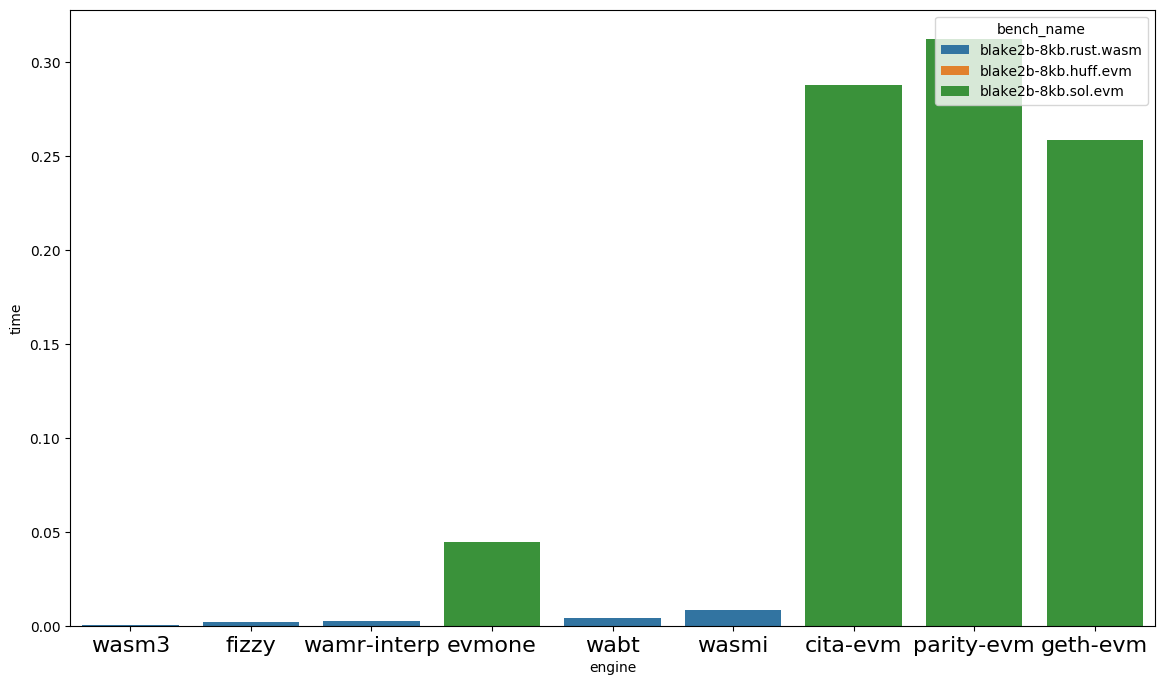

In [217]:
f = plt.figure(figsize=(14,8))
#sns.set()
#sns.reset_defaults()
#sns.set(font_scale = 1.2)
b = sns.barplot(x='engine', y='time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_evm_vs_wasm_blake2b_sorted)

b.set_xticklabels(b.get_xticklabels(), size = 16)

## Annotate bars with the millisecond times on seaborn plot

Text(0.5, 0.95, 'EVM vs Wasm interpreters: BLAKE2b-8415-bytes')

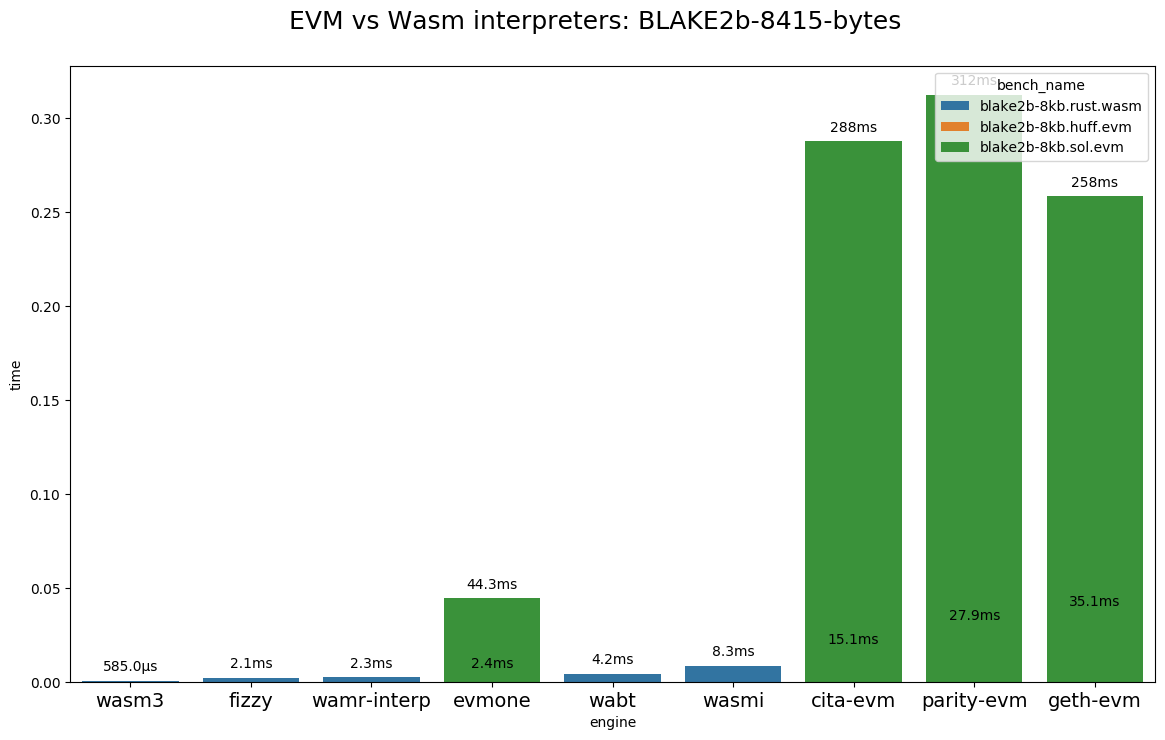

In [218]:
f = plt.figure(figsize=(14,8))
#sns.set()
sns.reset_defaults() # use default colors, orange and blue
#sns.set(font_scale = 1.2)
splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_evm_vs_wasm_blake2b_sorted)


# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

splot.set_xticklabels(splot.get_xticklabels(), size = 14)

f.suptitle("EVM vs Wasm interpreters: BLAKE2b-8415-bytes", fontsize=18, y=0.95)


### plot both blake2b.sol.evm, blake2b.huff.evm, and blake2b.rust.wasm

In [219]:
df_evm_vs_wasm_blake2b_all_three = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
    ['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm', 'blake2b-8kb.sol.evm']
)].copy()

In [220]:
df_evm_vs_wasm_blake2b_all_three

engine             bench_name  parse_time  exec_time      time
24       evmone    blake2b-8kb.sol.evm    0.000000   0.044307  0.044307
25   parity-evm    blake2b-8kb.sol.evm    0.000000   0.312272  0.312272
26     geth-evm    blake2b-8kb.sol.evm    0.000000   0.258288  0.258288
27     cita-evm    blake2b-8kb.sol.evm    0.000000   0.287592  0.287592
72       evmone   blake2b-8kb.huff.evm    0.000000   0.002448  0.002448
73   parity-evm   blake2b-8kb.huff.evm    0.000000   0.027909  0.027909
74     geth-evm   blake2b-8kb.huff.evm    0.000000   0.035076  0.035076
75     cita-evm   blake2b-8kb.huff.evm    0.000000   0.015140  0.015140
2         wasmi  blake2b-8kb.rust.wasm    0.002632   0.005685  0.008317
3          wabt  blake2b-8kb.rust.wasm    0.001594   0.002574  0.004168
5         wasm3  blake2b-8kb.rust.wasm    0.000012   0.000573  0.000585
6   wamr-interp  blake2b-8kb.rust.wasm    0.000671   0.001623  0.002293
7         fizzy  blake2b-8kb.rust.wasm    0.000056   0.002068  0.002124

In [221]:
#df_evm_vs_wasm_blake2b.loc[:,'time'] = df_evm_vs_wasm_blake2b['parse_time'] + df_evm_vs_wasm_blake2b['exec_time']

In [222]:
df_evm_vs_wasm_blake2b_all_three = df_evm_vs_wasm_blake2b_all_three.sort_values('time')

Text(0.5, 0.95, 'EVM vs Wasm interpreters: BLAKE2b-8415-bytes')

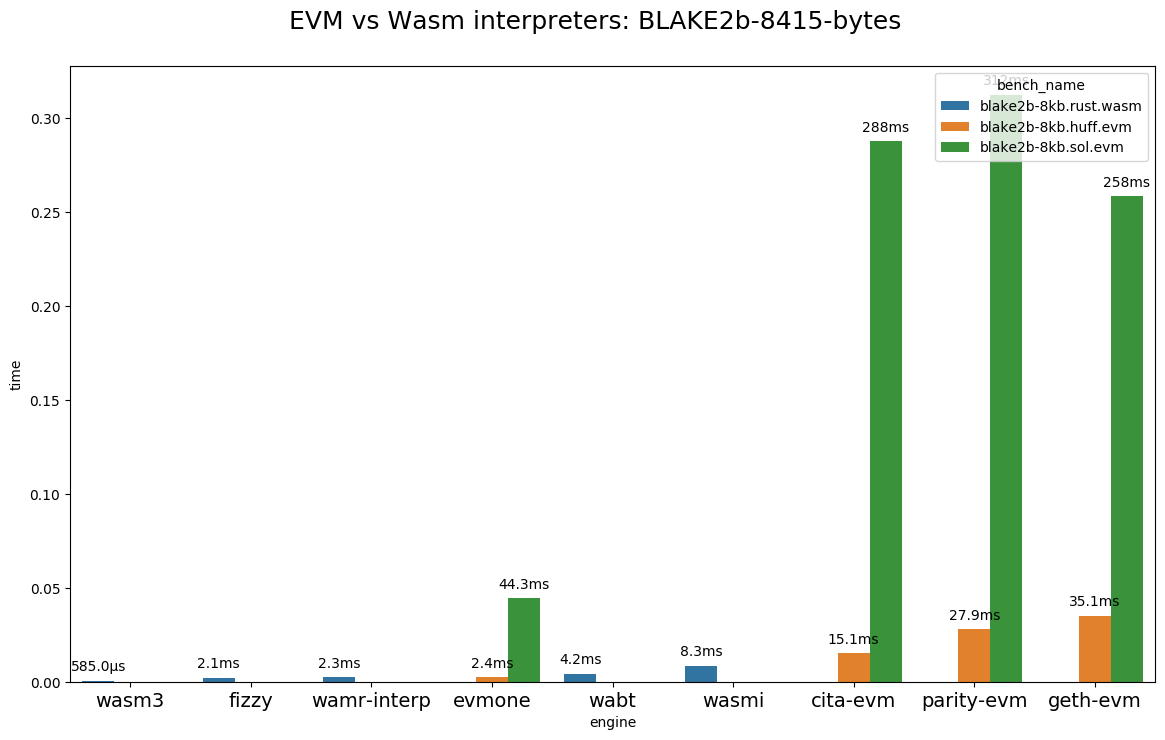

In [223]:
f = plt.figure(figsize=(14,8))
#sns.set()
sns.reset_defaults() # use default colors, orange and blue
#sns.set(font_scale = 1.2)
splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=True,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_evm_vs_wasm_blake2b_all_three)


# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

splot.set_xticklabels(splot.get_xticklabels(), size = 14)

f.suptitle("EVM vs Wasm interpreters: BLAKE2b-8415-bytes", fontsize=18, y=0.95)

## blake2b.huff.evm vs blake2b.rust.wasm

In [224]:
df_blake2b_huff_vs_wasm = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
    ['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm']
)].copy()

In [225]:
df_blake2b_huff_vs_wasm = df_blake2b_huff_vs_wasm.sort_values('time')

Text(0.5, 0.95, 'EVM vs Wasm: BLAKE2b-8415-bytes')

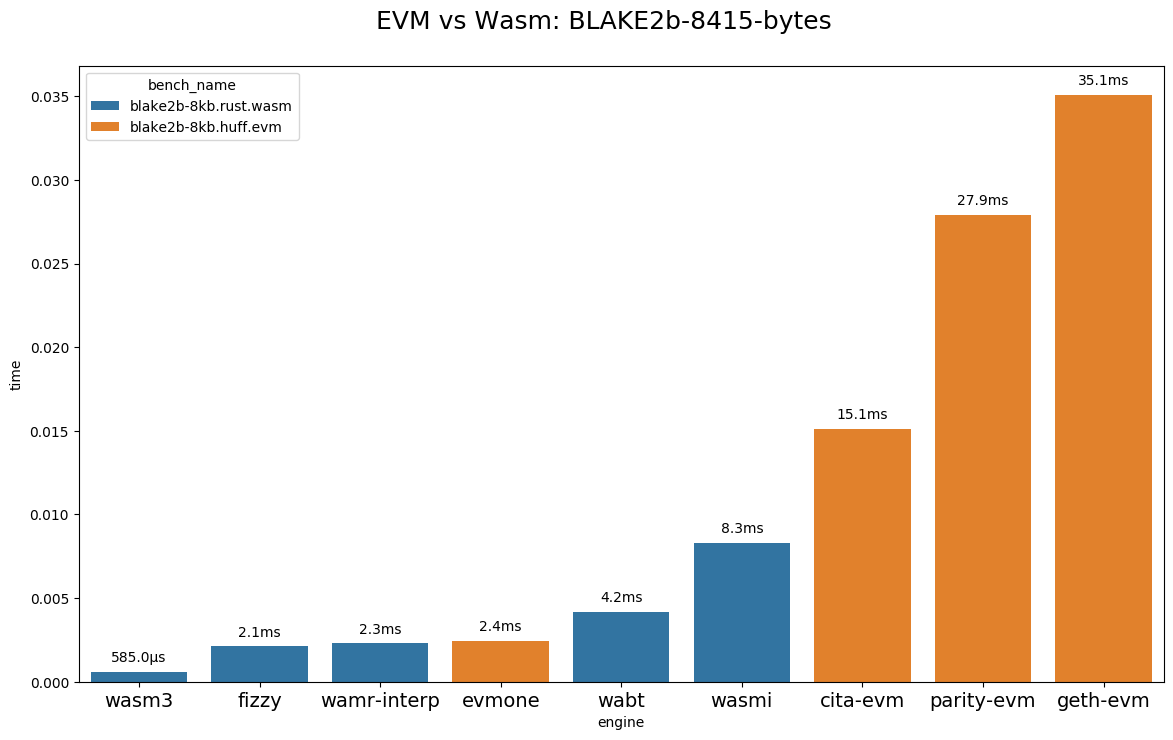

In [226]:
f = plt.figure(figsize=(14,8))
#sns.set()
sns.reset_defaults() # use default colors, orange and blue
#sns.set(font_scale = 1.2)
splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_blake2b_huff_vs_wasm)


# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

splot.set_xticklabels(splot.get_xticklabels(), size = 14)

f.suptitle("EVM vs Wasm: BLAKE2b-8415-bytes", fontsize=18, y=0.95)

### plot blake2b.sol.evm against blake2b.huff.evm

In [227]:
df_blake2b_sol_vs_huff = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
    ['blake2b-8kb.huff.evm', 'blake2b-8kb.sol.evm']
)].copy()

In [228]:
df_blake2b_sol_vs_huff = df_blake2b_sol_vs_huff.sort_values('time')

Text(0.5, 0.95, 'EVM implementations of BLAKE2b: Solidity vs Huff')

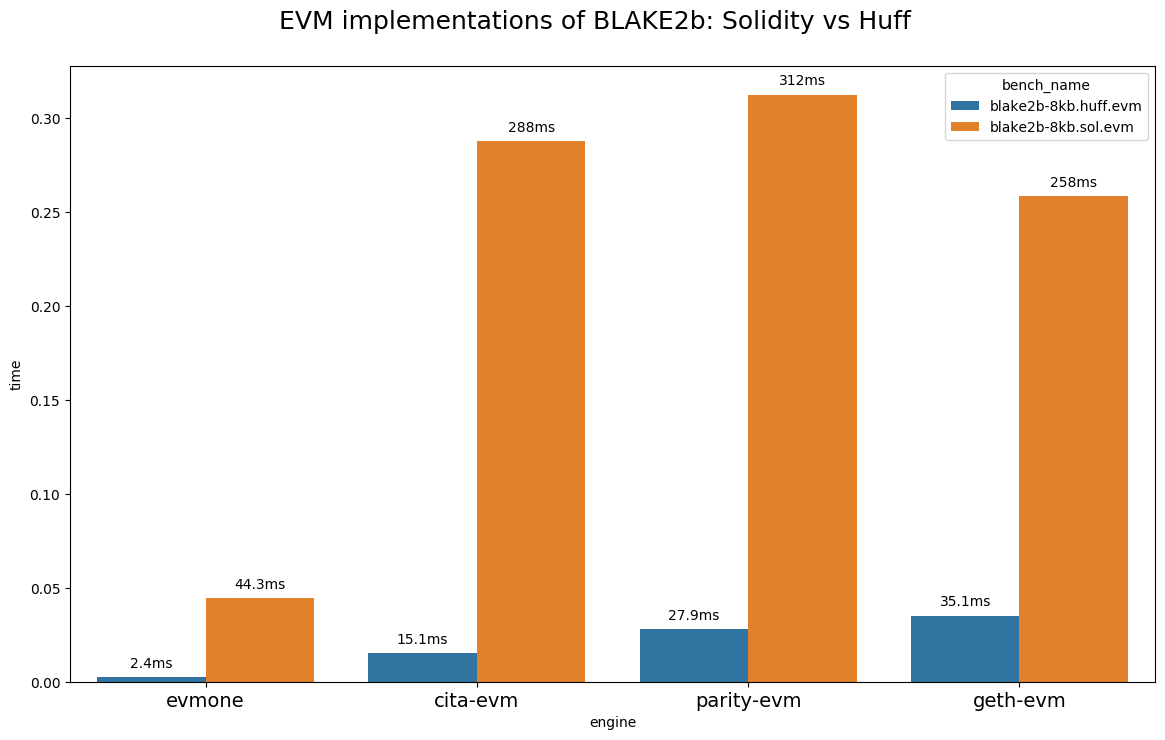

In [229]:
f = plt.figure(figsize=(14,8))
#sns.set()
sns.reset_defaults() # use default colors, orange and blue
#sns.set(font_scale = 1.2)
splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=True,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_blake2b_sol_vs_huff)


# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

splot.set_xticklabels(splot.get_xticklabels(), size = 14)

f.suptitle("EVM implementations of BLAKE2b: Solidity vs Huff", fontsize=18, y=0.95)

## plot blake2b.sol.evm against blake2b.rust.wasm

In [230]:
df_evm_vs_wasm_blake2b

engine             bench_name  parse_time  exec_time      time
24       evmone    blake2b-8kb.sol.evm    0.000000   0.044307  0.044307
25   parity-evm    blake2b-8kb.sol.evm    0.000000   0.312272  0.312272
26     geth-evm    blake2b-8kb.sol.evm    0.000000   0.258288  0.258288
27     cita-evm    blake2b-8kb.sol.evm    0.000000   0.287592  0.287592
72       evmone   blake2b-8kb.huff.evm    0.000000   0.002448  0.002448
73   parity-evm   blake2b-8kb.huff.evm    0.000000   0.027909  0.027909
74     geth-evm   blake2b-8kb.huff.evm    0.000000   0.035076  0.035076
75     cita-evm   blake2b-8kb.huff.evm    0.000000   0.015140  0.015140
2         wasmi  blake2b-8kb.rust.wasm    0.002632   0.005685  0.008317
3          wabt  blake2b-8kb.rust.wasm    0.001594   0.002574  0.004168
5         wasm3  blake2b-8kb.rust.wasm    0.000012   0.000573  0.000585
6   wamr-interp  blake2b-8kb.rust.wasm    0.000671   0.001623  0.002293
7         fizzy  blake2b-8kb.rust.wasm    0.000056   0.002068  0.002124

In [231]:
df_blake2b_sol_vs_rust = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['bench_name'].isin(
    ['blake2b-8kb.sol.evm', 'blake2b-8kb.rust.wasm']
)].copy()

In [232]:
df_blake2b_sol_vs_rust

engine             bench_name  parse_time  exec_time      time
24       evmone    blake2b-8kb.sol.evm    0.000000   0.044307  0.044307
25   parity-evm    blake2b-8kb.sol.evm    0.000000   0.312272  0.312272
26     geth-evm    blake2b-8kb.sol.evm    0.000000   0.258288  0.258288
27     cita-evm    blake2b-8kb.sol.evm    0.000000   0.287592  0.287592
2         wasmi  blake2b-8kb.rust.wasm    0.002632   0.005685  0.008317
3          wabt  blake2b-8kb.rust.wasm    0.001594   0.002574  0.004168
5         wasm3  blake2b-8kb.rust.wasm    0.000012   0.000573  0.000585
6   wamr-interp  blake2b-8kb.rust.wasm    0.000671   0.001623  0.002293
7         fizzy  blake2b-8kb.rust.wasm    0.000056   0.002068  0.002124

In [233]:
df_blake2b_sol_vs_rust = df_blake2b_sol_vs_rust.sort_values('time')

Text(0.5, 0.95, 'EVM vs Wasm interpreters: BLAKE2b-8415-bytes (Solidity-evm vs Rust-wasm)')

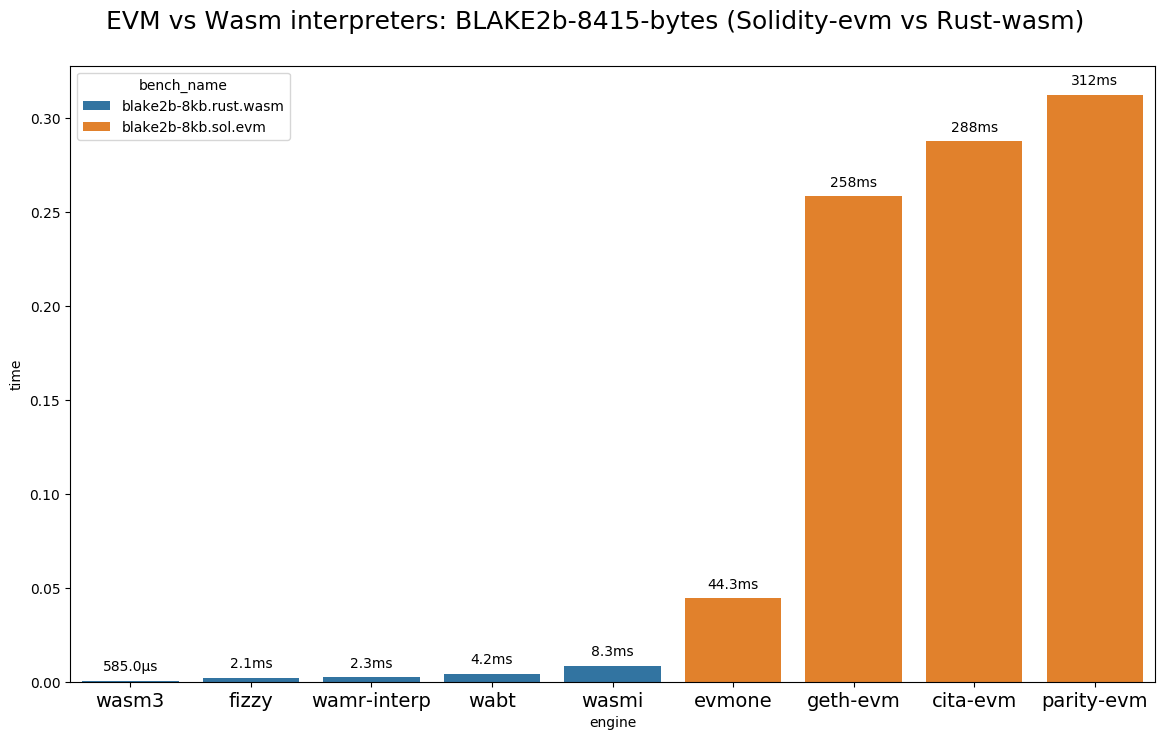

In [234]:
f = plt.figure(figsize=(14,8))
#sns.set()
sns.reset_defaults() # use default colors, orange and blue
#sns.set(font_scale = 1.2)
splot = sns.barplot(x='engine', y='time', hue='bench_name', dodge=False,
            #hue_order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #hue_order=['blake2b-8kb.rust.wasm', 'blake2b-8kb.huff.evm'],
            #order=['blake2b-8kb.huff.evm', 'blake2b-8kb.rust.wasm'],
            #order='exec_time',
            #order=[""]
            data=df_blake2b_sol_vs_rust)


# annotating bars: https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
                   #format(p.get_height(), '.4f'),
                   toMs(p.get_height()),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

splot.set_xticklabels(splot.get_xticklabels(), size = 14)

f.suptitle("EVM vs Wasm interpreters: BLAKE2b-8415-bytes (Solidity-evm vs Rust-wasm)", fontsize=18, y=0.95)

## Try EVM vs wasm shootout again, but use more grouped bars.

In [235]:
df_evm_blake2b = df_evm_raw[df_evm_raw['test_name'].isin(['blake2b-8415-bytes', 'blake2b_huff-8415-bytes'])].copy()

df_evm_blake2b.rename(columns={'test_name':'bench_name', 'total_time':'exec_time'},inplace=True)
df_evm_blake2b.drop(['gas_used'],axis=1,inplace=True)
df_evm_blake2b.loc[:, 'parse_time'] = 0
df_evm_blake2b = df_evm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]

df_evm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.sol.evm', inplace=True)
df_evm_blake2b.replace('blake2b_huff-8415-bytes', 'blake2b-8kb.huff.evm', inplace=True)


In [236]:
df_wasm_blake2b = df_interp[df_interp['test_name'] == "blake2b-8415-bytes"].copy()

df_wasm_blake2b.rename(columns={'test_name':'bench_name'},inplace=True)
df_wasm_blake2b.drop(['elapsed_time'],axis=1,inplace=True)
df_wasm_blake2b.drop(['total_time'],axis=1,inplace=True)
#df_wasm_blake2b = df_wasm_blake2b[['engine', 'bench_name', 'parse_time', 'exec_time']]
df_wasm_blake2b.reset_index(inplace=True)
df_wasm_blake2b.replace('blake2b-8415-bytes', 'blake2b-8kb.rust.wasm', inplace=True)



In [237]:
df_evm_vs_wasm_blake2b = df_evm_blake2b.append(df_wasm_blake2b, sort=False).copy()

In [238]:
df_evm_vs_wasm_blake2b = df_evm_vs_wasm_blake2b[df_evm_vs_wasm_blake2b['engine'].isin(
    ['parity-evm', 'geth-evm', 'evmone', 'cita-evm',
    'wasmi', 'wabt', 'wamr-interp', 'fizzy', 'wasm3']
)].copy()

<Figure size 640x480 with 0 Axes>

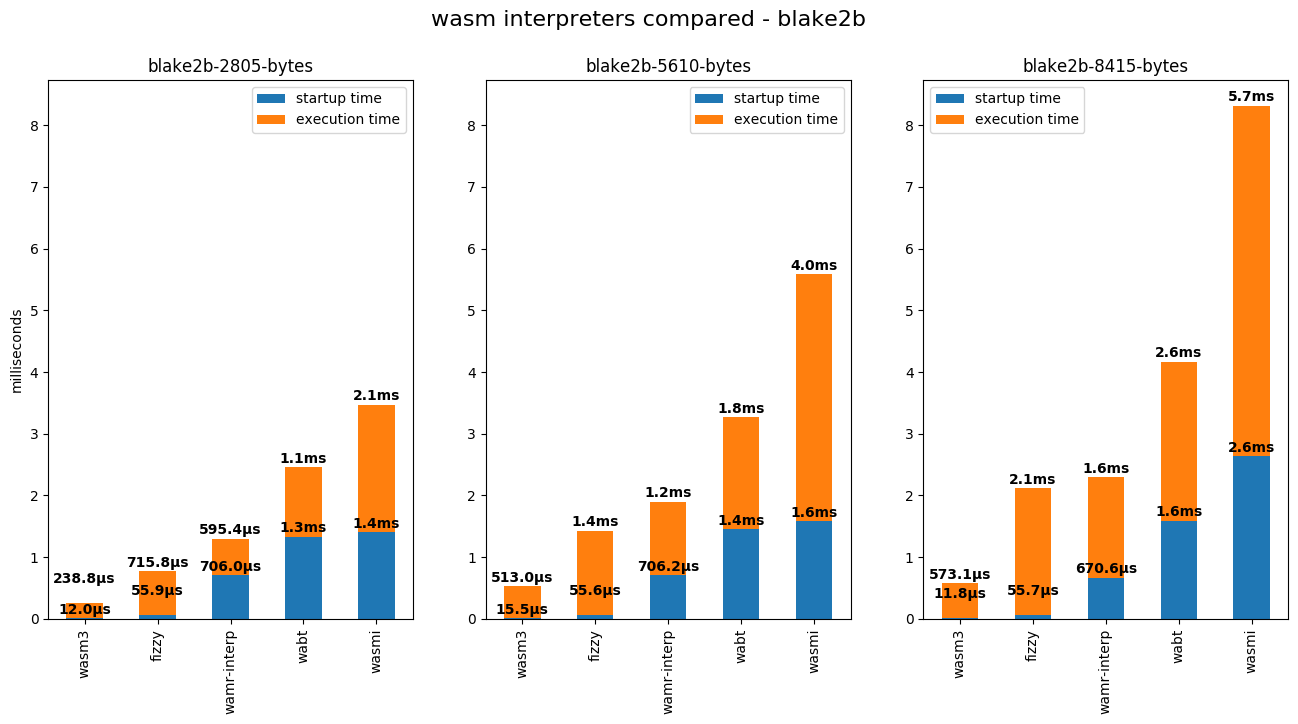

In [239]:
plotInterpThreeTests(df_interp,
                     blake2b_test_names,
                     title="wasm interpreters compared - blake2b",
                     filter_engines=["life", "wagon", "v8-interpreter"])